# EURONEXT LISBON - Forecasting with LSTM

### Preliminary Tasks

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error


#### Model Parameters

In [2]:
LOOK_BACK = 60
PERIODS_TO_PREDICT = 50
BATCH_SIZE = 25
EPOCHS=5
LEARN_RATE=0.001
VALIDATION_SPLIT=0.2
NUMBER_NEURONS=50
PERIOD='5y'
NUMBER_OF_LAYERS=2;

In [3]:
# Foreign stock tickers and names

NAME_FOREIGN = "PSI"
TICKER_PSI="PSI20.LS"

#NAME_FOREIGN='IBEX 35'
#TICKER_FOREIGN='^IBEX'

#NAME_FOREIGN='NYSE'
#TICKER_FOREIGN='^NYA'

#NAME_FOREIGN='CAC 40'
#TICKER_FOREIGN='^FCHI'

#NAME_FOREIGN='DAX'
#TICKER_FOREIGN='^GDAXI'

#NAME_FOREIGN='Ishares China ETF'
#TICKER_FOREIGN='FXI'

NAME_FOREIGN = "TESLA"
TICKER_FOREIGN = "TSLA"



#### Loading data from Yahoo

In [4]:
#df = pd.DataFrame(yf.Ticker('PSI20.LS').history(period = PERIOD))
#df=df.truncate(after="2023-02-01")
#df.to_csv('stocks10y.csv')

In [5]:
#df_other = pd.DataFrame(yf.Ticker(TICKER_FOREIGN).history(period = PERIOD)).truncate(after="2023-02-01")
#df_other.to_csv('.\bubble\stocks'+PERIOD+NAME_FOREIGN+'.csv')

In [6]:
#df_other = pd.DataFrame(yf.Ticker(TICKER_FOREIGN).history(period = PERIOD)).truncate(after="2023-02-01")
#df_other.to_csv('stocks'+PERIOD+NAME_FOREIGN+'.csv')

In [7]:
def load_df_other(name=NAME_FOREIGN):
    return pd.read_csv('stocks'+PERIOD+name+'.csv', index_col=0, parse_dates=True)


In [8]:
def load_df_portugal():
    return pd.read_csv('stocks.csv', index_col=0, parse_dates=True) if PERIOD=='5y' else pd.read_csv('stocks10y.csv', index_col=0, parse_dates=True)    

In [9]:
def load_multiple_index(end_date="2023-02-01") : 
    
    from datetime import timedelta

    # Load DFs
    df_other = load_df_other()
    df = load_df_portugal()


    # Truncate Data for different period analysis
    end_date=end_date + ' 00:00:00+00:00'
    df=df.truncate(after=pd.Timestamp(end_date))
    df_other=df_other.truncate(after=pd.Timestamp(end_date))


    #Correct Index so both tables have simple date format as index
    df.index = pd.to_datetime(df.index + timedelta(hours=1), utc=True).date
    df_other.index = pd.to_datetime(df_other.index, utc=True).date + timedelta(days=1)
    
    # get common indices
    common_indices = df.index.intersection(df_other.index)

    # select only rows with common indices
    df = df.loc[common_indices]
    df_other = df_other.loc[common_indices]

    return df, df_other

In [10]:
def load_multiple_index_new(features=[NAME_FOREIGN], end_date="2023-02-01") :
    from datetime import timedelta

    # Load DFs
    dfs =[]
    dfs.append(load_df_portugal())
    for feat in features :
        dfs.append(load_df_other(feat))

    #Fix end date
    end_date=end_date + ' 00:00:00+00:00'
    
    #Truncate Dfs and correcting index (date)
    for i in range(len(dfs)):
        dfs[i] = dfs[i].truncate(after=pd.Timestamp(end_date))
        if i==0 :
            dfs[i].index = pd.to_datetime(dfs[i].index + timedelta(hours=1), utc=True).date
        else:
            dfs[i].index = pd.to_datetime(dfs[i].index + timedelta(hours=1), utc=True).date + timedelta(days=1) 

    
    #get common indexes:
    common_indexes = dfs[0].index
    for df in dfs[1:]:
        common_indexes = common_indexes.intersection(df.index)

    for i in range(len(dfs)) :
        dfs[i] = dfs[i].loc[common_indexes]

    return dfs 
    

#### Intraday data

In [11]:
#!pip install mplfinance

In [12]:
# Foreign stock tickers and names

#NAME_FOREIGN = "PSI"
#TICKER_FOREIGN="PSI20.LS"

#NAME_FOREIGN='IBEX 35'
#TICKER_FOREIGN='^IBEX'

#NAME_FOREIGN='NYSE'
#TICKER_FOREIGN='^NYA'

#NAME_FOREIGN='CAC 40'
#TICKER_FOREIGN='^FCHI'

NAME_FOREIGN='DAX'
TICKER_FOREIGN='^GDAXI'

#NAME_FOREIGN='Ishares China ETF'
#TICKER_FOREIGN='FXI'

names = ["PSI","IBEX 35","CAC 40", "DAX"]
tickers = ["PSI20.LS","^IBEX","^FCHI","^GDAXI"]
dates = ["18-05-2023", "25-05-2023", "01-06-2023", "08-06-2023"]
lst_stocks = list(zip(names,tickers))
print(lst_stocks)



[('PSI', 'PSI20.LS'), ('IBEX 35', '^IBEX'), ('CAC 40', '^FCHI'), ('DAX', '^GDAXI')]


In [13]:
## To Read and write 
def saveIntradayToCsv(end_date_string, name = NAME_FOREIGN, tick=TICKER_FOREIGN) :
    from datetime import datetime, timedelta
    
    date_format = "%d-%m-%Y"
    ed = datetime.strptime(end_date_string, date_format).date()
    sd = ed - timedelta(days=7)
    
    df = yf.download(tickers=tick, start=sd, end=ed, interval="1m")
    df.to_csv('.\Intraday\stocks_id_'+name+'_'+ed.strftime("%d-%m-%Y")+'.csv')


In [14]:
def saveAllIntradayToCsv(enddate, lst=lst_stocks) :
    for stock_tuple in lst :
        saveIntradayToCsv(enddate, name=stock_tuple[0],tick=stock_tuple[1])


In [15]:
#saveAllIntradayToCsv("8-6-2023")

In [16]:
def load_df_intraday(name=NAME_FOREIGN, end="25-05-2023") : 
    return pd.read_csv('.\Intraday\stocks_id_'+name+'_'+end+'.csv', index_col=0, parse_dates=True)

In [17]:
def load_multiple_index_id(features, end="25-05-2023") :
    # Load DFs
    dfs = []
    for feat in features :
        dfs.append(load_df_intraday(name=feat, end=end))
    return dfs

In [18]:
def load_multiple_index_id_all(features,dates) :
    dfs = []
    for date in dates :
        dfs.append(load_multiple_index_id(features,end=date))
    
    for i in range(1,len(dfs)) :
        for j in range(0,len(dfs[0])):
            dfs[0][j] = pd.concat([dfs[0][j], dfs[i][j]])
    
    return dfs[0]

    dfs = []

    for date in dates:
        dfs.append(load_multiple_index_id(features, end=date))

    combined_df = pd.concat(dfs, axis=0)
    return combined_df   

      




In [19]:
#Adds the other markets to the global_data
def add_Other_Markets_global_data(dfs, gdata) :
    for i in range (1, len(dfs)) :
        nameCol = 'Other' + str(i) 
        #Renames the column of the close value of the foreign stock exchange
        dfs[i].rename(columns = {'Close':nameCol}, inplace = True)
        #Joins in one Dataframe
        gdata=gdata.join(dfs[i][nameCol])
    return gdata

### EDA - Exploratory Data Analysis

#### Daily Data

In [20]:
df=load_df_portugal()
#sns.set(rc={'figure.figsize':(15.27,15.27)})

Text(0, 0.5, 'y(t-246)')

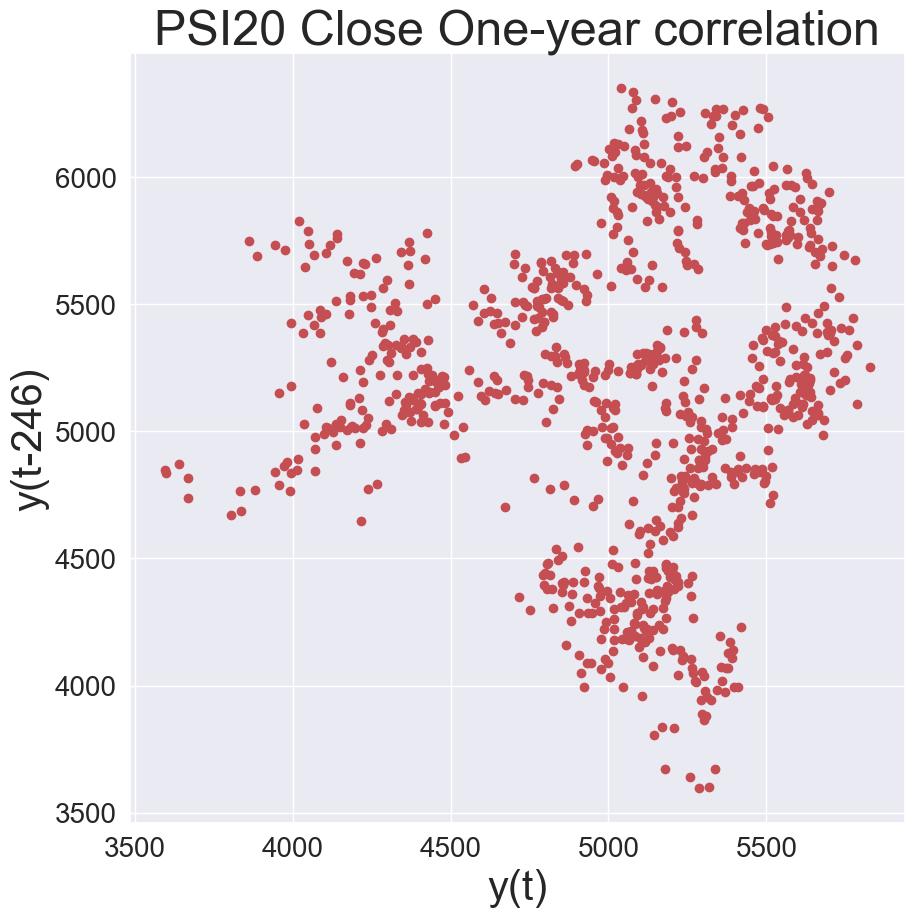

In [21]:
from pandas.plotting import lag_plot
import seaborn as sns
lg=246
colors = list()
palette = {0: "red", 1: "green", 2: "blue"}

sns.set(font_scale=1.0)
plt.figure(figsize = (10,10))
plt.title("PSI20 Close One-year correlation", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#lag_plot(df['Close'], lag=1)
lag_plot(df['Close'], c= 'r', lag=lg)
plt.xlabel('y(t)', fontsize=30)
plt.ylabel('y(t-'+str(lg)+')', fontsize=30)





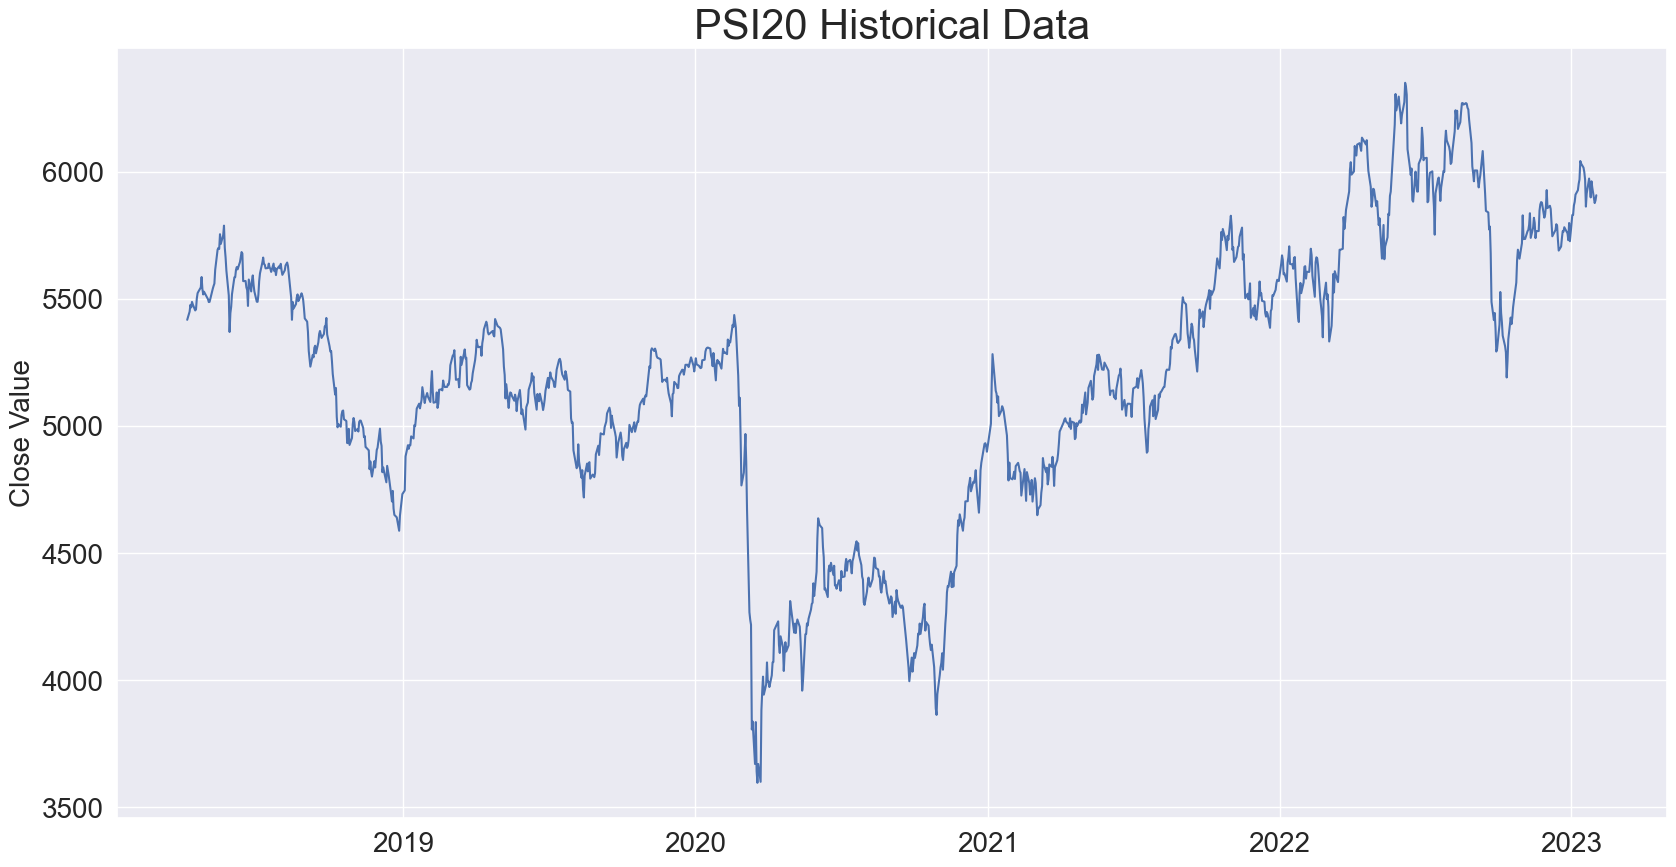

In [22]:
import seaborn as sns
plt.plot(df["Close"], label='PSI20 Daily Closing Values')
plt.title("PSI20 Historical Data", fontsize=30)
plt.ylabel('Close Value', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
import seaborn as sns
sns.set(font_scale=1.1)
#sns.set(rc={'figure.figsize':(15.27,15.27)})
#plt.hist(accuracies3)
#plt.show()
plt.show()  




In [23]:
df.Close

Date
2018-04-06 00:00:00+01:00    5417.060059
2018-04-09 00:00:00+01:00    5448.990234
2018-04-10 00:00:00+01:00    5475.839844
2018-04-11 00:00:00+01:00    5465.709961
2018-04-12 00:00:00+01:00    5487.540039
                                ...     
2023-01-26 00:00:00+00:00    5961.770020
2023-01-27 00:00:00+00:00    5936.729980
2023-01-30 00:00:00+00:00    5876.200195
2023-01-31 00:00:00+00:00    5886.339844
2023-02-01 00:00:00+00:00    5907.009766
Name: Close, Length: 1228, dtype: float64

In [24]:
df.describe()


Open         High          Low        Close        Volume  \
count  1228.000000  1228.000000  1228.000000  1228.000000  1.228000e+03   
mean   5197.101938  5227.978416  5164.300575  5195.969664  8.011948e+07   
std     540.078839   539.456283   541.184158   541.032964  4.245179e+07   
min    3554.699951  3613.669922  3500.020020  3596.080078  6.284000e+05   
25%    4902.504883  4933.772583  4877.552368  4903.747314  5.143135e+07   
50%    5218.574951  5240.354980  5191.094971  5219.030029  6.804180e+07   
75%    5586.112549  5614.227417  5553.397461  5583.119873  9.607812e+07   
max    6362.879883  6370.779785  6314.640137  6349.209961  3.252189e+08   

       Dividends  Stock Splits  
count     1228.0        1228.0  
mean         0.0           0.0  
std          0.0           0.0  
min          0.0           0.0  
25%          0.0           0.0  
50%          0.0           0.0  
75%          0.0           0.0  
max          0.0           0.0

In [25]:
df.Close.describe()

count    1228.000000
mean     5195.969664
std       541.032964
min      3596.080078
25%      4903.747314
50%      5219.030029
75%      5583.119873
max      6349.209961
Name: Close, dtype: float64

#### Intraday Data

In [26]:
dfs = []
for i in range(0, len(dates)) :
    dfs.append(load_df_intraday(names[0],dates[i]))

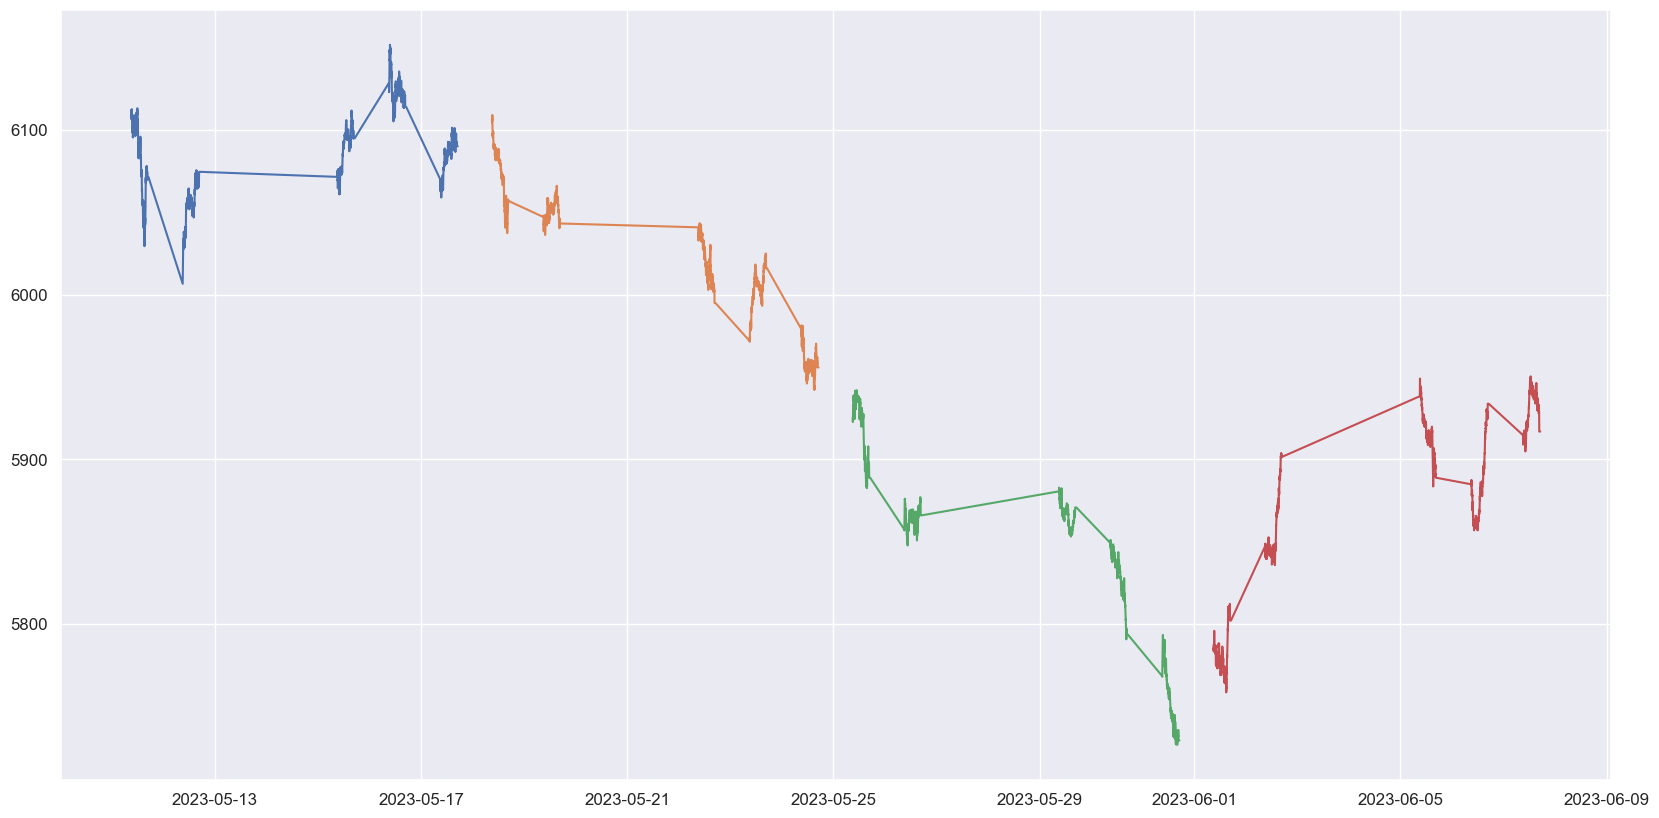

In [27]:
for i in range (len(dfs)):
    plt.plot(dfs[i]['Close'])
    #plt.plot(dfs[i]['Open'])

In [28]:
for i in range (len(dfs)):
    print("************ || Period ending in: || "+ dates[i] +" || ***************")
    print(dfs[i].info())
    

************ || Period ending in: || 18-05-2023 || ***************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2408 entries, 2023-05-11 09:00:00 to 2023-05-17 17:05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2408 non-null   float64
 1   High       2408 non-null   float64
 2   Low        2408 non-null   float64
 3   Close      2408 non-null   float64
 4   Adj Close  2408 non-null   float64
 5   Volume     2408 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 131.7 KB
None
************ || Period ending in: || 25-05-2023 || ***************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2405 entries, 2023-05-18 09:00:00 to 2023-05-24 17:05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2405 non-null   float64
 1   High       2405 non-null   float64
 2   Low        2405 non-null   float64
 3   

## Setting the Model

##### Data Preparation

In [29]:
#Dropping unwanted columns
def selectData(type='univariate', datframe=df) :
    if type=='univariate' :
        #data = datframe.drop(columns=['Open', 'High', 'Low','Volume','Dividends','Stock Splits'])
        data = datframe[["Close"]]
    else :
        data = datframe.drop(columns=['Open', 'High', 'Low','Dividends','Stock Splits'])
    size = len(data) - PERIODS_TO_PREDICT
    return data, size

In [30]:
# Divides Data into Train Data and Test Data
def divideData(data, size) : 
    train_data=data.values[0:size,:]
    test_data=data[-(LOOK_BACK+PERIODS_TO_PREDICT):].values
    return train_data,test_data

#### Scalers

In [31]:
# Scale Data between 0 and 1 
def scaleData(data,*scaler) :
    if len(scaler) == 1 :
        d1=data.copy()
        temp = scaler[0].fit_transform(d1[:, 0].reshape(-1,1))
        d1[:,0] = temp.squeeze()
        return d1
    else: 
        a1=scaler[0].fit_transform(data[:,0].reshape(-1,1))
        a2=scaler[1].fit_transform(data[:,1].reshape(-1,1))    
        scaled_data = np.array([a1,a2]).squeeze()
    return np.transpose(scaled_data)

In [32]:
def scaleDataMulti(data) : 
    scalers, sc_data = [], []
    
    for i in range (data.shape[1]) :
        scaler=MinMaxScaler(feature_range=(0,1))
        scalers.append(scaler)
        sc_data.append(scaler.fit_transform(data[:,i].reshape(-1,1)))
    
    sc_data = np.array(sc_data).squeeze().T

    return sc_data, scalers


In [33]:
def diffLogData (data, numVariables=1) : 
    if numVariables==1 :
        data = np.reshape(data,(data.shape[1], data.size))
        return np.diff(np.log(data)).T
    elif numVariables==2: 
        data=data.T
        return np.c_[np.diff(np.log(data[0])) , np.diff(np.log(data[1]))]

    #return np.transpose(np.diff(np.log(data)))

In [34]:
def diffLogData_new (data) : 
    numFeatures = data.shape[1]
    data=data.T
    result = np.diff(np.log(data[0]))
    
    for i in range (1, numFeatures) :
        result = np.c_[result , np.diff(np.log(data[i]))]

    return result









In [35]:
def undiffLogData (data, v0) :
    "Data is the array of logarithmic Differences and v0 is the initial absolute (price) of the test dataset"
    return v0 * np.concatenate(([1], np.exp(np.cumsum(data))))
    


In [36]:
def undiffLogData2 (actualData, diffLoggedData) :
    "Data is the array of logarithmic Differences and v0 is the actual prices on the period"
    #TODO in the data array add a "1" on position 0. - Concatenate.
    
    temp = np.exp(np.log(actualData[:-1]) - diffLoggedData)

    return np.concatenate((actualData[0:1], temp))

#### Train/Test Vector Creators

In [37]:
#%% Creates a vectors for training (2D numpy arrays)
def createTrainVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"
    
    x_train=[]

    for i in range(LOOK_BACK,len(data)):
        x_train.append(data[i-LOOK_BACK:i,0])
    
    return np.asarray(x_train)

In [38]:
def createBivTrainVector(data, size) :
    x0, x1 = [],[]
    for i in range(LOOK_BACK,size):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    x_data = np.array([np.asarray(x0),np.asarray(x1)]) 
    
    return np.transpose(x_data, (1, 2, 0))

    #x_data = np.array([np.asarray(x0),np.asarray(x1)]) 
    #return  np.reshape(x_data,(x_data.shape[1],x_data.shape[2],x_data.shape[0]))
   

In [39]:
def createMultiTrainVector(data):
    x_data = []
    #features = data.shape[1]
    
    for i in range(LOOK_BACK, len(data)):
        x_data.append(data[i-LOOK_BACK:i, :])
    
    return np.array(x_data)
    

In [40]:
#%% Creates a vectors with target data
def createTargetVector(data) :
    return np.asarray(data[LOOK_BACK:])

In [41]:
#%% Creates a vectors with target data for multiple horizon models (more than one day prediction)
def createTargetVectorHorizon(data,horizon) :
    "Horizon is the numbe of days predicted by the model"
    y_train=[]

    for i in range (LOOK_BACK,(len(data)-horizon)):
        y_train.append(data[i:i+horizon,0])
    
    return np.asarray(y_train)

In [42]:
#%% Creates a vectors with target data
from keras.utils import to_categorical
def createTargetClassVector(data, numCat=5) :
    data = data[LOOK_BACK:]
    percentiles = []
    y_data = []

    # Calculate Percentiles
    for i in range(0,numCat) :
            percentiles.append(np.percentile(data, (100/numCat)*i))
            
            
    # fill the vector with a classification number from 0 to [numCat]
    for i in range(0,len(data)):
        for j in reversed(range(0,numCat)) :
            if(data[i]>=percentiles[j]):
                y_data.append(j)
                break
                

    from keras.utils import to_categorical       
    #one hot encode the vector 
    return np.asarray(to_categorical(y_data, num_classes=len(np.unique(y_data))))
    


In [43]:
# CREATES a VECTOR FOR TEST WITH LENGTH = PERIODS_TO_PREDICT + LOOK_BACK
def selectTestData (data, size):
    test_data=data[size-LOOK_BACK:].values
    return test_data.reshape(-1,1)
    

In [44]:
# Creates an array for predicting PERIODS_TO_PREDICT
def createTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    X_test=[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        X_test.append(data[i-LOOK_BACK:i,0])
    X_test=np.array(X_test)

    #Reshaopes the vector for the predict function
    return np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [45]:
def createBivTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    x0,x1=[],[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    X_test = np.array([np.array(x0),np.array(x1)])
        
    return np.transpose(X_test, (1, 2, 0))

    #X_test = np.array([np.array(x0),np.array(x1)])
    #return np.reshape(X_test, (X_test.shape[1],X_test.shape[2],X_test.shape[0]))

#### LSTM Model

In [46]:
#%% Creates a LSTM Sequential model
def createLstmModel (data,outputs=1,type="regression") : 

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
    try:
        numSources = data.shape[2]
    except:
        numSources = 1
    

    input_shape=(np.shape(data)[1],numSources)
    lstm_model=Sequential()

    if (NUMBER_OF_LAYERS==1):
        lstm_model.add(LSTM(units=NUMBER_NEURONS, input_shape=input_shape))
    else:
        if(NUMBER_OF_LAYERS==2):
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            #lstm_model.add(Dropout(0.01))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2)))
        else:
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2),return_sequences=True))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/4)))

    #lstm_model.add(Dropout(0.01))
    
    # For single or multiple output (regression)
    if (type=="regression") : 
        lstm_model.add(Dense(units=outputs))
        lstm_model.compile(loss='mse',
                    optimizer=Adam(learning_rate=LEARN_RATE)
                    )
    #For Multiple outputs ( #(Category/Calssification))
    else : 
        lstm_model.add(Dense(units=outputs, activation = 'softmax'))
        lstm_model.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer=Adam(learning_rate=LEARN_RATE)
                )
    return lstm_model

In [47]:
#%% Trains the model -  data
def trainLstmModel (model, x_train, y_train,epoch=EPOCHS) :
    return model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=epoch,
                validation_split=VALIDATION_SPLIT,
                verbose='auto')

In [48]:
def plotHistory(history, yaxis="MAE", title="") :
    plt.plot(history.history['loss'], label='Train Data')
    plt.plot(history.history['val_loss'], label='Validation Data')
    plt.xlabel("EPOCHS", fontsize=20)
    plt.ylabel(yaxis, fontsize=20)
    #plt.title(title, fontsize=30, loc="center")
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()




# == RUNNING THE MODEL ==

#### Linear Univariate model

This model gives an estimate the PSI-20 value  based on the quotations of a sliding window of the [LOOK_BACK] days, before the estimated value.

In [323]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler)
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)

test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler)
X_test = createTestVector(scaled_test_data)

In [324]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[0.66142175 0.67301952 0.68277192 ... 0.71128137 0.70189929 0.6873122 ]
 [0.67301952 0.68277192 0.67909251 ... 0.70189929 0.6873122  0.68708714]
 [0.68277192 0.67909251 0.6870217  ... 0.6873122  0.68708714 0.69708304]
 ...
 [0.94719823 0.91393797 0.88062681 ... 0.80715397 0.79970062 0.77815803]
 [0.91393797 0.88062681 0.87143007 ... 0.79970062 0.77815803 0.78817202]
 [0.88062681 0.87143007 0.85933109 ... 0.77815803 0.78817202 0.78821565]]

y data - target

[[0.68708714]
 [0.69708304]
 [0.71674054]
 ...
 [0.78817202]
 [0.78821565]
 [0.8174441 ]]


In [325]:
lstm_model = createLstmModel(x_train_data)

print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data, epoch=5)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


KeyboardInterrupt: 

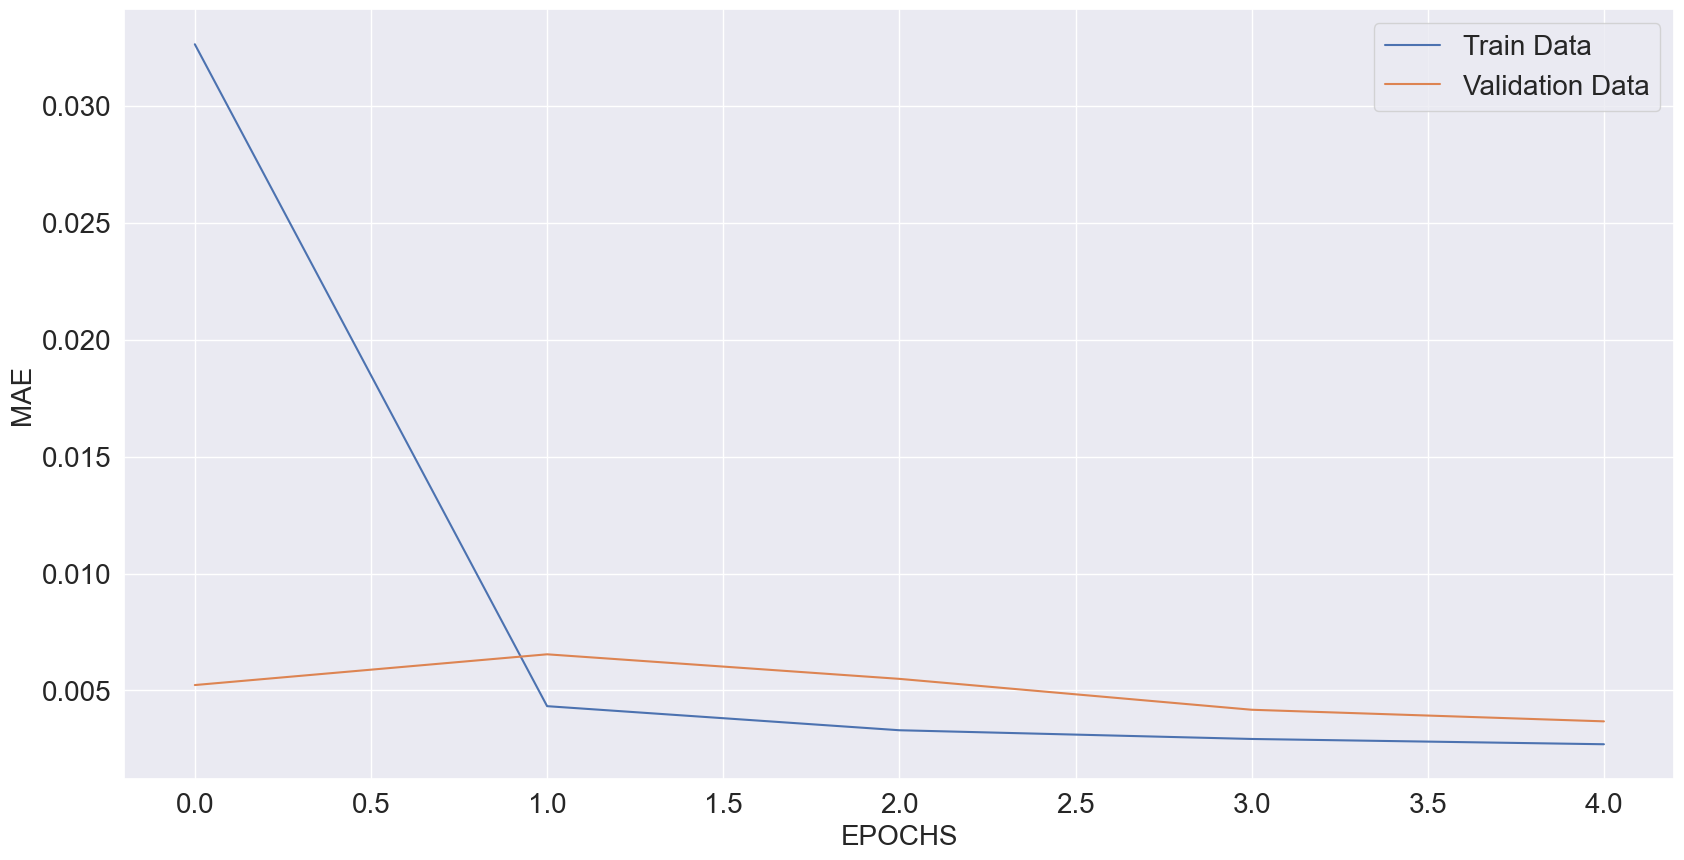

In [ ]:

plotHistory(history, title="Model A2 - Learning Curve")

#### Bivariate Model

In addition to the univariate method (above) This model also considers the volume of trading during the [LOOK_BACK] days before, to estimate the value of the index. 

In [ ]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='bivariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
test_data=global_data[size_train_data-LOOK_BACK:].values
scaled_test_data=scaleData(test_data,scaler,scaler2)
X_test = createBivTestVector(scaled_test_data)


In [ ]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[[0.66142175 0.17912755]
  [0.67301952 0.16570356]
  [0.68277192 0.14297492]
  ...
  [0.71128137 0.17516779]
  [0.70189929 0.21209308]
  [0.6873122  0.16785581]]

 [[0.67301952 0.16570356]
  [0.68277192 0.14297492]
  [0.67909251 0.14103678]
  ...
  [0.70189929 0.21209308]
  [0.6873122  0.16785581]
  [0.68708714 0.15244131]]

 [[0.68277192 0.14297492]
  [0.67909251 0.14103678]
  [0.6870217  0.2256896 ]
  ...
  [0.6873122  0.16785581]
  [0.68708714 0.15244131]
  [0.69708304 0.09367403]]

 ...

 [[0.94719823 0.1731588 ]
  [0.91393797 0.1427608 ]
  [0.88062681 0.33522022]
  ...
  [0.80715397 0.42877965]
  [0.79970062 0.46205665]
  [0.77815803 0.34610378]]

 [[0.91393797 0.1427608 ]
  [0.88062681 0.33522022]
  [0.87143007 0.23699523]
  ...
  [0.79970062 0.46205665]
  [0.77815803 0.34610378]
  [0.78817202 0.20667179]]

 [[0.88062681 0.33522022]
  [0.87143007 0.23699523]
  [0.85933109 0.16559326]
  ...
  [0.77815803 0.34610378]
  [0.78817202 0.20667179]
  [0.78821565 0.14928194]]]

y

In [ ]:
np.shape(x_train_data)[1],x_train_data.shape[2]

(60, 2)

In [ ]:

lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data, epoch=20)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10600     
                                                                 
 lstm_7 (LSTM)               (None, 25)                7600      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
36/36 [==============================] - 6s 76ms/step - loss: 0.0404 - val_loss: 0.0054
Epoch 2/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0033 - val_loss: 0.0097
Epoch 3/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0026 - val_loss: 0.0070
Epoch 4/20
3

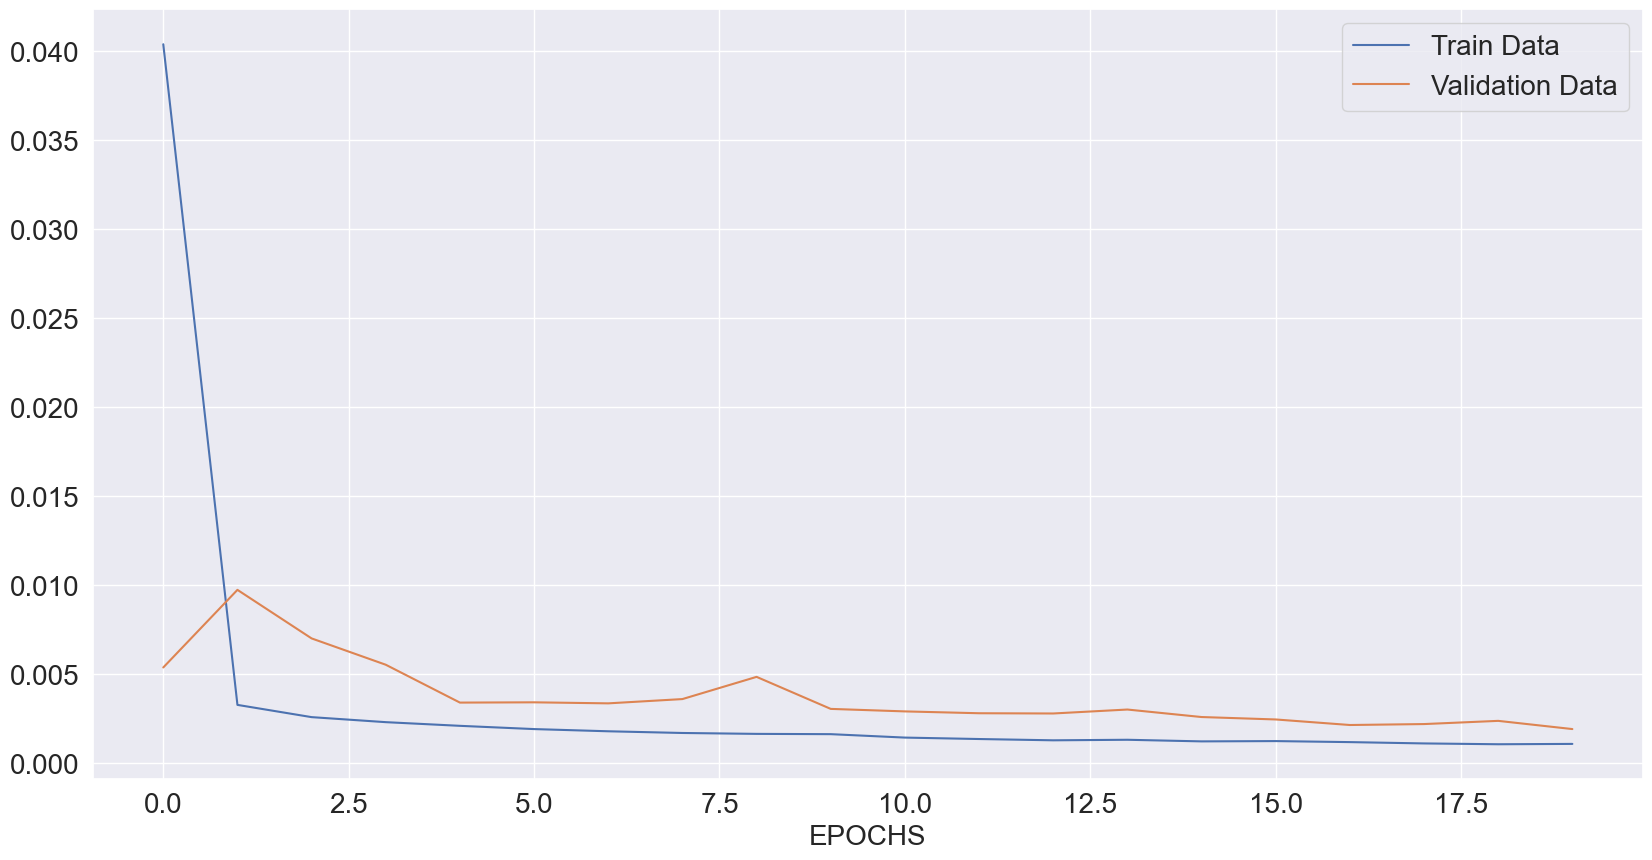

In [ ]:

plotHistory(history, "")

In [ ]:

lstm_biv_model.save('.\models\model_B1.h5')  # creates a HDF5 file 'my_model.h5'

#### Diff(log) model

This model works in similar way as the Linear univariate model. The difference is that the data is based on the difference of the logaritms between two consecutive days, providing insights on the daily variation in relation to the previous day.

In [ ]:
df = load_df_portugal()
df = df.truncate(after=pd.Timestamp('2021-05-05 00:00:00+00:00'))
df


Open         High          Low        Close  \
Date                                                                            
2018-04-06 00:00:00+01:00  5462.390137  5464.299805  5407.589844  5417.060059   
2018-04-09 00:00:00+01:00  5492.680176  5507.770020  5444.040039  5448.990234   
2018-04-10 00:00:00+01:00  5458.560059  5482.720215  5443.790039  5475.839844   
2018-04-11 00:00:00+01:00  5464.990234  5505.879883  5462.930176  5465.709961   
2018-04-12 00:00:00+01:00  5460.149902  5494.180176  5442.240234  5487.540039   
...                                ...          ...          ...          ...   
2021-04-28 00:00:00+01:00  5012.169922  5037.600098  5000.390137  5017.750000   
2021-04-29 00:00:00+01:00  5073.629883  5105.580078  5055.790039  5083.290039   
2021-04-30 00:00:00+01:00  5093.529785  5108.990234  5050.689941  5050.689941   
2021-05-03 00:00:00+01:00  5058.669922  5131.209961  5050.259766  5131.209961   
2021-05-04 00:00:00+01:00  5118.669922  5133.819824  5044.379883  5045.319824   

                              Volume  Dividends  Stock Splits  
Date                                                           
2018-04-06 00:00:00+01:00   58771500          0             0  
2018-04-09 00:00:00+01:00   54414200          0             0  
2018-04-10 00:00:00+01:00   47036700          0             0  
2018-04-11 00:00:00+01:00   46407600          0             0  
2018-04-12 00:00:00+01:00   73885100          0             0  
...                              ...        ...           ...  
2021-04-28 00:00:00+01:00   58875200          0             0  
2021-04-29 00:00:00+01:00  150038700          0             0  
2021-04-30 00:00:00+01:00  131772300          0             0  
2021-05-03 00:00:00+01:00   62732200          0             0  
2021-05-04 00:00:00+01:00   96603900          0             0  

[780 rows x 7 columns]

In [ ]:

global_data, size_train_data = selectData(type='univariate',datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)


In [ ]:

#EPOCHS=5
lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)      


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 20, 25)            7600      
                                                                 
 lstm_4 (LSTM)               (None, 12)                1824      
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 19,837
Trainable params: 19,837
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
18/18 [==============================] - 9s 186ms/step - loss: 1.4660e-04 - val_loss: 1.5411e-04
Epoch 2/150
18/18 [==============================] - 1s 53ms/step - 

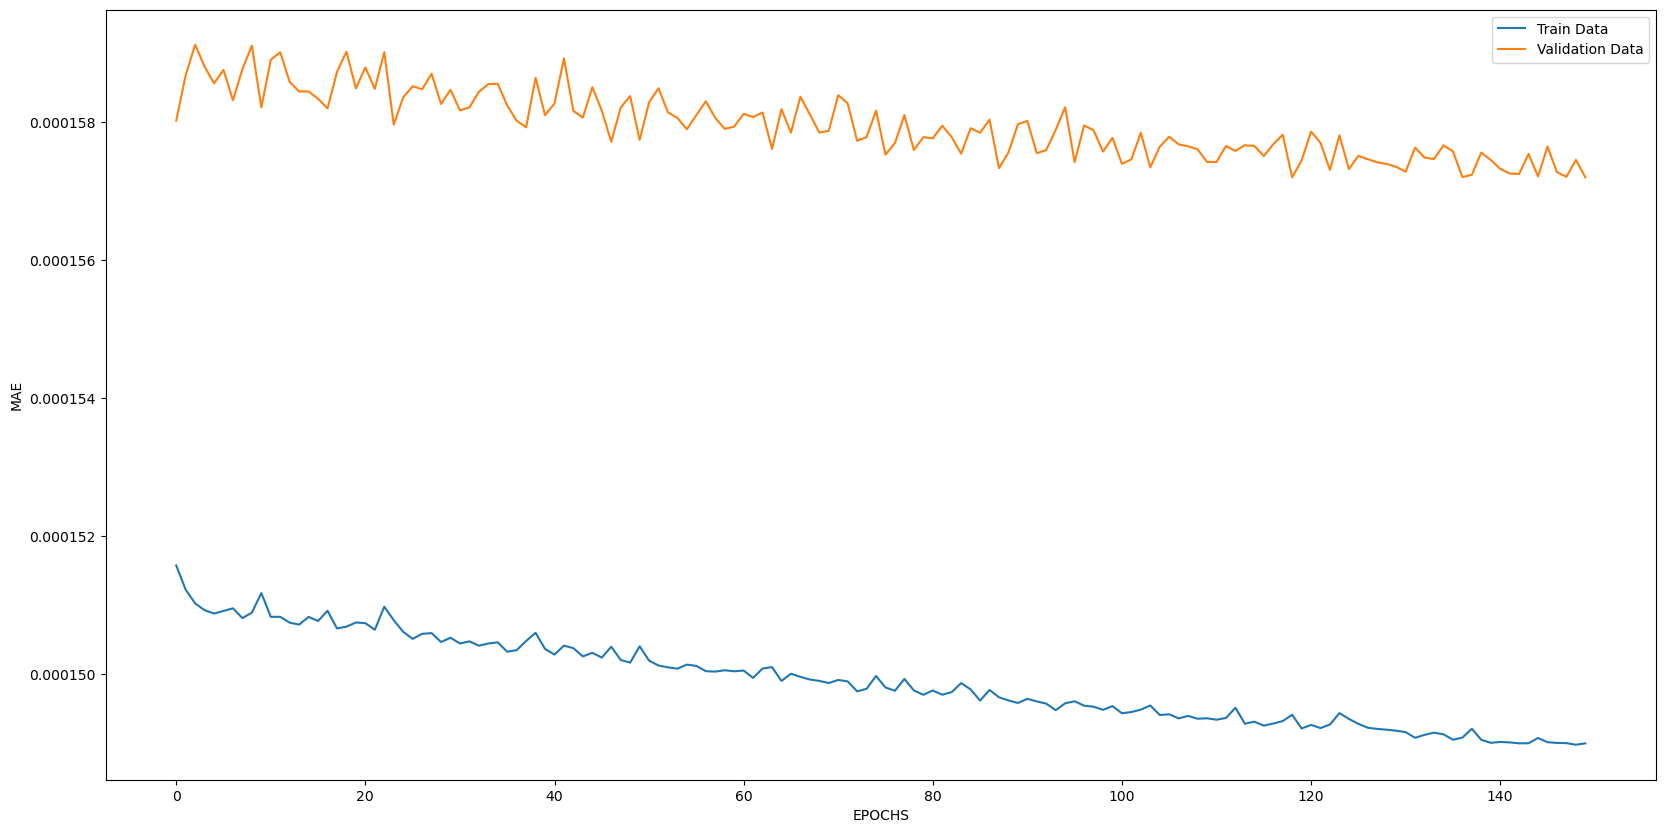

In [ ]:
                        
plotHistory(history)


#### Classification Model (based on Diff(log) model)

##### This model classifies the forecast into n different categories

In [ ]:
#df=df.truncate(after=pd.Timestamp('2022-02-01 00:00:00+00:00'))
df = load_df_portugal();
global_data, size_train_data = selectData(type='univariate', datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
difflogged_train_data=diffLogData(train_data)


In [ ]:

#Number of CAtegories to classify the data
numCat=3

# Preparing the arrays for the model
x_train_data = createTrainVector(difflogged_train_data)


In [ ]:

x_train_data = x_train_data[:-1]
y_train_data = createTargetClassVector(difflogged_train_data, numCat)


# Preparing Test Data
test_data=selectTestData(global_data,size_train_data)
difflogged_test_data=diffLogData(test_data)
X_test = createTestVector(difflogged_test_data)
Y_test = createTargetClassVector(difflogged_test_data, numCat)




In [ ]:
#Show how many observations are in each percentile

numCat=y_train_data.shape[1]
for i in range(0, numCat):
    print('percentile ' + str(i*int(100/numCat)) + ' = ' + str(np.count_nonzero(y_train_data[:,i] == 1)))


percentile 0 = 379
percentile 33 = 379
percentile 66 = 379


In [ ]:
lstm_class_model = createLstmModel(x_train_data, y_train_data.shape[1], type="classification")
print(lstm_class_model.summary())
print(len(x_train_data))
print("number of Epochs " + str(EPOCHS))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 3)                 78        
                                                                 
Total params: 18,078
Trainable params: 18,078
Non-trainable params: 0
_________________________________________________________________
None
1136
number of Epochs 150


In [ ]:

history = trainLstmModel(lstm_class_model, x_train_data, y_train_data)


Epoch 1/150


37/37 [==============================] - 4s 40ms/step - loss: 1.0995 - accuracy: 0.3392 - val_loss: 1.1026 - val_accuracy: 0.2544
Epoch 2/150
37/37 [==============================] - 1s 21ms/step - loss: 1.0983 - accuracy: 0.3535 - val_loss: 1.1033 - val_accuracy: 0.2544
Epoch 3/150
37/37 [==============================] - 1s 21ms/step - loss: 1.0984 - accuracy: 0.3535 - val_loss: 1.1086 - val_accuracy: 0.2544
Epoch 4/150
37/37 [==============================] - 1s 22ms/step - loss: 1.0987 - accuracy: 0.3535 - val_loss: 1.1058 - val_accuracy: 0.2544
Epoch 5/150
37/37 [==============================] - 1s 22ms/step - loss: 1.0981 - accuracy: 0.3535 - val_loss: 1.1066 - val_accuracy: 0.2544
Epoch 6/150
37/37 [==============================] - 1s 21ms/step - loss: 1.0981 - accuracy: 0.3535 - val_loss: 1.1067 - val_accuracy: 0.2544
Epoch 7/150
37/37 [==============================] - 1s 21ms/step - loss: 1.0993 - accuracy: 0.3535 - val_loss: 1.1063 - val_accuracy: 0.2544
Epoch 8/150
37/37 

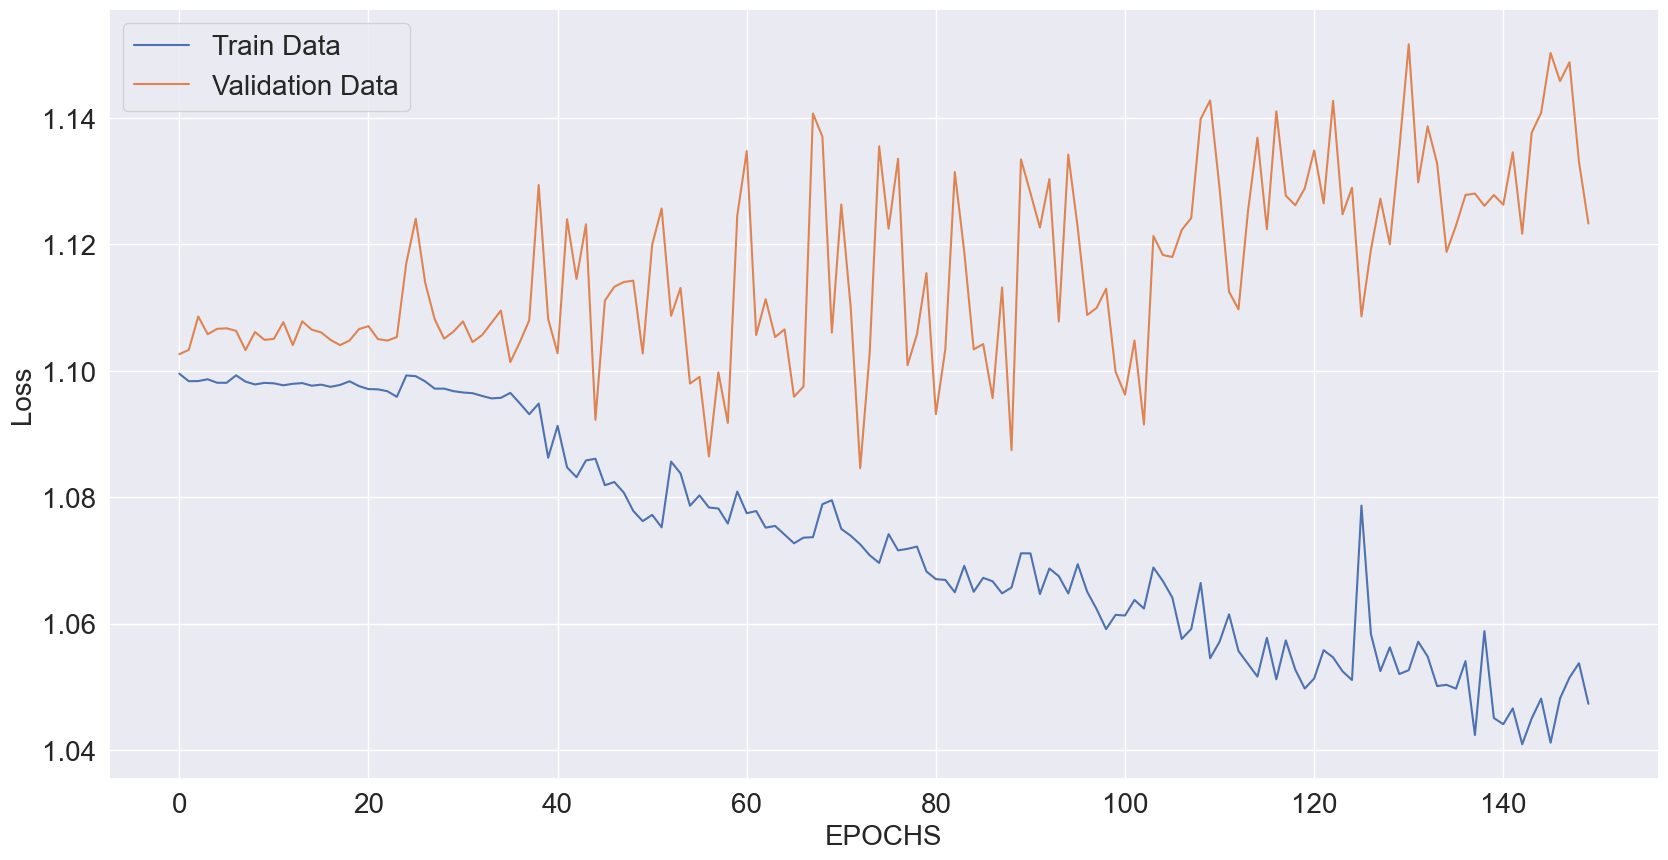

In [ ]:
plotHistory(history, yaxis="Loss")

In [ ]:
from keras.models import load_model

lstm_model.save('.\models\model_c1.h5')  # creates a HDF5 file 'my_model.h5'

NameError: name 'lstm_model' is not defined

## Linear Model with foreign X_Data

#### This model predicts the PSI-20 index based on the information from the last 90 days of another stock exchange

In [ ]:
df, df_other = load_multiple_index(end_date="2022-08-01")
df


Open         High          Low        Close     Volume  \
2018-05-04  5493.379883  5511.290039  5485.919922  5487.790039   57870500   
2018-05-07  5513.689941  5531.500000  5506.319824  5527.759766   59076900   
2018-05-08  5510.660156  5539.560059  5480.609863  5539.560059  116329700   
2018-05-09  5557.060059  5568.930176  5542.729980  5550.390137   89739500   
2018-05-10  5569.100098  5576.879883  5533.459961  5559.620117   62554800   
...                 ...          ...          ...          ...        ...   
2022-07-26  6020.549805  6048.160156  5998.979980  5998.979980   88841300   
2022-07-27  6052.080078  6116.770020  6022.500000  6116.720215  130040900   
2022-07-28  6159.060059  6211.040039  6092.839844  6160.720215  144036400   
2022-07-29  6160.759766  6215.740234  6091.399902  6123.229980  107436700   
2022-08-01  6119.830078  6149.959961  6082.200195  6096.990234   53516500   

            Dividends  Stock Splits  
2018-05-04          0             0  
2018-05-07          0             0  
2018-05-08          0             0  
2018-05-09          0             0  
2018-05-10          0             0  
...               ...           ...  
2022-07-26          0             0  
2022-07-27          0             0  
2022-07-28          0             0  
2022-07-29          0             0  
2022-08-01          0             0  

[1079 rows x 7 columns]

In [ ]:
df_other

Open         High          Low        Close     Volume  \
2018-05-04  5495.709961  5516.049805  5485.990234  5516.049805   85333000   
2018-05-07  5511.939941  5532.120117  5503.700195  5531.419922   45591900   
2018-05-08  5523.910156  5529.149902  5496.390137  5521.930176   70214400   
2018-05-09  5520.649902  5535.240234  5511.580078  5534.629883   72894200   
2018-05-10  5532.370117  5547.200195  5522.910156  5545.950195   48972800   
...                 ...          ...          ...          ...        ...   
2022-07-26  6225.169922  6243.859863  6194.959961  6211.450195   60556300   
2022-07-27  6206.250000  6267.799805  6199.930176  6257.939941   69640600   
2022-07-28  6304.129883  6339.209961  6236.569824  6339.209961   92169500   
2022-07-29  6413.100098  6472.270020  6397.910156  6448.500000  103116600   
2022-08-01  6447.180176  6484.080078  6434.120117  6436.859863   64439900   

            Dividends  Stock Splits  
2018-05-04          0             0  
2018-05-07          0             0  
2018-05-08          0             0  
2018-05-09          0             0  
2018-05-10          0             0  
...               ...           ...  
2022-07-26          0             0  
2022-07-27          0             0  
2022-07-28          0             0  
2022-07-29          0             0  
2022-08-01          0             0  

[1079 rows x 7 columns]

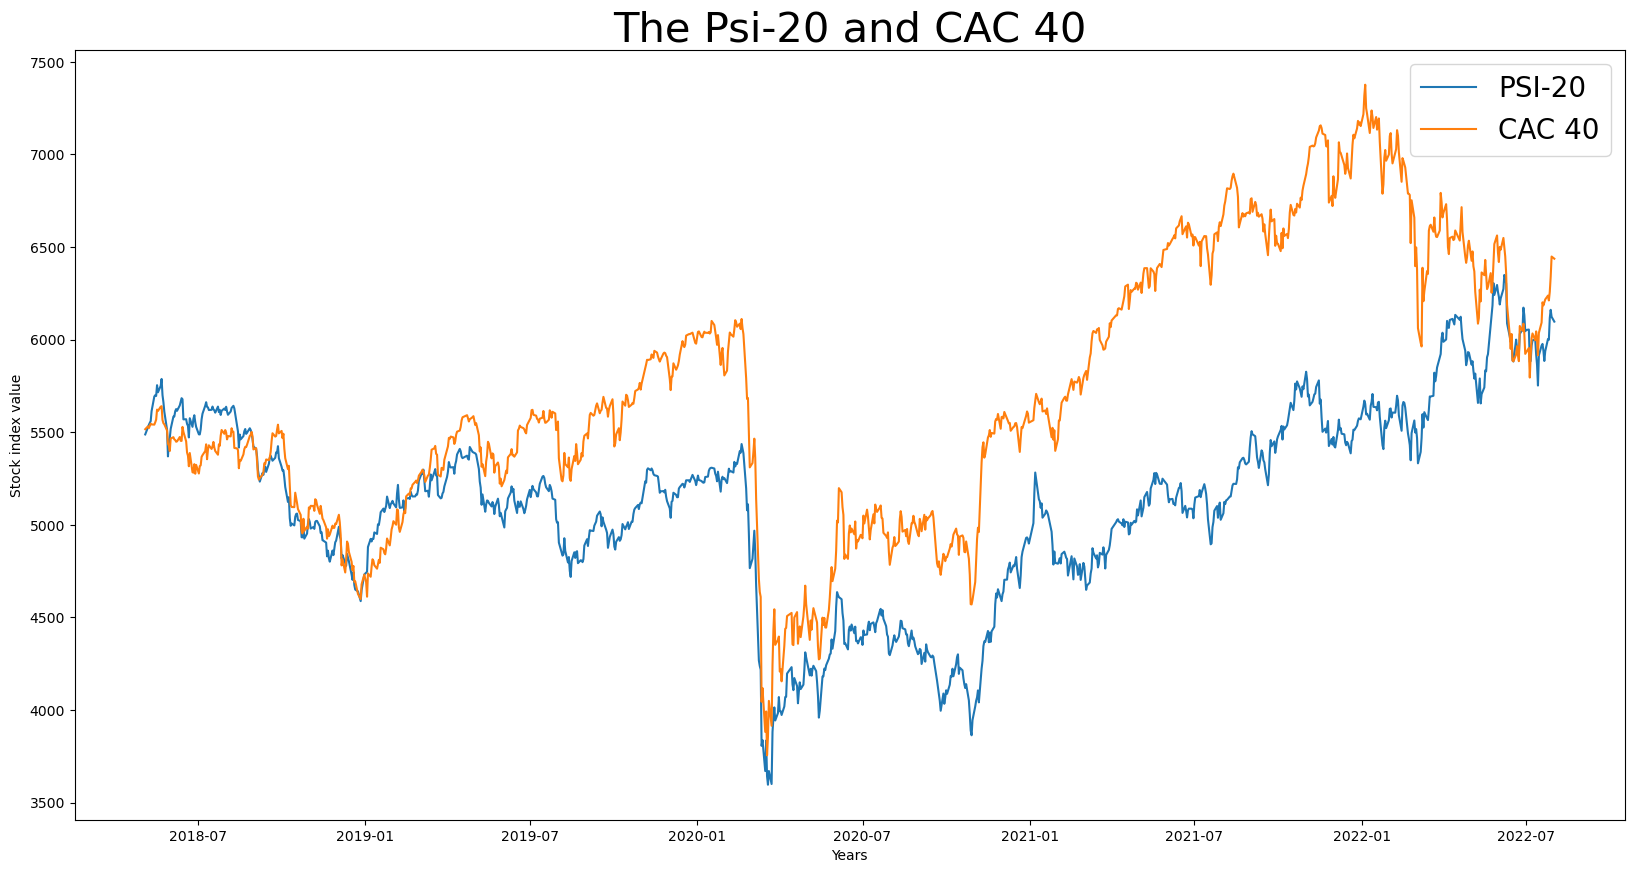

In [ ]:
plt.plot(df['Close'], label='PSI-20')
plt.plot(df_other['Close'], label=NAME_FOREIGN)
plt.xlabel("Years")
plt.ylabel("Stock index value")
plt.title("The Psi-20 and "+NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [ ]:
# Cleans unwanted columns leaving only index and close value
global_data, size_train_data = selectData(type='univariate', datframe=df_other) 

#Divides the data in train_data and test_data
train_data,test_data = divideData(global_data, size_train_data)

#Scales the data
scaler_f=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler_f)

#Create the vector for X_train_data
x_train_data = createTrainVector(scaled_train_data, size_train_data)

In [ ]:
# Cleans unwanted columns leaving only index and close value
global_data_p, size_train_data_p = selectData(type='univariate', datframe=df) 

#Divides the data in train_data and test_data
train_data_p,test_data_p = divideData(global_data_p, size_train_data_p)

#Scales the data
scaler_p=MinMaxScaler(feature_range=(0,1))
scaled_train_data_p=scaleData(train_data_p,scaler_p)

#Create the vector for Y_train_data 
y_train_data = createTargetVector(scaled_train_data_p)

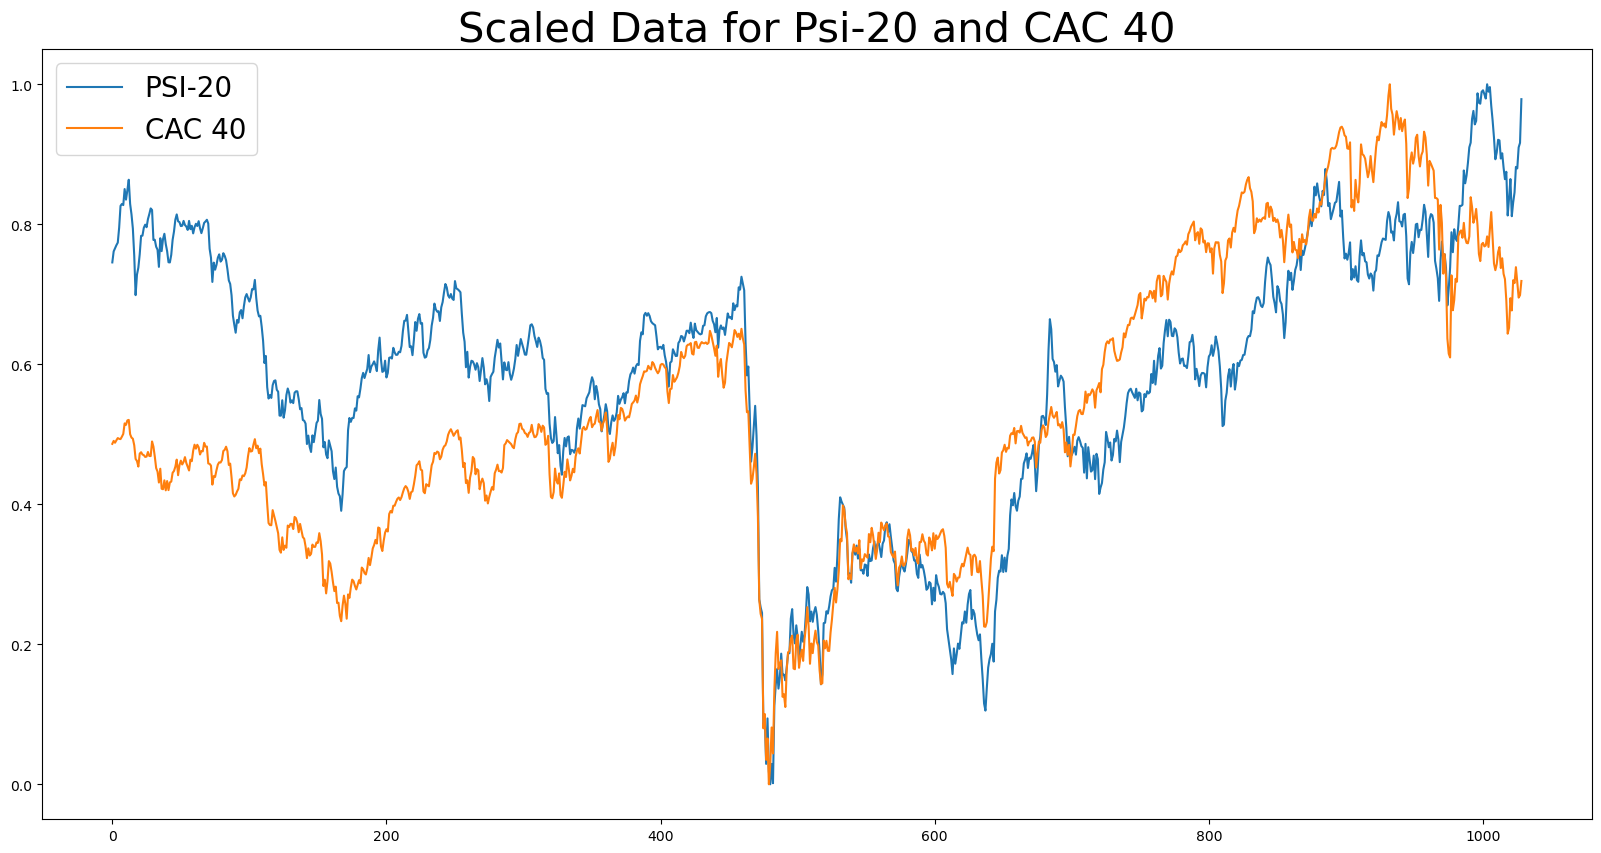

In [ ]:
plt.plot(scaled_train_data_p, label='PSI-20')
plt.plot(scaled_train_data, label=NAME_FOREIGN)
#plt.plot(y_train_data, label='y_target')
#plt.xlabel("Years")
#plt.ylabel("Stock index value")
plt.title("Scaled Data for Psi-20 and "+ NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [ ]:
#Preaparing the X_test matrix
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler_f)
X_test = createTestVector(scaled_test_data)

print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)


In [ ]:
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
27/27 [==============================] - 4s 73ms/step - loss: 0.1359 - val_loss: 0.0207
Epoch 2/200
27/27 [==============================] - 1s 49ms/step - loss: 0.0163 - val_loss: 0.0185
Epoch 3/200
27/27 [==============================] - 1s 48ms/step - loss: 0.0141 - val_loss: 0.0209
Epoch 4/2

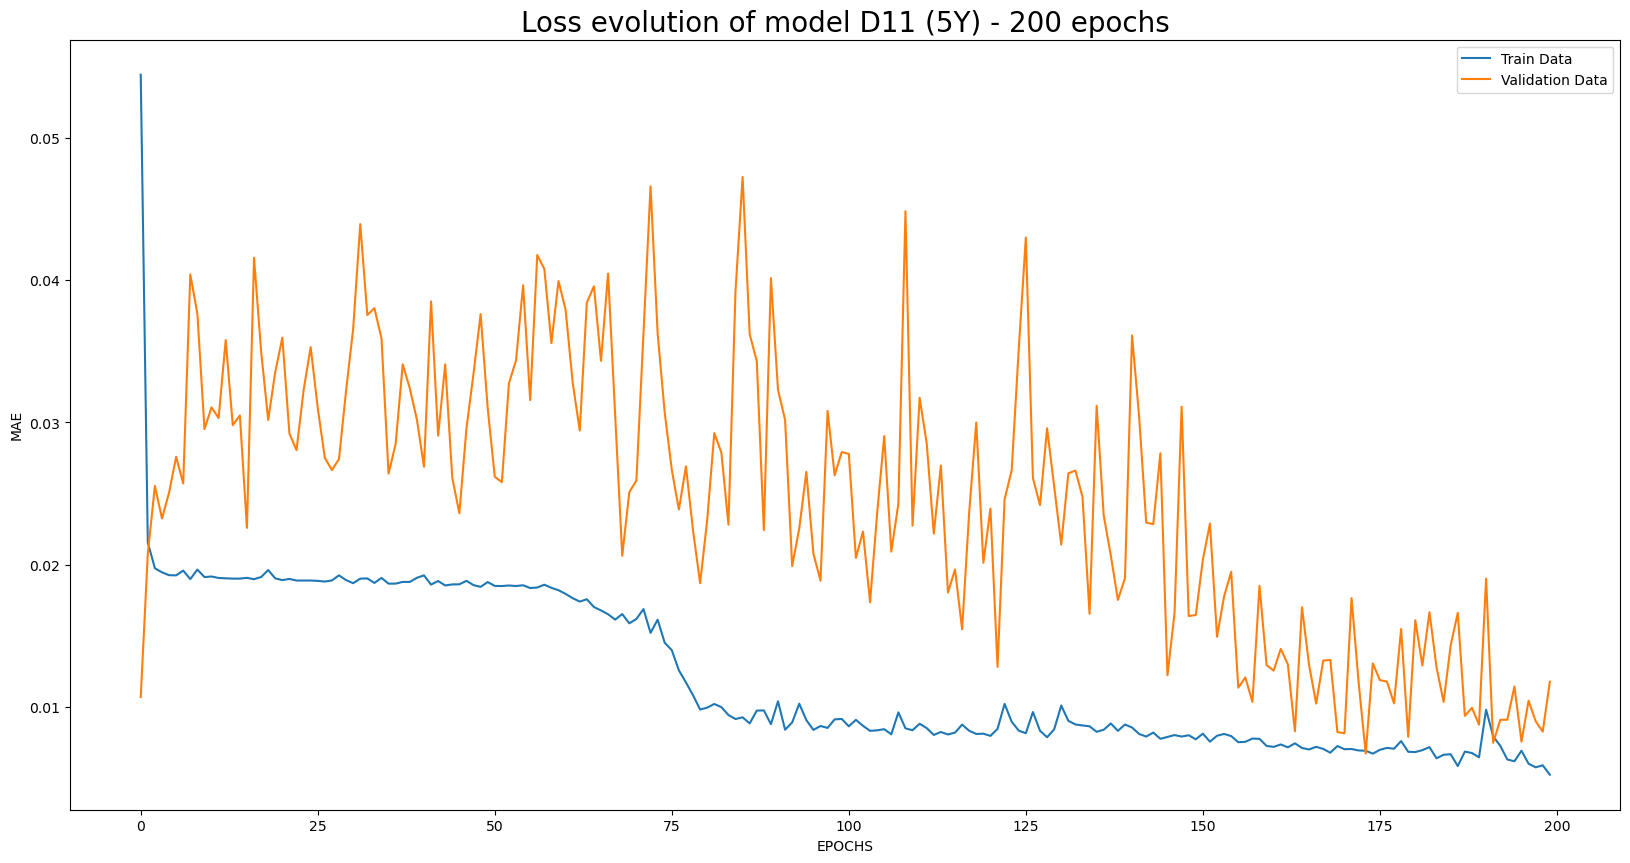

In [ ]:
plotHistory(history, title="Loss evolution of model D21 (5Y) - 200 epochs")

## Bi-Index Stocks model

#### This model predicts the PSI-20 index based on the information from the last 90 days of the PSI-20 AND another stock exchange

In [ ]:
# Loads Data (includes disregarding dates only present in one dataframe)
df, df_other = load_multiple_index(end_date="2022-01-01")

# Cleans PSI-20 unwanted columns leaving only index and close value
global_data_p, size_train_data = selectData(type='univariate', datframe=df) 


# Cleans Foreign unwanted columns leaving only index and close value
global_data_f, size_train_data_f = selectData(type='univariate', datframe=df_other) 

#Renames the column of the close value of the foreign stock exchange
global_data_f.rename(columns = {'Close':'Other1'}, inplace = True)


# Joins the thow tables in one
global_data=global_data_p.join(global_data_f["Other1"])


global_data



Close        Other1
2018-05-02  5498.049805  10088.900391
2018-05-03  5486.779785  10038.799805
2018-05-04  5487.790039  10104.099609
2018-05-07  5527.759766  10140.900391
2018-05-08  5539.560059  10168.099609
...                 ...           ...
2021-12-23  5513.330078   8563.700195
2021-12-27  5534.890137   8622.099609
2021-12-28  5560.790039   8688.900391
2021-12-29  5574.500000   8673.700195
2021-12-30  5571.669922   8713.799805

[930 rows x 2 columns]

In [ ]:
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
test_data=global_data[size_train_data-LOOK_BACK:].values
scaled_test_data=scaleData(test_data,scaler,scaler2)
X_test = createBivTestVector(scaled_test_data)


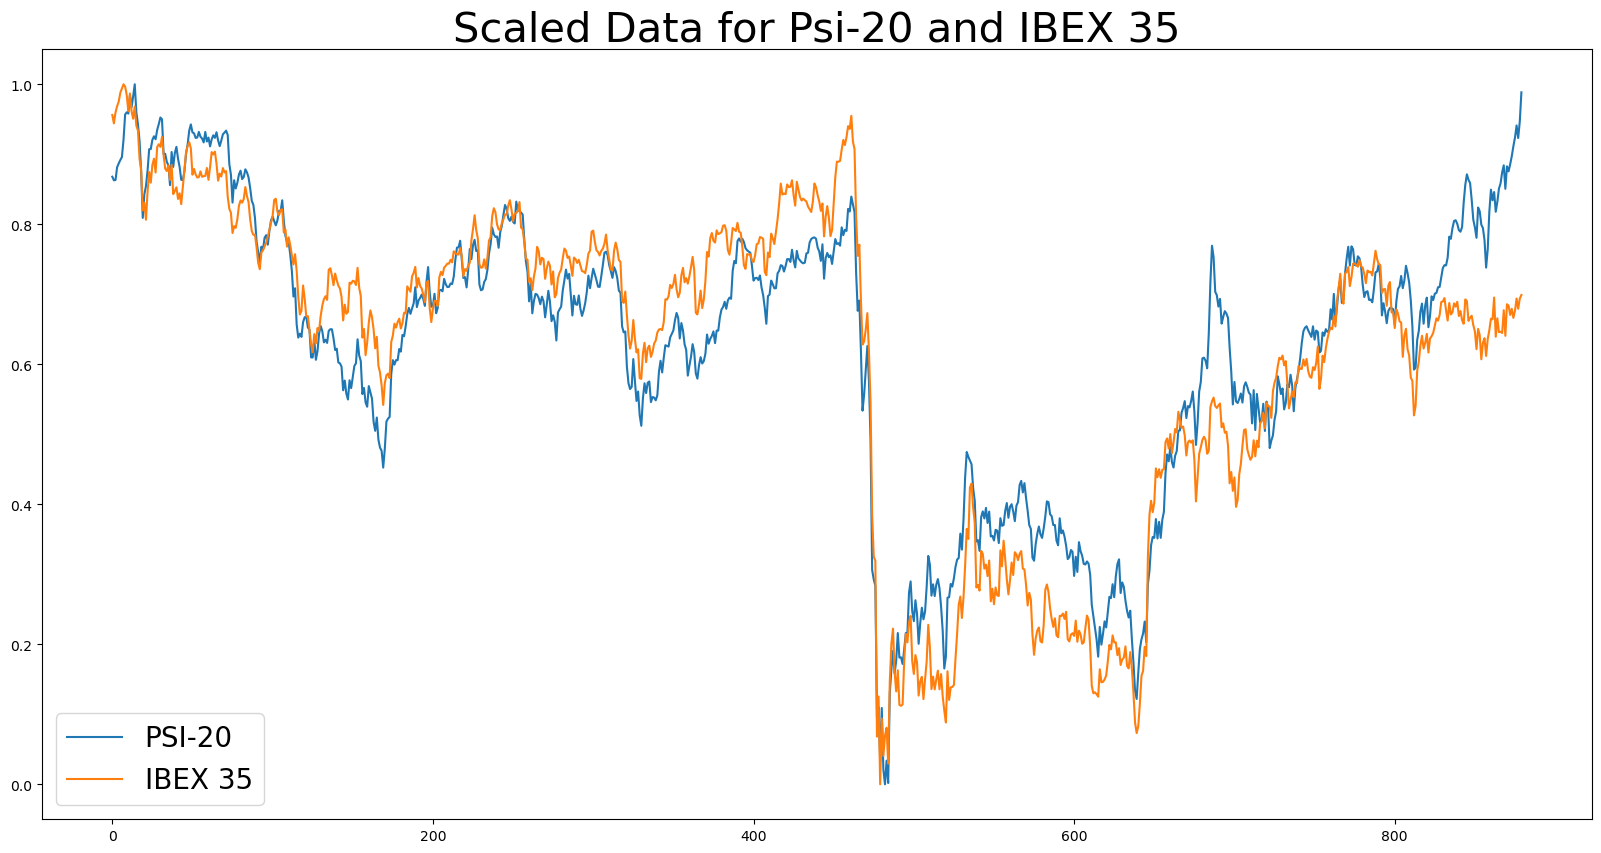

In [ ]:
plt.plot(scaled_train_data[:,0], label='PSI-20')
plt.plot(scaled_train_data[:,1], label=NAME_FOREIGN)
#plt.plot(y_train_data, label='y_target')
#plt.xlabel("Years")
#plt.ylabel("Stock index value")
plt.title("Scaled Data for Psi-20 and "+ NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [ ]:
"""
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)
"""

'\nprint("x data\n")\nprint(x_train_data)\nprint("\ny data - target\n")\nprint(y_train_data)\n'

In [ ]:
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10600     
                                                                 
 lstm_13 (LSTM)              (None, 25)                7600      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
82/82 [==============================] - 4s 23ms/step - loss: 0.0282 - val_loss: 0.0101
Epoch 2/150
82/82 [==============================] - 1s 15ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 3/150
82/82 [==============================] - 1s 15ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 4/1

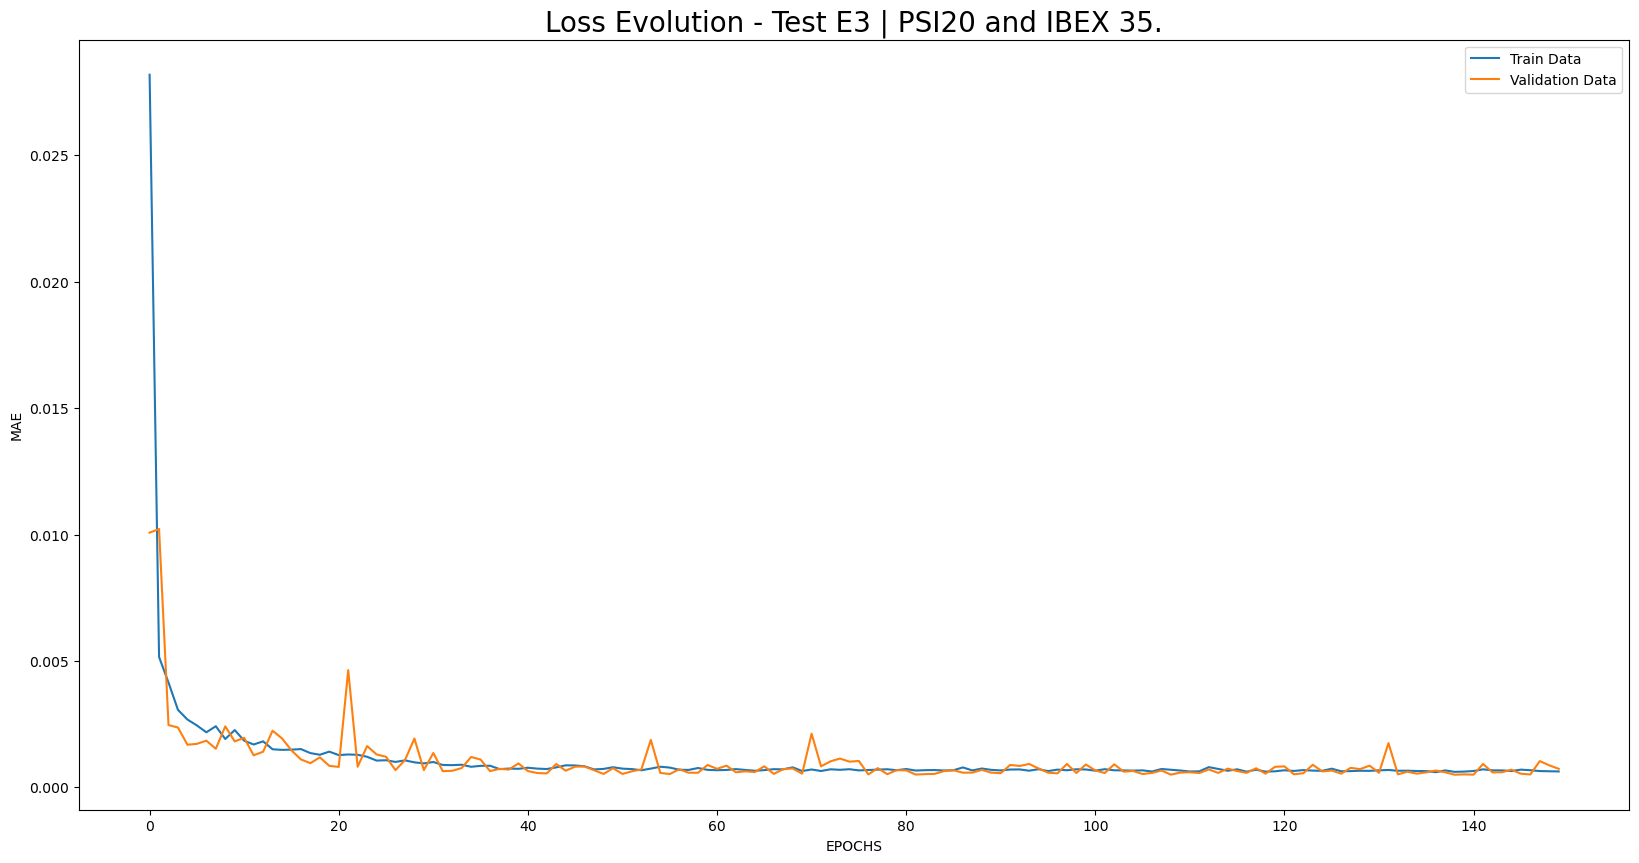

In [ ]:
plotHistory(history,title="Loss Evolution - Test H3 | PSI20 and " + NAME_FOREIGN +"." )

## Multi predictor

In [ ]:
HORIZON = 10
PERIODS_TO_PREDICT = HORIZON + 2

df = load_df_portugal()
df = df.truncate(after=pd.Timestamp('2022-04-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='univariate',datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
df



Open         High          Low        Close  \
Date                                                                            
2018-04-06 00:00:00+01:00  5462.390137  5464.299805  5407.589844  5417.060059   
2018-04-09 00:00:00+01:00  5492.680176  5507.770020  5444.040039  5448.990234   
2018-04-10 00:00:00+01:00  5458.560059  5482.720215  5443.790039  5475.839844   
2018-04-11 00:00:00+01:00  5464.990234  5505.879883  5462.930176  5465.709961   
2018-04-12 00:00:00+01:00  5460.149902  5494.180176  5442.240234  5487.540039   
...                                ...          ...          ...          ...   
2022-03-28 00:00:00+01:00  5843.839844  5921.040039  5843.839844  5904.990234   
2022-03-29 00:00:00+01:00  5944.799805  5964.379883  5893.839844  5921.839844   
2022-03-30 00:00:00+01:00  5928.220215  6007.680176  5909.950195  6007.680176   
2022-03-31 00:00:00+01:00  6005.830078  6069.270020  5977.640137  6036.970215   
2022-04-01 00:00:00+01:00  6046.890137  6046.890137  5979.299805  5988.120117   

                              Volume  Dividends  Stock Splits  
Date                                                           
2018-04-06 00:00:00+01:00   58771500          0             0  
2018-04-09 00:00:00+01:00   54414200          0             0  
2018-04-10 00:00:00+01:00   47036700          0             0  
2018-04-11 00:00:00+01:00   46407600          0             0  
2018-04-12 00:00:00+01:00   73885100          0             0  
...                              ...        ...           ...  
2022-03-28 00:00:00+01:00  214343800          0             0  
2022-03-29 00:00:00+01:00  250690800          0             0  
2022-03-30 00:00:00+01:00  183456100          0             0  
2022-03-31 00:00:00+01:00  156673300          0             0  
2022-04-01 00:00:00+01:00  108895100          0             0  

[1013 rows x 7 columns]

In [ ]:
#This x_train is smaller as the horizon of prediction values are removed.
x_train_data = createTrainVector(scaled_train_data[:-HORIZON])
#And Y train data is bi-dimensional
y_train_data = createTargetVectorHorizon(scaled_train_data, HORIZON)

In [ ]:

#Test Data Preparation
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data[:-HORIZON])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 10)                260       
                                                                 
Total params: 18,260
Trainable params: 18,260
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
24/24 [==============================] - 4s 69ms/step - loss: 1.4612e-04 - val_loss: 9.7301e-05
Epoch 2/150
24/24 [==============================] - 1s 34ms/step - loss: 1.4606e-04 - val_loss: 9.7328e-05
Epoch 3/150
24/24 [==============================] - 1s 35ms/step - loss: 1.4604e-04 - val_lo

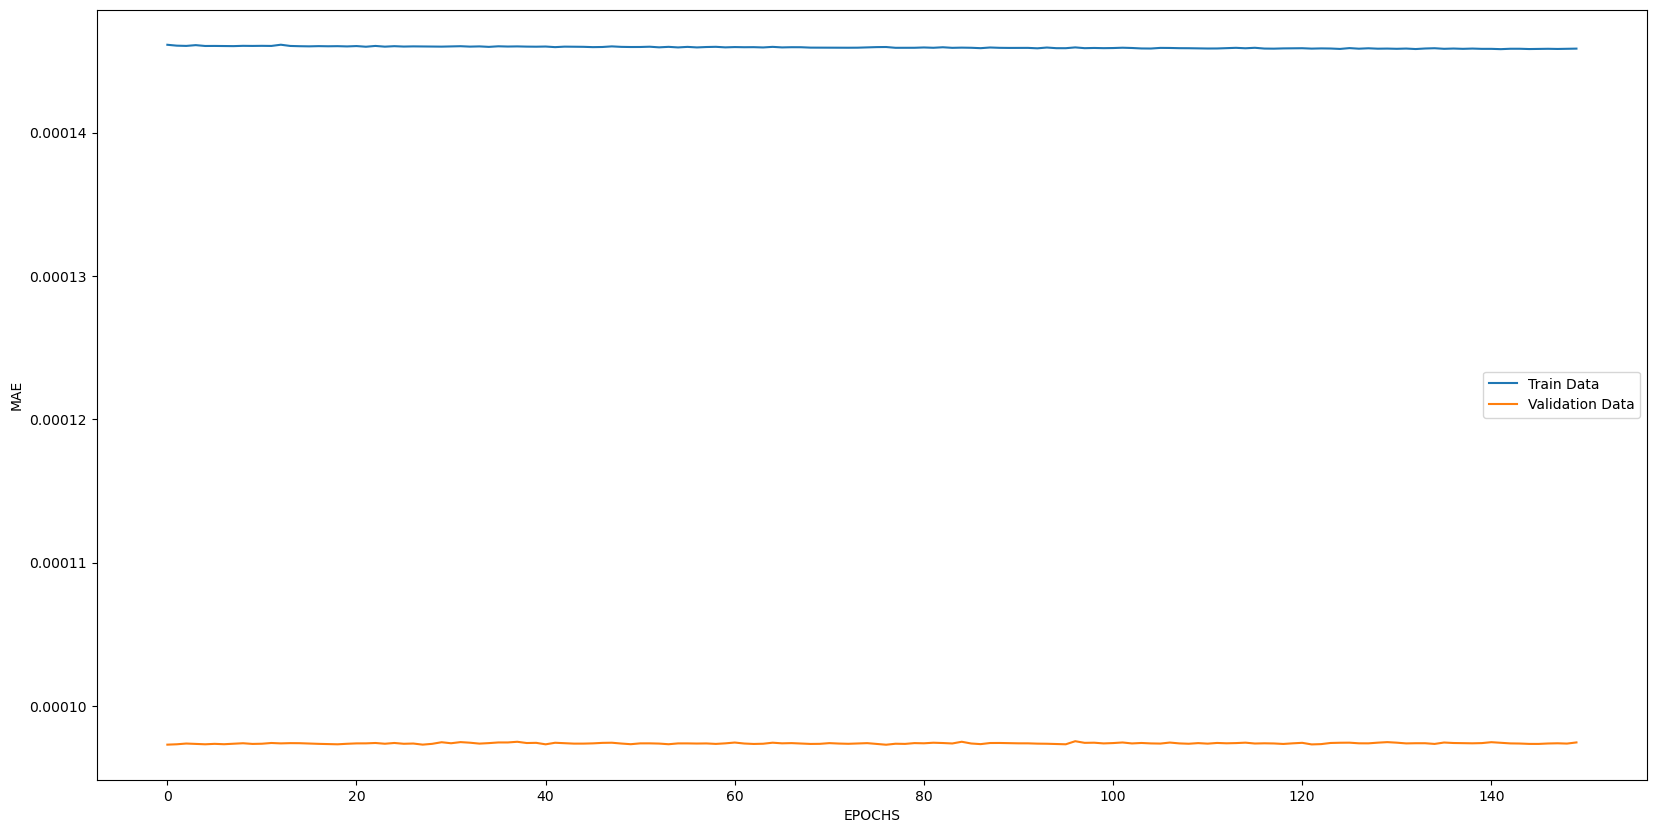

In [ ]:
lstm_difflog_model = createLstmModel(x_train_data,outputs=HORIZON)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)      

plotHistory(history)

## Bi-Index based on variation

In [ ]:
# Loads Data (includes disregarding dates only present in one dataframe)
df, df_other = load_multiple_index(end_date="2023-01-01")

# Cleans PSI-20 unwanted columns leaving only index and close value
global_data_p, size_train_data = selectData(type='univariate', datframe=df) 

# Cleans Foreign unwanted columns leaving only index and close value
global_data_f, size_train_data_f = selectData(type='univariate', datframe=df_other) 

#Renames the column of the close value of the foreign stock exchange
global_data_f.rename(columns = {'Close':'Other1'}, inplace = True)

# Joins the thow tables in one
global_data=global_data_p.join(global_data_f["Other1"])

#NECESSARY TO RECALCULATE
#size_train_data=len(global_data)-PERIODS_TO_PREDICT
global_data

Close       Other1
2018-05-04  5487.790039  5516.049805
2018-05-07  5527.759766  5531.419922
2018-05-08  5539.560059  5521.930176
2018-05-09  5550.390137  5534.629883
2018-05-10  5559.620117  5545.950195
...                 ...          ...
2022-12-23  5781.180176  6504.899902
2022-12-27  5756.979980  6550.660156
2022-12-28  5730.279785  6510.490234
2022-12-29  5797.759766  6573.470215
2022-12-30  5726.109863  6473.759766

[1187 rows x 2 columns]

In [ ]:
train_data,test_data = divideData(global_data, size_train_data)
scaled_train_data = diffLogData(train_data, numVariables=train_data.shape[1])

x_train_data = createBivTrainVector(scaled_train_data, scaled_train_data.shape[0])
y_train_data = createTargetVector(scaled_train_data[:,0])


In [ ]:

test_data=global_data[size_train_data-LOOK_BACK:].values

scaled_test_data=diffLogData(test_data, numVariables=2)

X_test = createBivTestVector(scaled_test_data)



In [ ]:
#EPOCHS=150
lstm_biv_model = createLstmModel(x_train_data)
#lstm_biv_model._init_set_name="Multi Index Variation Based"
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 60, 50)            10600     
                                                                 
 lstm_27 (LSTM)              (None, 25)                7600      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
108/108 [==============================] - 5s 28ms/step - loss: 1.5340e-04 - val_loss: 1.3000e-04
Epoch 2/150
108/108 [==============================] - 2s 22ms/step - loss: 1.4409e-04 - val_loss: 1.3036e-04
Epoch 3/150
108/108 [==============================] - 2s 22ms/step - loss: 1.4491e-04 -

## Linear Foreing VAR BASED

In [ ]:
df, df_other = load_multiple_index(end_date="2022-01-01")

In [ ]:
# Cleans unwanted columns leaving only index and close value
global_data, size_train_data = selectData(type='univariate', datframe=df_other) 

#Divides the data in train_data and test_data
train_data,test_data = divideData(global_data, size_train_data)


In [ ]:

#Scales the data
scaled_train_data=diffLogData(train_data)

#Create the vector for X_train_data
x_train_data = createTrainVector(scaled_train_data)

In [ ]:
# Cleans unwanted columns leaving only index and close value
global_data_p, size_train_data_p = selectData(type='univariate', datframe=df) 

#Divides the data in train_data and test_data
train_data_p,test_data_p = divideData(global_data_p, size_train_data_p)

#Scales the data
scaled_train_data_p=diffLogData(train_data_p)

#Create the vector for Y_train_data 
y_train_data = createTargetVector(scaled_train_data_p)

In [ ]:
#Preaparing the X_test matrix
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)

print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)



x data

[[-0.00497828  0.00648368  0.00363555 ...  0.00013365  0.00482072
  -0.00718829]
 [ 0.00648368  0.00363555  0.00267854 ...  0.00482072 -0.00718829
   0.0078941 ]
 [ 0.00363555  0.00267854  0.00520868 ... -0.00718829  0.0078941
   0.00894762]
 ...
 [ 0.00663148 -0.00869849  0.00395804 ... -0.00611767  0.00489708
   0.00803486]
 [-0.00869849  0.00395804  0.00600454 ...  0.00489708  0.00803486
  -0.00680313]
 [ 0.00395804  0.00600454 -0.01266763 ...  0.00803486 -0.00680313
   0.0067253 ]]

y data - target

[[-4.90662791e-03]
 [ 3.97211412e-03]
 [ 2.21830625e-03]
 [-1.41194092e-03]
 [ 3.10386791e-03]
 [-4.56940278e-03]
 [-3.15022678e-03]
 [ 3.14491895e-03]
 [ 3.46011338e-03]
 [ 9.35371388e-04]
 [ 1.07997931e-03]
 [-2.43990198e-03]
 [-1.63700040e-02]
 [-5.92481721e-03]
 [-1.60145887e-02]
 [ 1.28303073e-02]
 [-4.69483719e-03]
 [ 3.19558833e-03]
 [ 4.78527072e-03]
 [ 2.16292564e-03]
 [-4.77117199e-03]
 [ 1.17947364e-03]
 [ 4.35635611e-03]
 [-1.70582196e-03]
 [-2.91615206e-03]
 [-6.024

In [ ]:
lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_15 (LSTM)              (None, 25)                7600      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
82/82 [==============================] - 5s 30ms/step - loss: 1.6832e-04 - val_loss: 8.5626e-05
Epoch 2/150
82/82 [==============================] - 2s 22ms/step - loss: 1.6267e-04 - val_loss: 9.6078e-05
Epoch 3/150
82/82 [==============================] - 2s 22ms/step - loss: 1.5855e-04 - val_lo

## Using Week Days  BIV

#### For predicting the model use the Biv Predictions

In [ ]:
df = load_df_portugal()
#df = df.truncate(after=pd.Timestamp('2022-06-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='bivariate') 


In [ ]:
#crates a column with the day of the weeks


for i in range (0, len(global_data.index)) :
    global_data.Volume[i] = global_data.index[i].weekday()

In [ ]:
#One hot encodes days of the week
#global_data = global_data.join(pd.get_dummies(global_data.Volume,prefix="day")).drop(["Volume"], axis=1)

In [ ]:
global_data

Close  Volume
Date                                          
2018-04-06 00:00:00+01:00  5417.060059       4
2018-04-09 00:00:00+01:00  5448.990234       0
2018-04-10 00:00:00+01:00  5475.839844       1
2018-04-11 00:00:00+01:00  5465.709961       2
2018-04-12 00:00:00+01:00  5487.540039       3
...                                ...     ...
2023-01-26 00:00:00+00:00  5961.770020       3
2023-01-27 00:00:00+00:00  5936.729980       4
2023-01-30 00:00:00+00:00  5876.200195       0
2023-01-31 00:00:00+00:00  5886.339844       1
2023-02-01 00:00:00+00:00  5907.009766       2

[1228 rows x 2 columns]

In [ ]:
train_data,test_data = divideData(global_data, size_train_data)


In [ ]:

scaler=MinMaxScaler(feature_range=(0,1))
#scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler)



In [ ]:
x_train_data = createMultiTrainVector(scaled_train_data)


In [ ]:

y_train_data = createTargetVector(scaled_train_data[:,0])

In [ ]:
x_train_data

array([[[0.66142175, 4.        ],
        [0.67301952, 0.        ],
        [0.68277192, 1.        ],
        ...,
        [0.71128137, 3.        ],
        [0.70189929, 4.        ],
        [0.6873122 , 0.        ]],

       [[0.67301952, 0.        ],
        [0.68277192, 1.        ],
        [0.67909251, 2.        ],
        ...,
        [0.70189929, 4.        ],
        [0.6873122 , 0.        ],
        [0.68708714, 1.        ]],

       [[0.68277192, 1.        ],
        [0.67909251, 2.        ],
        [0.6870217 , 3.        ],
        ...,
        [0.6873122 , 0.        ],
        [0.68708714, 1.        ],
        [0.69708304, 2.        ]],

       ...,

       [[0.94719823, 4.        ],
        [0.91393797, 0.        ],
        [0.88062681, 1.        ],
        ...,
        [0.80715397, 1.        ],
        [0.79970062, 2.        ],
        [0.77815803, 3.        ]],

       [[0.91393797, 0.        ],
        [0.88062681, 1.        ],
        [0.87143007, 2.        ],
        .

In [ ]:

#test_data=global_data[size_train_data-LOOK_BACK:].drop(["Close"], axis=1).values

# For only the last day
#x_train_data[:,:-1,1]=-1

# For the CONTROL
x_train_data[:,:,1]=0
x_train_data

array([[[0.66142175, 0.        ],
        [0.67301952, 0.        ],
        [0.68277192, 0.        ],
        ...,
        [0.71128137, 0.        ],
        [0.70189929, 0.        ],
        [0.6873122 , 0.        ]],

       [[0.67301952, 0.        ],
        [0.68277192, 0.        ],
        [0.67909251, 0.        ],
        ...,
        [0.70189929, 0.        ],
        [0.6873122 , 0.        ],
        [0.68708714, 0.        ]],

       [[0.68277192, 0.        ],
        [0.67909251, 0.        ],
        [0.6870217 , 0.        ],
        ...,
        [0.6873122 , 0.        ],
        [0.68708714, 0.        ],
        [0.69708304, 0.        ]],

       ...,

       [[0.94719823, 0.        ],
        [0.91393797, 0.        ],
        [0.88062681, 0.        ],
        ...,
        [0.80715397, 0.        ],
        [0.79970062, 0.        ],
        [0.77815803, 0.        ]],

       [[0.91393797, 0.        ],
        [0.88062681, 0.        ],
        [0.87143007, 0.        ],
        .

In [ ]:
test_data=global_data[size_train_data-LOOK_BACK:].values


In [ ]:

scaled_test_data=scaleData(test_data,scaler)


In [ ]:

#The following line reverses the scaling of the weekday
#scaled_test_data[:,1]=test_data[:,1]
X_test = createMultiTrainVector(scaled_test_data)

#X_test[:,:-1,1]=0
X_test[:,:,1]=0
X_test


array([[[0.90397235, 0.        ],
        [0.86656508, 0.        ],
        [0.91446101, 0.        ],
        ...,
        [0.64655754, 0.        ],
        [0.64669244, 0.        ],
        [0.73706011, 0.        ]],

       [[0.86656508, 0.        ],
        [0.91446101, 0.        ],
        [0.91421371, 0.        ],
        ...,
        [0.64669244, 0.        ],
        [0.73706011, 0.        ],
        [0.76419202, 0.        ]],

       [[0.91446101, 0.        ],
        [0.91421371, 0.        ],
        [0.87179789, 0.        ],
        ...,
        [0.73706011, 0.        ],
        [0.76419202, 0.        ],
        [0.7746922 , 0.        ]],

       ...,

       [[0.61167703, 0.        ],
        [0.64594011, 0.        ],
        [0.65149864, 0.        ],
        ...,
        [0.7954003 , 0.        ],
        [0.86638522, 0.        ],
        [0.8382652 , 0.        ]],

       [[0.64594011, 0.        ],
        [0.65149864, 0.        ],
        [0.67366697, 0.        ],
        .

In [ ]:
EPOCHS = 150
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10600     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
112/112 [==============================] - 8s 44ms/step - loss: 0.0130 - val_loss: 0.0044
Epoch 2/150
112/112 [==============================] - 4s 35ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 3/150
112/112 [==============================] - 4s 35ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch

## Multi-Index based on ABS values

##### Model that estimates the variation of the PSI20 based on the closing values of the PSI20 historical value and the closing values with other world indexes

In [ ]:
dfs = load_multiple_index_new(end_date="2022-06-01")
global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])

for i in range (1, len(dfs)) :
    nameCol = 'Other' + str(i) 
    #Renames the column of the close value of the foreign stock exchange
    dfs[i].rename(columns = {'Close':nameCol}, inplace = True)
    #Joins in one Dataframe
    global_data=global_data.join(dfs[i][nameCol])
global_data

Open         High          Low        Close     Volume  \
2013-05-02  6229.669922  6279.600098  6202.830078  6235.089844          0   
2013-05-03  6222.720215  6257.470215  6188.990234  6253.540039          0   
2013-05-06  6249.609863  6299.709961  6239.319824  6299.709961          0   
2013-05-07  6318.540039  6384.779785  6318.540039  6356.560059          0   
2013-05-08  6315.240234  6361.680176  6244.700195  6266.330078          0   
...                 ...          ...          ...          ...        ...   
2022-05-26  6216.729980  6323.850098  6216.729980  6305.140137  174254200   
2022-05-27  6307.120117  6328.209961  6224.910156  6240.720215  155119500   
2022-05-30  6269.479980  6299.720215  6234.830078  6294.979980  113316700   
2022-05-31  6309.129883  6344.229980  6257.500000  6257.500000  171577800   
2022-06-01  6277.009766  6299.189941  6227.220215  6231.149902  147784800   

            Dividends  Stock Splits  
2013-05-02          0             0  
2013-05-03          0             0  
2013-05-06          0             0  
2013-05-07          0             0  
2013-05-08          0             0  
...               ...           ...  
2022-05-26          0             0  
2022-05-27          0             0  
2022-05-30          0             0  
2022-05-31          0             0  
2022-06-01          0             0  

[2113 rows x 7 columns]

In [ ]:
train_data,test_data = divideData(global_data, size_train_data)
scaled_train_data, scalers = scaleDataMulti(train_data)
scaled_train_data
x_train_data = createMultiTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])

scaled_test_data, testscaler = scaleDataMulti(test_data)
X_test = createMultiTrainVector(scaled_test_data)
X_test

In [ ]:
EPOCHS=5
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 40, 50)            11000     
                                                                 
 lstm_9 (LSTM)               (None, 25)                7600      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,626
Trainable params: 18,626
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
71/71 [==============================] - 3s 20ms/step - loss: 0.0199 - val_loss: 0.0292
Epoch 2/5
71/71 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.0238
Epoch 3/5
71/71 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0159
Epoch 4/5
71/71

## Multi index based on Variation (Diff log)

##### This models uses the difflogged data of the Psi20 and 3 (or more) world indexes 

In [ ]:
stocks = ["IBEX 35","NYSE","CAC 40","DAX","Ishares China ETF"]
dfs = load_multiple_index_new(features=stocks, end_date="2022-06-01")
global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])

#Adds the other markets to the global_data
for i in range (1, len(dfs)) :
    nameCol = 'Other' + str(i) 
    #Renames the column of the close value of the foreign stock exchange
    dfs[i].rename(columns = {'Close':nameCol}, inplace = True)
    #Joins in one Dataframe
    global_data=global_data.join(dfs[i][nameCol])
global_data

Close       Other1        Other2       Other3        Other4  \
2013-06-06  5793.189941  8216.691406   9178.410156  3814.280029   8098.810059   
2013-06-07  5850.069824  8266.590820   9260.480469  3872.590088   8254.679688   
2013-06-11  5766.899902  8089.291504   9358.000000  3810.560059   8222.459961   
2013-06-12  5765.209961  8123.791504   9255.480469  3793.699951   8143.270020   
2013-06-13  5731.839844  8071.691895   9189.429688  3797.979980   8095.390137   
...                 ...          ...           ...          ...           ...   
2022-05-24  6130.899902  8631.200195  15342.959961  6253.140137  13919.750000   
2022-05-25  6184.839844  8760.200195  15290.379883  6298.640137  14007.929688   
2022-05-26  6305.140137  8888.799805  15412.190430  6410.580078  14231.290039   
2022-05-27  6240.720215  8933.599609  15664.000000  6515.750000  14462.190430   
2022-06-01  6231.149902  8747.200195  15827.049805  6418.890137  14340.469727   

               Other5  
2013-06-06  27.731815  
2013-06-07  27.910528  
2013-06-11  27.467625  
2013-06-12  27.055803  
2013-06-13  26.877096  
...               ...  
2022-05-24  29.593906  
2022-05-25  28.462807  
2022-05-26  28.823587  
2022-05-27  29.954687  
2022-06-01  31.066290  

[1770 rows x 6 columns]

In [ ]:
train_data,test_data = divideData(global_data, size_train_data)

In [ ]:
scaled_train_data = diffLogData_new(train_data)

In [ ]:
x_train_data = createMultiTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])

In [ ]:
scaled_test_data=diffLogData_new(test_data)
X_test = createMultiTrainVector(scaled_test_data)
X_test


array([[[ 1.51957065e-03,  1.74508913e-02,  1.37175287e-02,
          1.81981582e-02,  1.35414303e-02,  2.90919510e-02],
        [ 9.78226513e-03,  8.50023650e-03,  1.23682520e-02,
          7.77009435e-03,  9.40889771e-03, -2.18698099e-03],
        [-4.22715601e-04,  1.22896238e-02,  7.69613543e-03,
          5.23423120e-03,  1.03886733e-02,  2.46011107e-03],
        ...,
        [ 5.56704279e-04,  3.36649181e-02,  2.09084292e-02,
          1.96787902e-02,  2.86848982e-02, -4.28878395e-03],
        [ 3.39347601e-03, -3.49220114e-02, -4.01943661e-02,
         -1.51149538e-02, -3.92190492e-02, -2.00775217e-03],
        [-8.87378544e-03,  1.60883226e-02,  1.57480791e-02,
          1.92147252e-02,  6.82753979e-03, -7.49277713e-03]],

       [[ 9.78226513e-03,  8.50023650e-03,  1.23682520e-02,
          7.77009435e-03,  9.40889771e-03, -2.18698099e-03],
        [-4.22715601e-04,  1.22896238e-02,  7.69613543e-03,
          5.23423120e-03,  1.03886733e-02,  2.46011107e-03],
        [ 8.99409

In [ ]:
#EPOCHS=150
lstm_biv_model = createLstmModel(x_train_data)
#lstm_biv_model._init_set_name="Multi Index Variation Based"
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            11400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 19,026
Trainable params: 19,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
168/168 [==============================] - 10s 37ms/step - loss: 2.0230e-04 - val_loss: 1.4212e-04
Epoch 2/200
168/168 [==============================] - 7s 39ms/step - loss: 1.9468e-04 - val_loss: 1.4844e-04
Epoch 3/200
168/168 [==============================] - 4s 24ms/step - loss: 1.9415e-04 - v

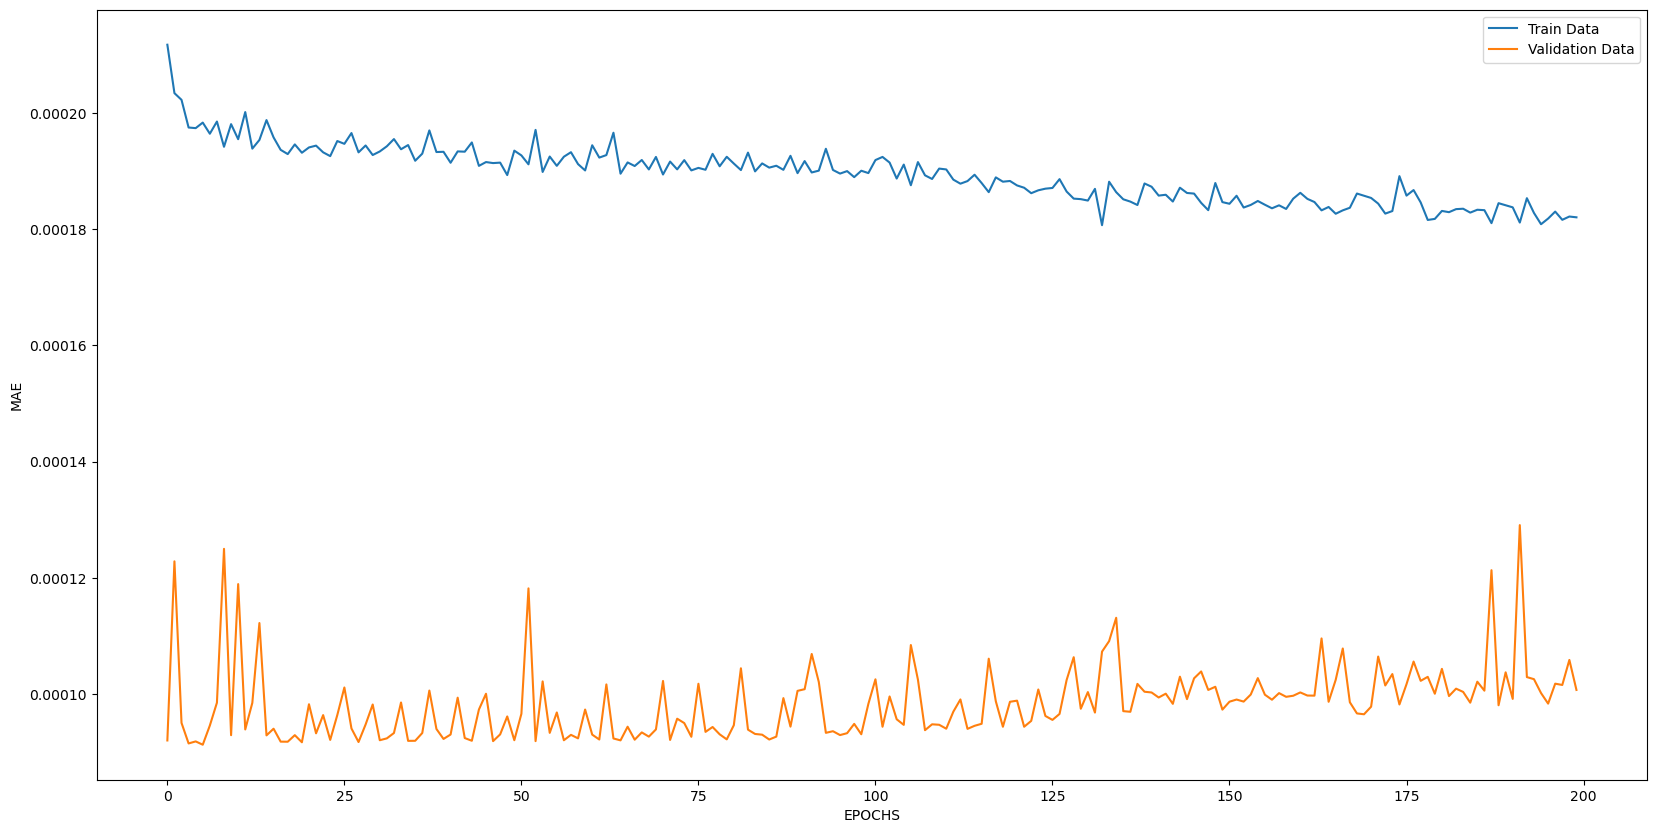

In [ ]:
plotHistory(history)

## Intraday Model with multi index

In [ ]:
#dfs = load_multiple_index_id_all(stocks,dates)
dfs= load_multiple_index_id(names, end=dates[0])


In [ ]:

global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])
global_data = add_Other_Markets_global_data(dfs, global_data)
global_data

Close       Other1       Other2        Other3
Datetime                                                                
2023-05-11 09:00:00  6109.370117  9182.400391  7388.490234           NaN
2023-05-11 09:01:00  6111.669922  9195.900391  7396.180176           NaN
2023-05-11 09:02:00  6111.259766          NaN  7400.930176           NaN
2023-05-11 09:03:00  6107.439941  9195.799805          NaN  15945.639648
2023-05-11 09:04:00  6106.410156  9195.700195  7406.669922  15940.490234
...                          ...          ...          ...           ...
2023-05-17 16:57:00  6089.959961  9201.299805  7399.240234  15938.950195
2023-05-17 16:58:00  6089.959961  9201.799805  7399.660156  15938.929688
2023-05-17 16:59:00  6089.959961  9202.200195  7399.509766  15940.049805
2023-05-17 17:00:00  6089.959961  9202.500000  7400.569824  15940.559570
2023-05-17 17:05:00  6089.959961  9203.599609  7397.160156  15936.849609

[2408 rows x 4 columns]

In [ ]:
import datetime
global_data = global_data[global_data.index.time <= datetime.time(16, 30)].dropna() 
global_data

Close       Other1       Other2        Other3
Datetime                                                                
2023-05-11 09:04:00  6106.410156  9195.700195  7406.669922  15940.490234
2023-05-11 09:05:00  6106.799805  9196.000000  7406.370117  15940.030273
2023-05-11 09:06:00  6107.250000  9203.200195  7410.290039  15950.570312
2023-05-11 09:07:00  6108.479980  9202.799805  7407.660156  15955.179688
2023-05-11 09:08:00  6108.830078  9202.099609  7408.560059  15951.040039
...                          ...          ...          ...           ...
2023-05-17 16:26:00  6091.959961  9206.500000  7403.750000  15942.480469
2023-05-17 16:27:00  6091.770020  9207.000000  7403.060059  15940.540039
2023-05-17 16:28:00  6090.799805  9207.400391  7402.500000  15940.429688
2023-05-17 16:29:00  6092.459961  9209.500000  7404.089844  15941.150391
2023-05-17 16:30:00  6092.680176  9210.900391  7404.609863  15943.660156

[2236 rows x 4 columns]

In [ ]:

size_train_data = global_data.shape[0] - PERIODS_TO_PREDICT
train_data,test_data = divideData(global_data, size_train_data)

In [ ]:
#For model based in difflog use this
#scaled_train_data = diffLogData_new(train_data)
#scaled_train_data
#For model based in ABS values use this:
scaled_train_data, scalers = scaleDataMulti(train_data)
scaled_train_data


array([[0.68444397, 0.48957736, 0.56160581, 0.78597685],
       [0.68717088, 0.49147126, 0.55928981, 0.78402712],
       [0.69032152, 0.53695581, 0.58957124, 0.82870531],
       ...,
       [0.61060898, 0.59696852, 0.58470539, 0.92102562],
       [0.6037507 , 0.59823318, 0.58825859, 0.91861226],
       [0.61026042, 0.58054029, 0.58200088, 0.90869389]])

In [ ]:

x_train_data = createMultiTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
x_train_data

array([[[0.68444397, 0.48957736, 0.56160581, 0.78597685],
        [0.68717088, 0.49147126, 0.55928981, 0.78402712],
        [0.69032152, 0.53695581, 0.58957124, 0.82870531],
        ...,
        [0.66722822, 0.60455031, 0.74693055, 0.82870531],
        [0.66799709, 0.58685741, 0.7396695 , 0.8178928 ],
        [0.67541579, 0.559695  , 0.707917  , 0.77648072]],

       [[0.68717088, 0.49147126, 0.55928981, 0.78402712],
        [0.69032152, 0.53695581, 0.58957124, 0.82870531],
        [0.6989294 , 0.53442649, 0.56925537, 0.848244  ],
        ...,
        [0.66799709, 0.58685741, 0.7396695 , 0.8178928 ],
        [0.67541579, 0.559695  , 0.707917  , 0.77648072],
        [0.67814269, 0.5445376 , 0.71170407, 0.761984  ]],

       [[0.69032152, 0.53695581, 0.58957124, 0.82870531],
        [0.6989294 , 0.53442649, 0.56925537, 0.848244  ],
        [0.70137952, 0.53000327, 0.57620713, 0.83069644],
        ...,
        [0.67541579, 0.559695  , 0.707917  , 0.77648072],
        [0.67814269, 0.544537

In [ ]:

#For model based in difflog use this
#scaled_test_data = diffLogData_new(test_data)

#For model based in ABS values use this:
scaled_test_data, testscaler = scaleDataMulti(test_data)

In [ ]:
X_test = createMultiTrainVector(scaled_test_data)
X_test

array([[[0.47182484, 0.12503633, 0.21642632, 0.35013355],
        [0.4484183 , 0.13689473, 0.25518251, 0.35463393],
        [0.46080999, 0.10120328, 0.27733213, 0.3741173 ],
        ...,
        [0.64305863, 0.67860257, 0.40378549, 0.6509824 ],
        [0.57565988, 0.6905191 , 0.42501127, 0.64031686],
        [0.63963329, 0.52380399, 0.38762956, 0.59648385]],

       [[0.4484183 , 0.13689473, 0.25518251, 0.35463393],
        [0.46080999, 0.10120328, 0.27733213, 0.3741173 ],
        [0.5       , 0.09527408, 0.27595764, 0.38516703],
        ...,
        [0.57565988, 0.6905191 , 0.42501127, 0.64031686],
        [0.63963329, 0.52380399, 0.38762956, 0.59648385],
        [0.74968097, 0.54170784, 0.37009914, 0.62813289]],

       [[0.46080999, 0.10120328, 0.27733213, 0.3741173 ],
        [0.5       , 0.09527408, 0.27595764, 0.38516703],
        [0.46698905, 0.13689473, 0.36962596, 0.42806703],
        ...,
        [0.63963329, 0.52380399, 0.38762956, 0.59648385],
        [0.74968097, 0.541707

In [ ]:
lstm_biv_model = createLstmModel(x_train_data)
lstm_biv_model._name="Intraday_end_date_" +  dates[0]
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data, epoch=5)

Model: "Intraday_end_date_18-05-2023"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            11000     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,626
Trainable params: 18,626
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
213/213 [==============================] - 12s 38ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 2/5
213/213 [==============================] - 7s 34ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 3/5
213/213 [==============================] - 7s 34ms/step - loss: 0.0012 - val_loss:

# == Models Go == 

In [70]:
def prepareIntradayModelGo(date, drop=0) :
    dfs= load_multiple_index_id(names, date)
    global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])
    global_data = add_Other_Markets_global_data(dfs, global_data)   

    import datetime
    
    global_data = global_data[global_data.index.time <= datetime.time(16, 30)].dropna() 
    

    global_data.drop(global_data.tail(drop).index,
        inplace = True)

    size_train_data = global_data.shape[0] - PERIODS_TO_PREDICT
    train_data,test_data = divideData(global_data, size_train_data)

    #scaled_train_data = diffLogData_new(train_data)
    scaled_train_data, scalers = scaleDataMulti(train_data)
    
    x_train_data = createMultiTrainVector(scaled_train_data)
    y_train_data = createTargetVector(scaled_train_data[:,0])

    scaled_test_data, testScaler = scaleDataMulti(test_data)
    X_test = createMultiTrainVector(scaled_test_data)

    return global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test


In [56]:

def trainModelsGo (numberOfGos,date, epochs=EPOCHS) :     
    for testNumber in range(1, numberOfGos+1) :
        lstm_biv_model = createLstmModel(x_train_data)
        lstm_biv_model._name="Intraday_end_date_" +  date + "_Go_number_" + str(testNumber)
        print(lstm_biv_model.summary())
        history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data,epochs)
        filename = '.\models_go\model' + date +'_'+str(testNumber)+'.h5'
        lstm_biv_model.save(filename)  # creates a HDF5 file 'my_model.h5'

In [ ]:
global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test = prepareIntradayModel(dates[0])


In [ ]:
trainModelsGo(30, dates[1], epochs=150)

Model: "Intraday_end_date_25-05-2023_Go_number_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            11000     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,626
Trainable params: 18,626
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
213/213 [==============================] - 8s 27ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 2/150
213/213 [==============================] - 5s 23ms/step - loss: 6.2289e-04 - val_loss: 0.0028
Epoch 3/150
213/213 [==============================] - 5s 23ms/step - los

### Intra-day Single Stock

In [ ]:
def prepareIntradayModel(date) :
    dfs= load_multiple_index_id(names, date)
    global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])
    global_data = add_Other_Markets_global_data(dfs, global_data)   

    import datetime
    global_data = global_data[global_data.index.time <= datetime.time(16, 30)].dropna() 
    
    size_train_data = global_data.shape[0] - PERIODS_TO_PREDICT
    train_data,test_data = divideData(global_data, size_train_data)

    #scaled_train_data = diffLogData_new(train_data)
    scaled_train_data, scalers = scaleDataMulti(train_data)
    
    #This line is necessary for the single stock model
    scaled_train_data = np.expand_dims(scaled_train_data, axis=1)
    
    x_train_data = createTrainVector(createTrainVector(scaled_train_data))
    y_train_data = createTargetVector(scaled_train_data[:,0])

    scaled_test_data, testScaler = scaleDataMulti(test_data)
    #This line is necessary for the single stock model
    scaled_test_data = np.expand_dims(scaled_test_data, axis=1)

    X_test = createMultiTrainVector(scaled_test_data)

    return global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test

In [ ]:
names = ["PSI"]
date = dates[0]

global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test = prepareIntradayModel(date)


# == PREDICTIONS ==

##### Prediction Benchmark

In [ ]:

#def generateBenchmark(data=global_data,size=size_train_data): #%% Day - Before Prediction function
def generateBenchmark(data,size=size_train_data): #%% Day - Before Prediction function
        d_before_price = data.iloc[size-1:].copy()
        day_before_price_copy = d_before_price.copy()

 
        for i in range(1,d_before_price.size):
                d_before_price['Close'][i] = day_before_price_copy['Close'][i-1].copy()

        return d_before_price.iloc[1:]

##### Evaluate Predictions:

In [ ]:
def testPredictionsScore(data=test_data, type=""):
    
    if (type=="categorical"):
        data = data[LOOK_BACK+1:,0]
    else:
        data = data[LOOK_BACK:,0]
 

    print('==================================')
    testScore = np.sqrt(mean_squared_error(data, predicted_stock_price))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

In [ ]:
## TO check if necessary (only for fopreign becaus of lookback)
def testPredictionsScore_f(actual=test_data, type="", predicted=""):
    
    print('==================================')
    testScore = np.sqrt(mean_squared_error(actual, predicted))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

In [ ]:
def testDayBeforeScore(actual, predicted):
    
    #testScore = np.sqrt(mean_squared_error(global_data.iloc[size_train_data:], day_before_price['Close']))
    testScore = np.sqrt(mean_squared_error(actual, predicted))
    #predicted.to_numpy()

    print('==================================')
    print('Test Score Day before: %.2f RMSE' % (testScore))
    print('==================================')

#### Plotting the results

In [ ]:
def fillDataForPlotting (history,predicted,benchmark): 
    #Setting Vectors for plotting
    tr_data = history.iloc[:size_train_data]
    tt_data = history.iloc[size_train_data:]
    tt_data = tt_data.assign(Predictions=predicted)
    if (not benchmark.empty):
        tt_data = tt_data.assign(Day_Before=benchmark)
    return tr_data,tt_data

In [ ]:
def plotAllHistory (train_data,test_data,title): 
    #Plotting all history
    plt.plot(train_data["Close"], label='Historical Data')
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    #plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - All history", fontsize=25)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Index',fontsize=15)
    plt.legend(fontsize=15)
    plt.show()  

In [ ]:
def plotPredictedPeriod (test_data, title,printBenchmark):
    #Plot predicted Period
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    if printBenchmark:
        plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - Predicted Period", fontsize=30)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Closing Value',fontsize=25)
    plt.legend(fontsize=20, loc='upper left')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()  


In [ ]:
def plotResults(history=global_data, predicted="",benchmark=pd.DataFrame(), title=""):
    tr_data,tt_data = fillDataForPlotting(history,predicted,benchmark);
    plotAllHistory(tr_data,tt_data, title);
    #Only prints benchmark if not empty
    plotPredictedPeriod(tt_data,title,not benchmark.empty);


### Running Predictions

##### Linear Model

In [ ]:
#Linear model
day_before_price = generateBenchmark(global_data,size_train_data)
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1876\324933310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_before_price['Close'][i] = day_before_price_copy['Close'][i-1].copy()


IndexError: index 51 is out of bounds for axis 0 with size 51

In [ ]:
testPredictionsScore(test_data, predicted_stock_price)


Test Score: 84.18 RMSE


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1876\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [ ]:

testDayBeforeScore(global_data.iloc[size_train_data:], day_before_price)


Test Score Day before: 42.33 RMSE


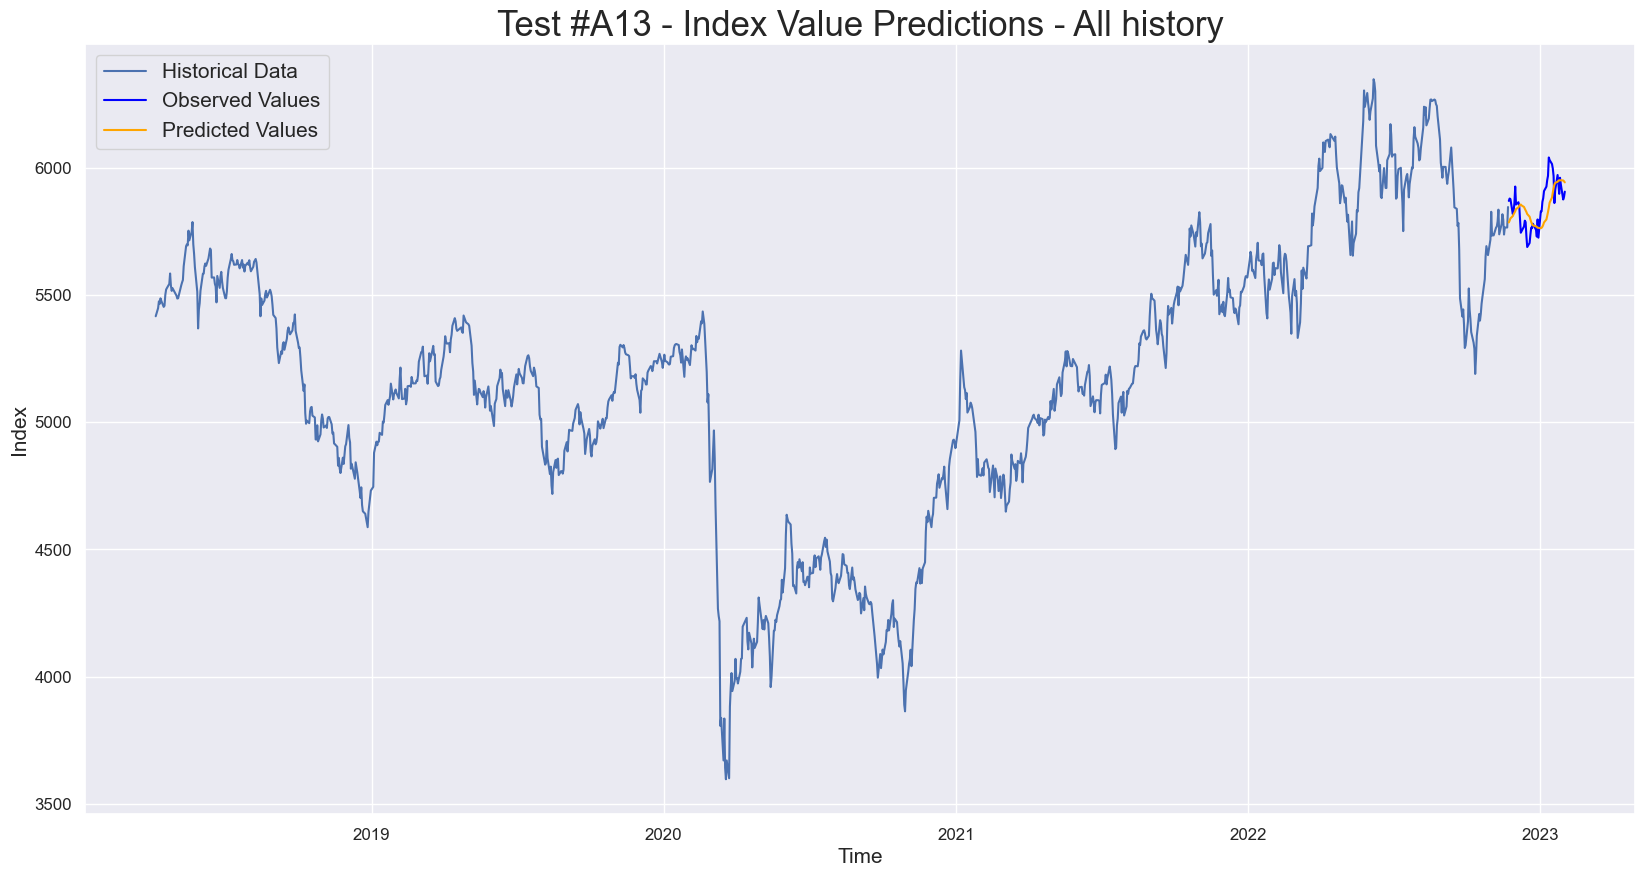

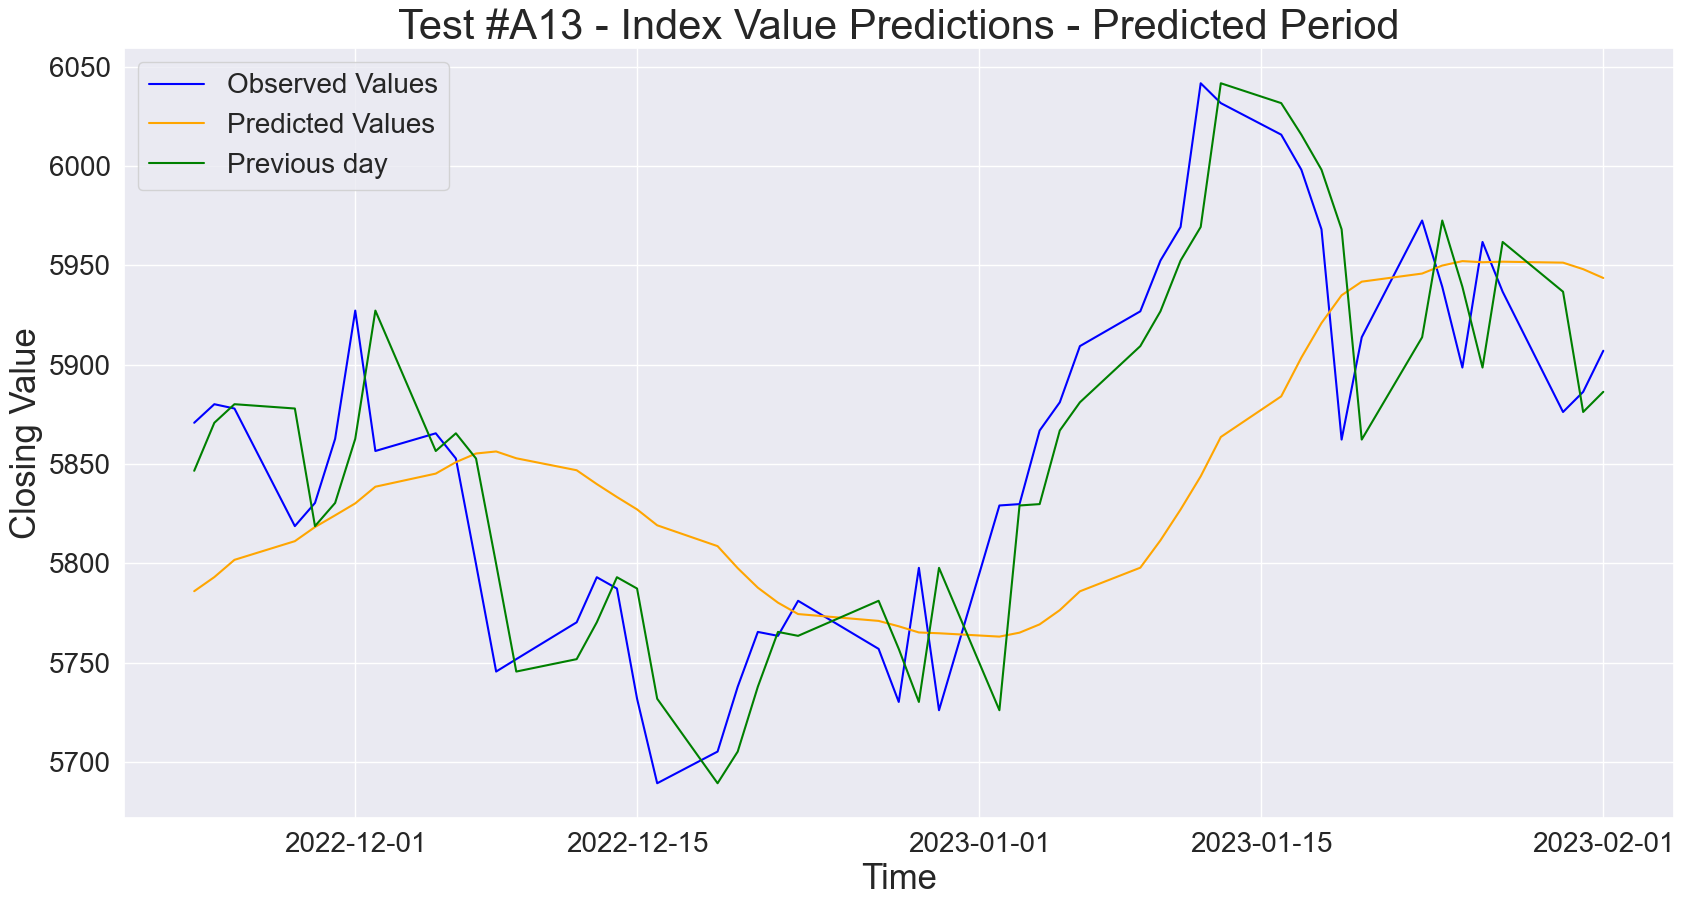

In [ ]:
plotResults(predicted=predicted_stock_price,benchmark=day_before_price, title="Test #A13 - Index Value Predictions")

##### Bivariate Model


In [ ]:
#Bivariate model
predicted_stock_price=lstm_biv_model.predict(X_test)

predicted_stock_price=scaler.inverse_transform(predicted_stock_price)
#predicted_stock_price=testscaler[0].inverse_transform(predicted_stock_price)

np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], predicted_stock_price))
#np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], predicted_stock_price))



2/2 [==============================] - 1s 13ms/step


64.5965729455814

In [ ]:
testPredictionsScore()

# For bivariate use data=global_data.drop(['Other1']
day_before_price = generateBenchmark(data=global_data[['Close']])

#testDayBeforeScore(predicted=day_before_price, actual=test_data[LOOK_BACK:,0])
testDayBeforeScore(predicted=day_before_price, actual=global_data.iloc[-PERIODS_TO_PREDICT:,0])

Test Score: 64.60 RMSE
Test Score Day before: 42.33 RMSE


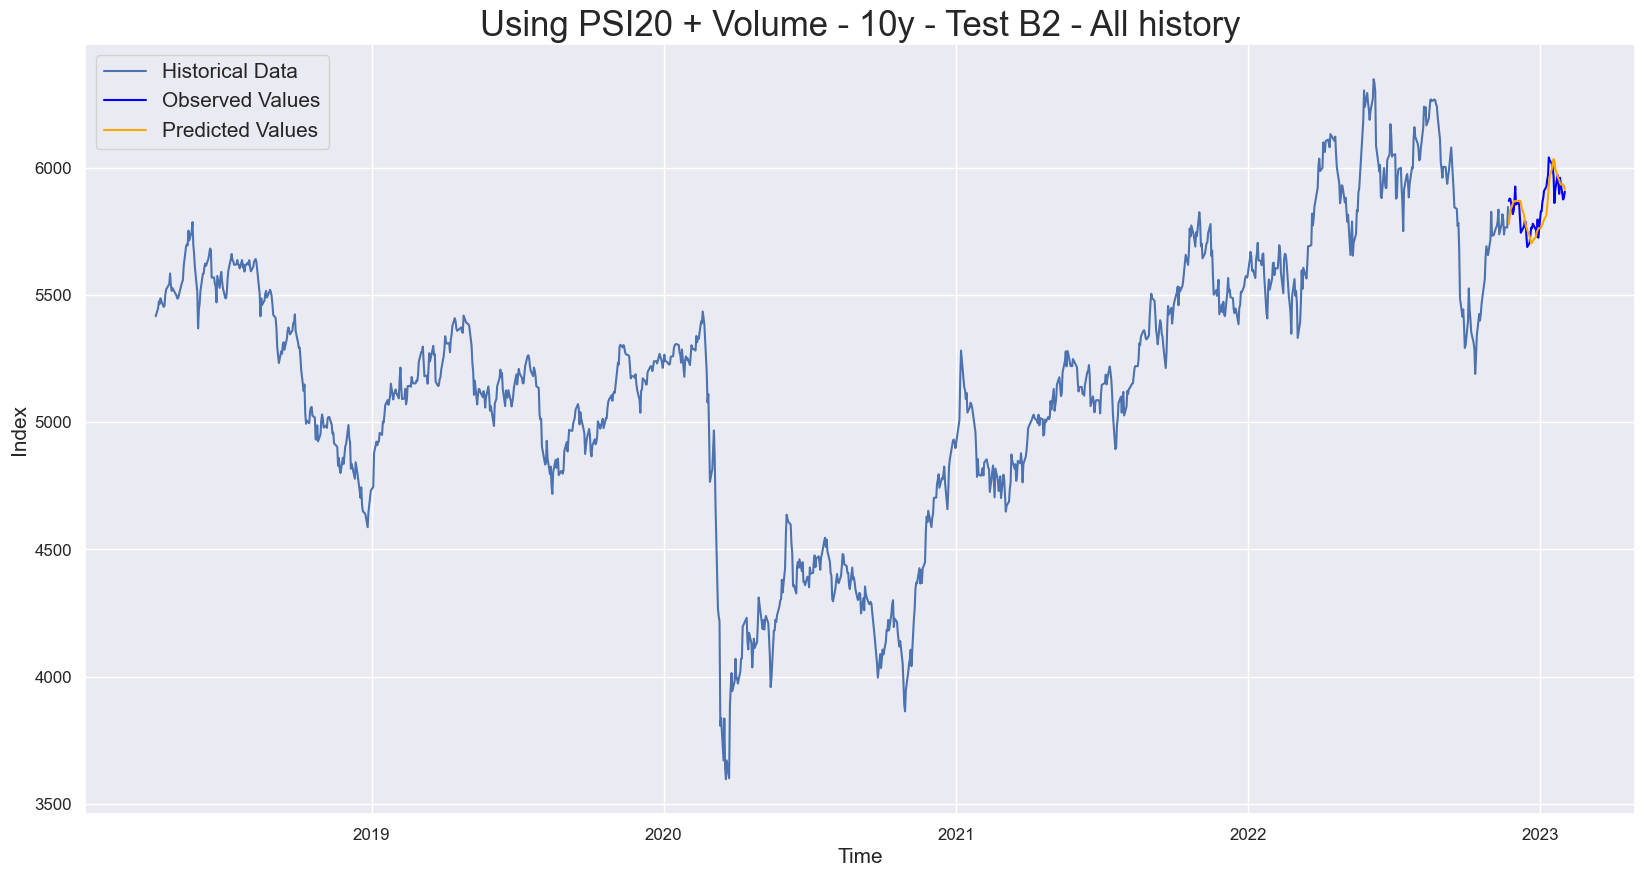

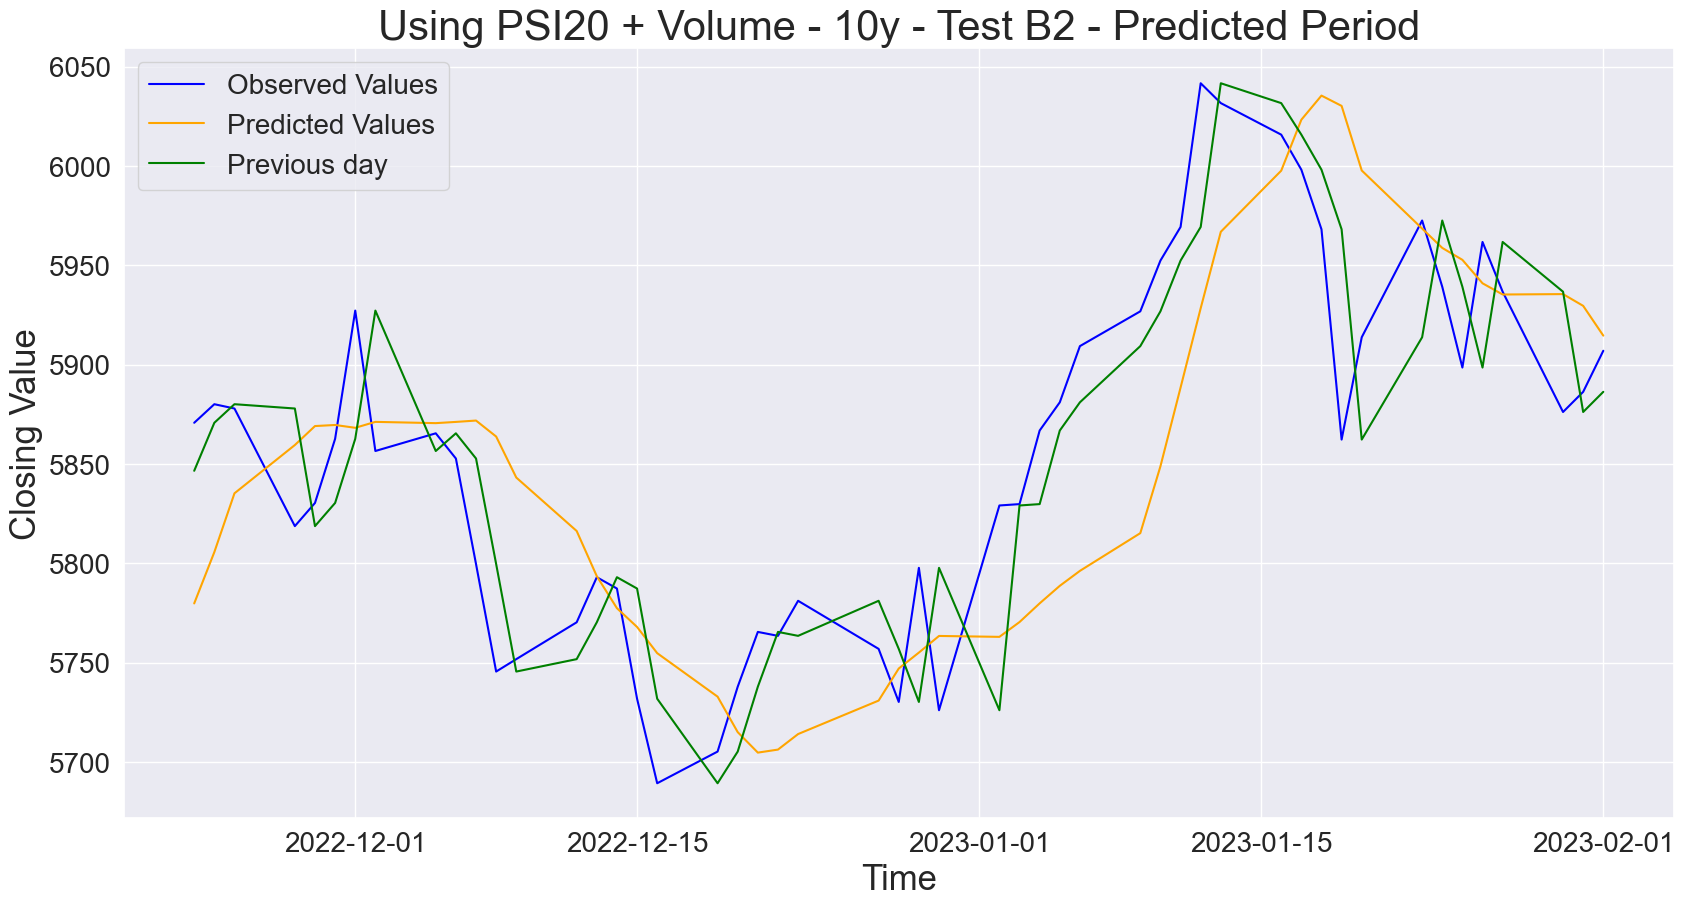

In [ ]:
plotResults(history=global_data[['Close']],predicted=predicted_stock_price,benchmark=day_before_price, 
            title="Using PSI20 + Volume - 10y - Test B2")

In [ ]:
# For bivariate use data=global_data.drop(['Volume']
plotResults(history=global_data.drop(['Other1'], axis=1),predicted=predicted_stock_price,benchmark=day_before_price, 
            title="Using PSI 20 and " + NAME_FOREIGN + " 5y - Test E3")



KeyError: "['Other1'] not found in axis"

##### DiffLog Model


In [ ]:
#Difflog Model
diff_logged_predictions=lstm_difflog_model.predict(X_test)

In [ ]:
#This is the correct one
predicted_stock_price = undiffLogData2(test_data[LOOK_BACK:], diff_logged_predictions);


In [ ]:
testPredictionsScore(test_data, predicted_stock_price)
#testDayBeforeScore()

Test Score: 48.25 RMSE


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_46616\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [ ]:
day_before_price = generateBenchmark(global_data,size_train_data)
testDayBeforeScore(global_data.iloc[size_train_data:], day_before_price)

Test Score Day before: 51.03 RMSE


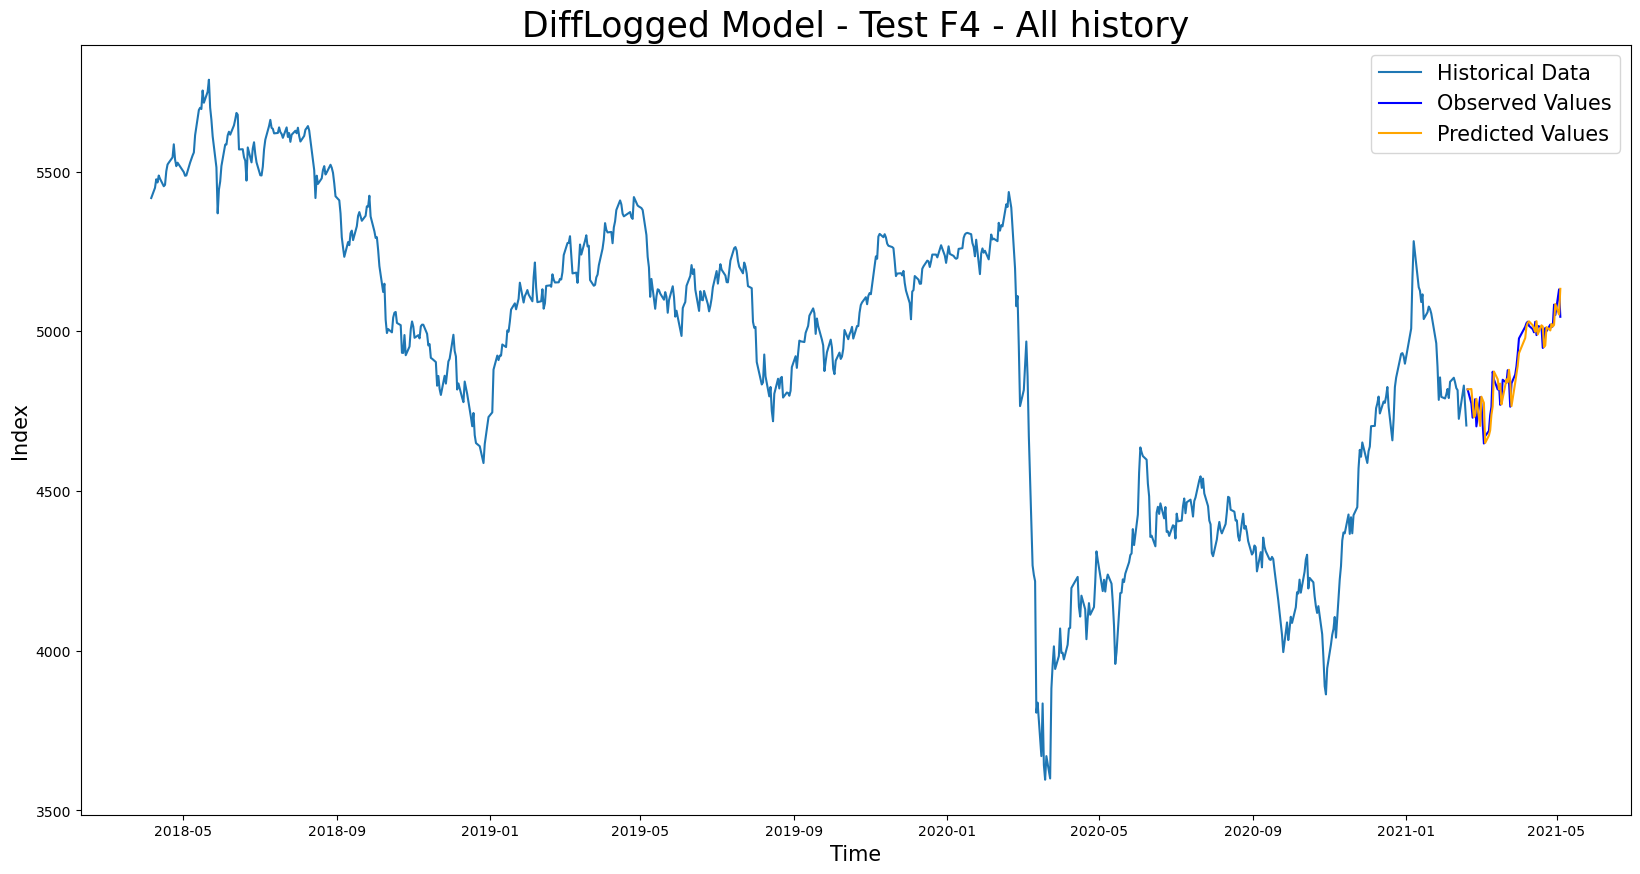

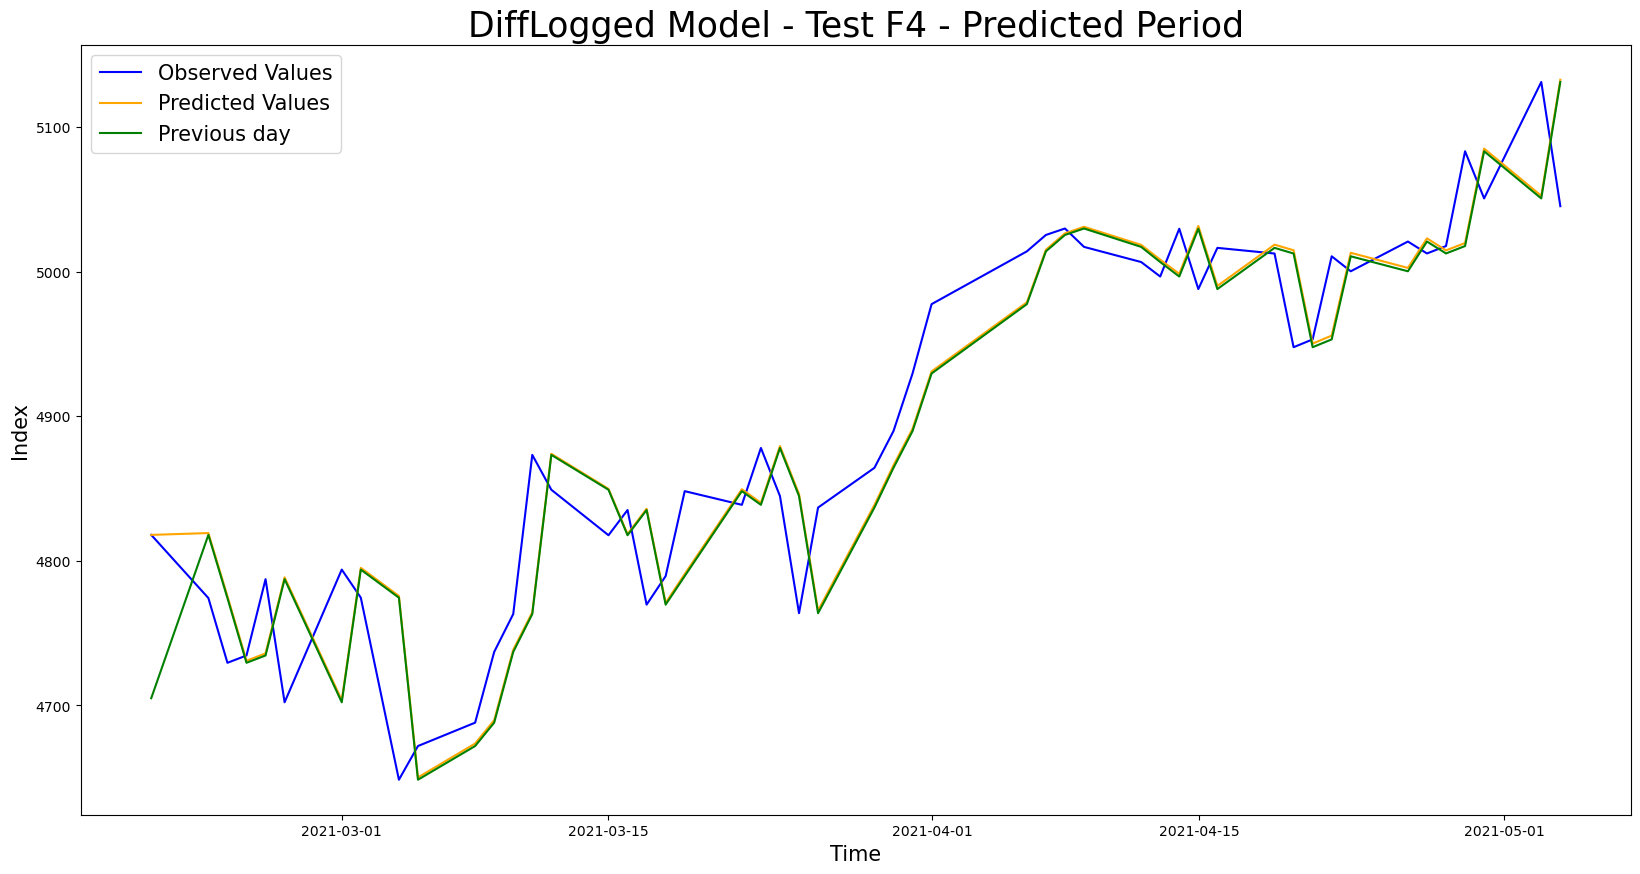

In [ ]:
plotResults(history=global_data, predicted=predicted_stock_price,benchmark=day_before_price, title="DiffLogged Model - Test F4")

##### Classification Model

In [ ]:
#Category Model
predicted_stock_cat=lstm_class_model.predict(X_test)
print("Test C4")
predicted_stock_cat

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step
Test C4


array([[0.2963217 , 0.4404843 , 0.263194  ],
       [0.29984742, 0.44782916, 0.25232342],
       [0.29946584, 0.45300466, 0.24752955],
       [0.3030627 , 0.45212263, 0.24481463],
       [0.3719363 , 0.36593065, 0.26213306],
       [0.40373418, 0.29470468, 0.3015611 ],
       [0.40331715, 0.26104742, 0.33563545],
       [0.37501842, 0.2623541 , 0.36262754],
       [0.2955931 , 0.40085214, 0.3035547 ],
       [0.28457722, 0.42208582, 0.293337  ],
       [0.30066705, 0.41654572, 0.2827873 ],
       [0.3053262 , 0.40073556, 0.29393822],
       [0.3029196 , 0.38653582, 0.31054452],
       [0.29080692, 0.3689407 , 0.3402523 ],
       [0.28722164, 0.376974  , 0.33580428],
       [0.279835  , 0.3803896 , 0.33977544],
       [0.27821502, 0.38136944, 0.34041545],
       [0.28186426, 0.38250685, 0.33562896],
       [0.28220862, 0.3856775 , 0.3321138 ],
       [0.27867174, 0.39145237, 0.32987595],
       [0.2763742 , 0.40038317, 0.32324266],
       [0.28247157, 0.41270933, 0.30481917],
       [0.

In [ ]:
y_train_data[:,0].sum()
y_train_data[:,1].sum()

379.0

In [ ]:

predictions=np.argmax(predicted_stock_cat, axis=1)
observations =  np.argmax(Y_test, axis=1)

In [ ]:
#print(predicted_stock_cat)
from sklearn.metrics import accuracy_score

print("Predicions:")
print(predictions)

print("Total of " + str(len(predictions)) + " values.\n")

print("Observed:")
print(observations)
print(str(len(observations)) + " values.\n")

print("Accuracy:" + str(accuracy_score(observations, predictions)*100) +"%.")

##testPredictionsScore("categorical")




Predicions:
[1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Total of 49 values.

Observed:
[1 1 0 1 2 2 0 1 1 0 0 1 2 2 1 0 0 1 2 2 1 2 0 0 2 0 2 1 2 1 2 1 2 1 2 1 1
 0 0 0 2 2 0 0 2 0 0 1 2]
49 values.

Accuracy:32.6530612244898%.


In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(observations, predictions)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix




array([[ 1, 15,  0],
       [ 1, 15,  0],
       [ 2, 15,  0]], dtype=int64)

<AxesSubplot: title={'center': '"C4" Heatmap'}>

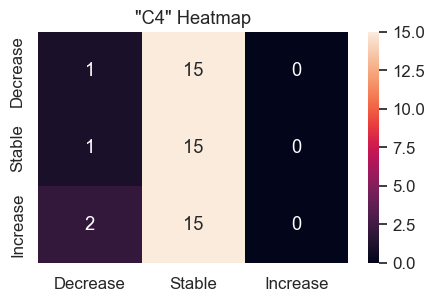

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Stable","Increase"],
                  columns = ["Decrease", "Stable","Increase"])
plt.figure(figsize = (5,3))
plt.title('"C4" Heatmap')
sn.heatmap(df_cm,annot=True)

In [ ]:
#PARA ELIMINAR
#Making a list with the actual index value variations.

# Selecting the 50 last values and logging
test_data_log = np.log(test_data[90:])
test_data_diff = test_data_log[0:49,]

# iterating the log array and returing the diff to the test_data_diff array
for i in range (len(test_data_log)-1) :
    test_data_diff[i] = test_data_log[i+1] - test_data_log[i]

observed = test_data_diff.T[0]

#test_obs = createTargetClassVector(test_data, numCat=3)

print(observed)





[]


#### Linear with foreign data

In [ ]:
#gets the values from previous day as a benchmark
day_before_price = generateBenchmark(global_data_p,size_train_data)

# the model makes its predictiona (scaled data)
predicted_stock_price=lstm_model.predict(X_test)


2/2 [==============================] - 1s 13ms/step


In [ ]:

#We (un)scale the data back.
pred=scaler_p.inverse_transform(predicted_stock_price)

In [ ]:
testPredictionsScore_f(actual=test_data_p, predicted=pred)
testDayBeforeScore(test_data_p,day_before_price)

Test Score: 1651.22 RMSE
Test Score Day before: 75.02 RMSE


In [ ]:
plt.plot(predicted_stock_price, label='Predicted')
plt.plot(scaled_train_data_p, label='actual')
plt.plot(scaled_train_data, label='NYSE')
plt.xlabel("Years", fontsize=15)
plt.ylabel("Stock index value")
plt.title("The Psi-20 and "+NAME_FOREIGN, fontsize=20)
plt.legend(fontsize=15)
plt.show()

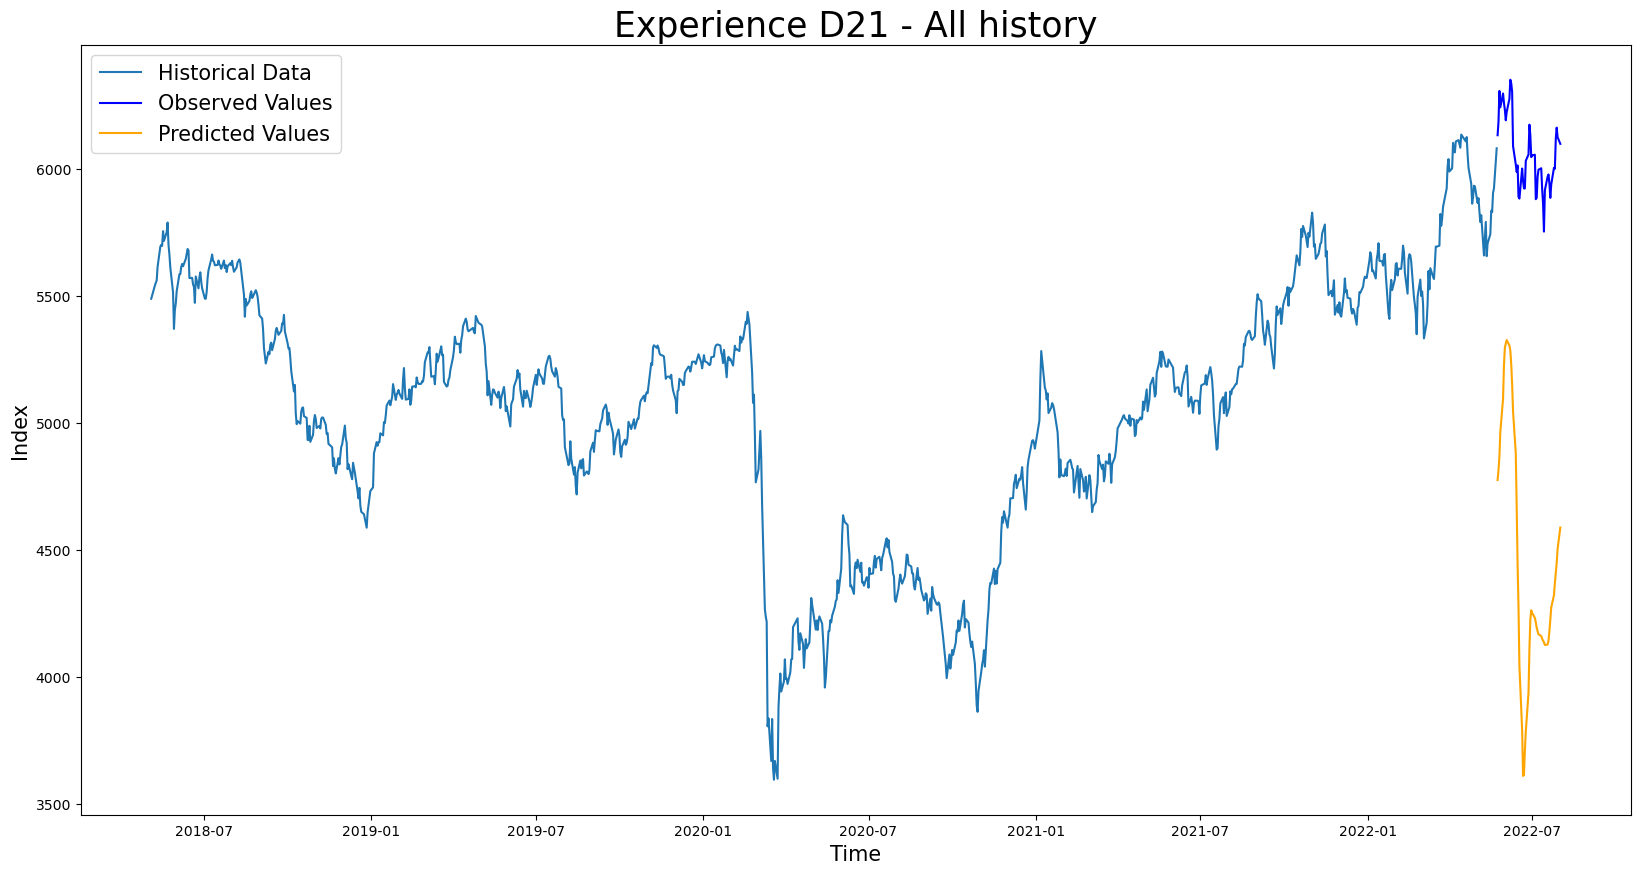

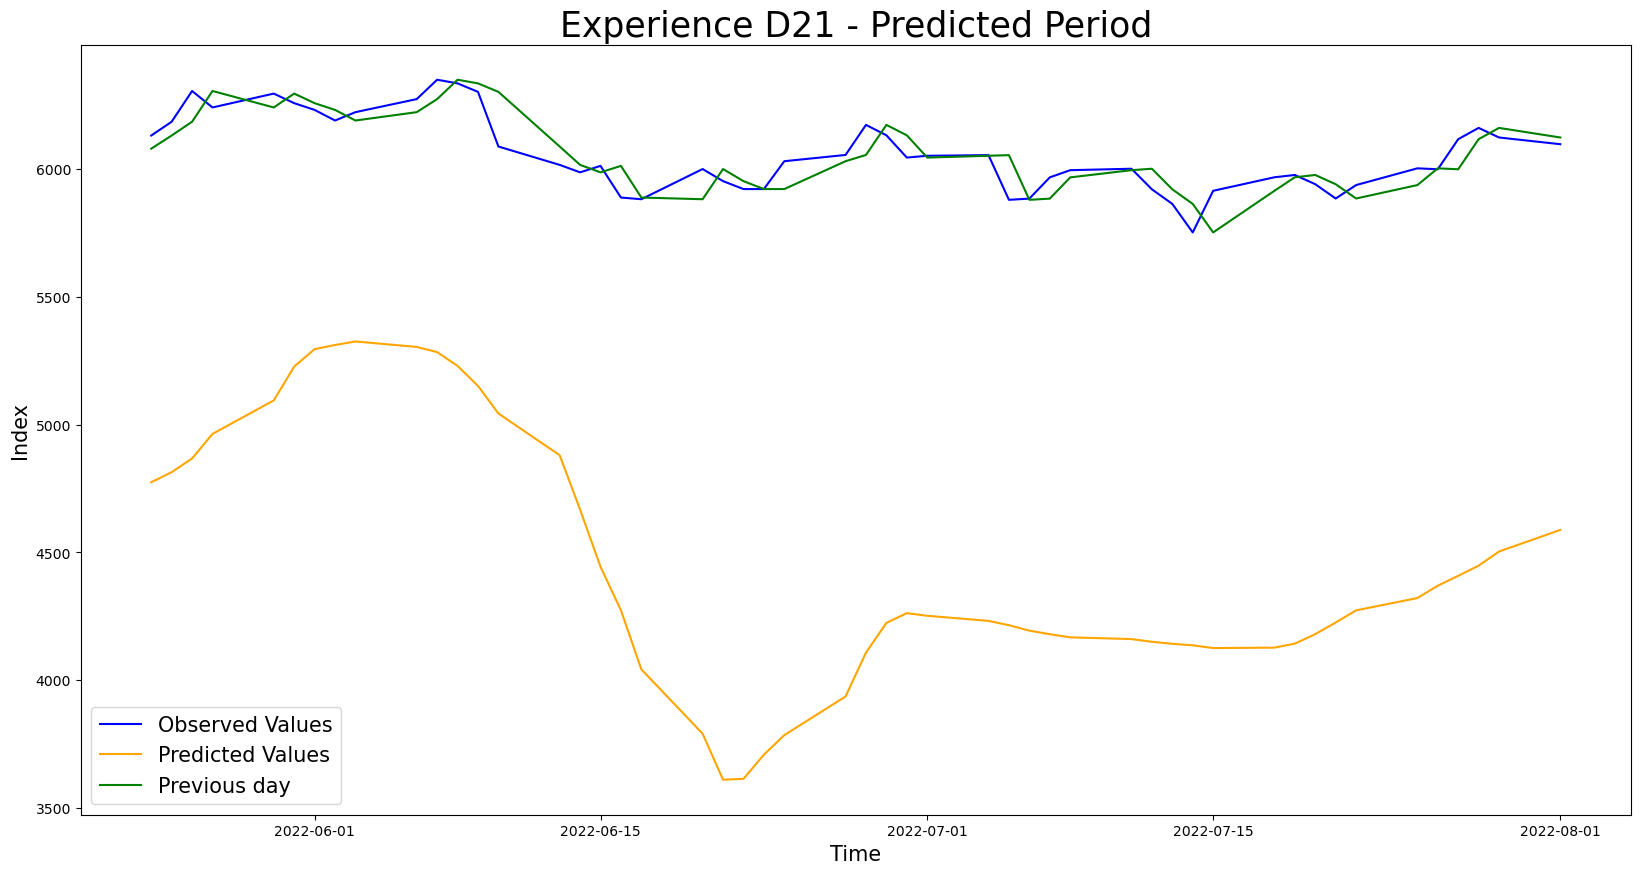

In [ ]:
plotResults(history=global_data_p, predicted=pred,benchmark=day_before_price,title="Experience D21")



#### Multi Predictor

In [ ]:
#Difflog Model
diff_logged_predictions=lstm_difflog_model.predict(X_test)

1/1 [==============================] - 0s 469ms/step


In [ ]:
predicted_stock_price= undiffLogData(diff_logged_predictions,test_data[LOOK_BACK])
predicted_stock_price=np.expand_dims(predicted_stock_price, axis=1)  

In [ ]:
day_before_price = generateBenchmark(global_data,size_train_data)[:-1]


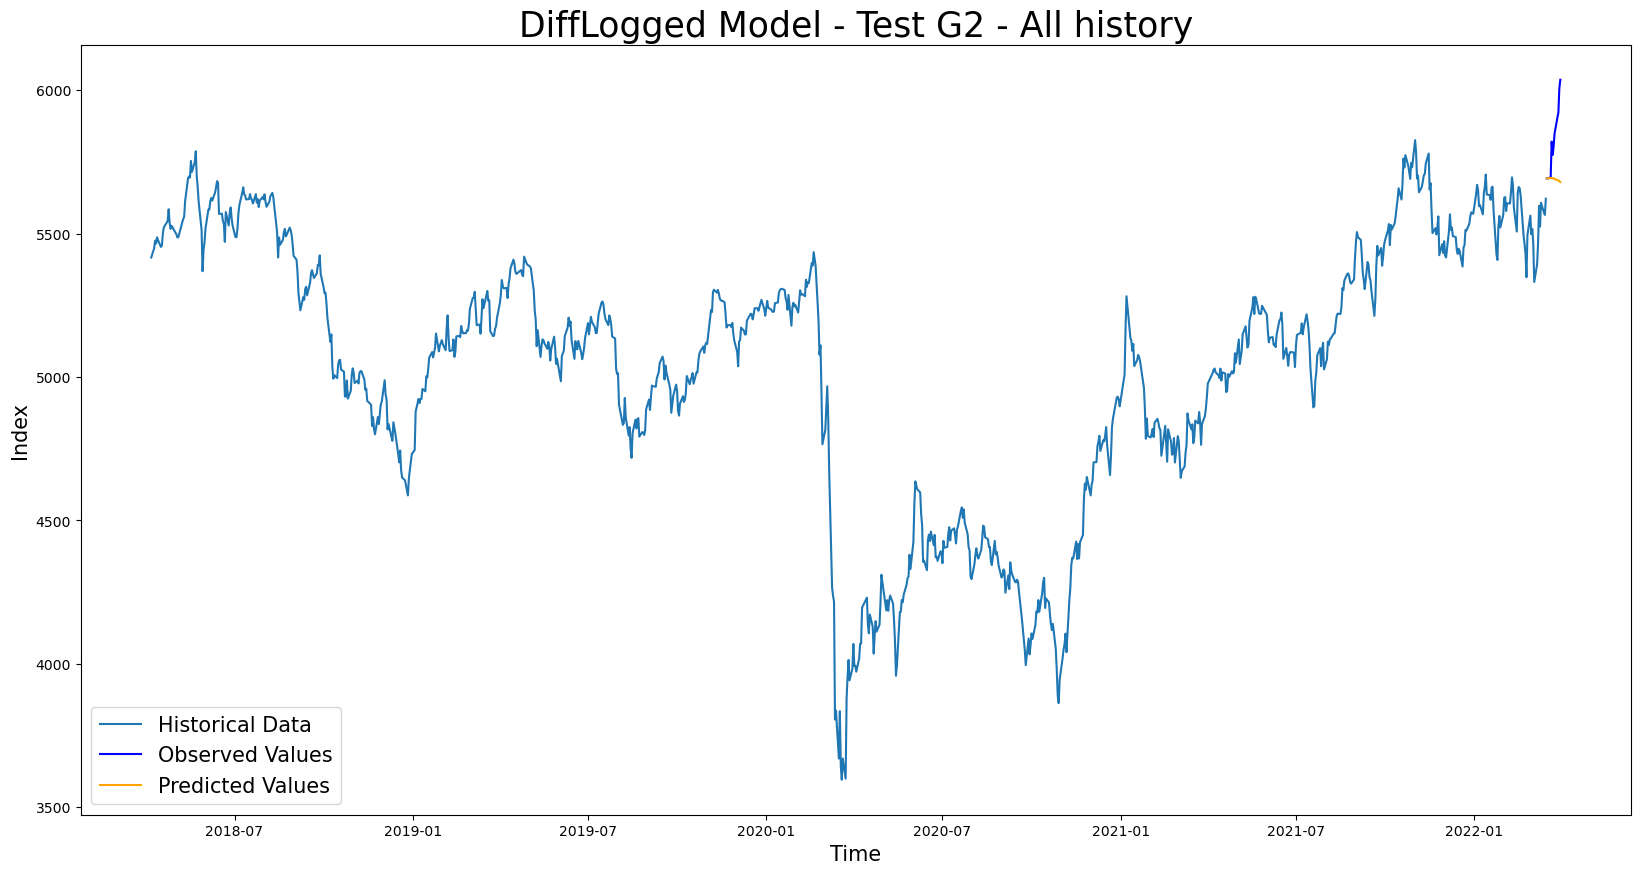

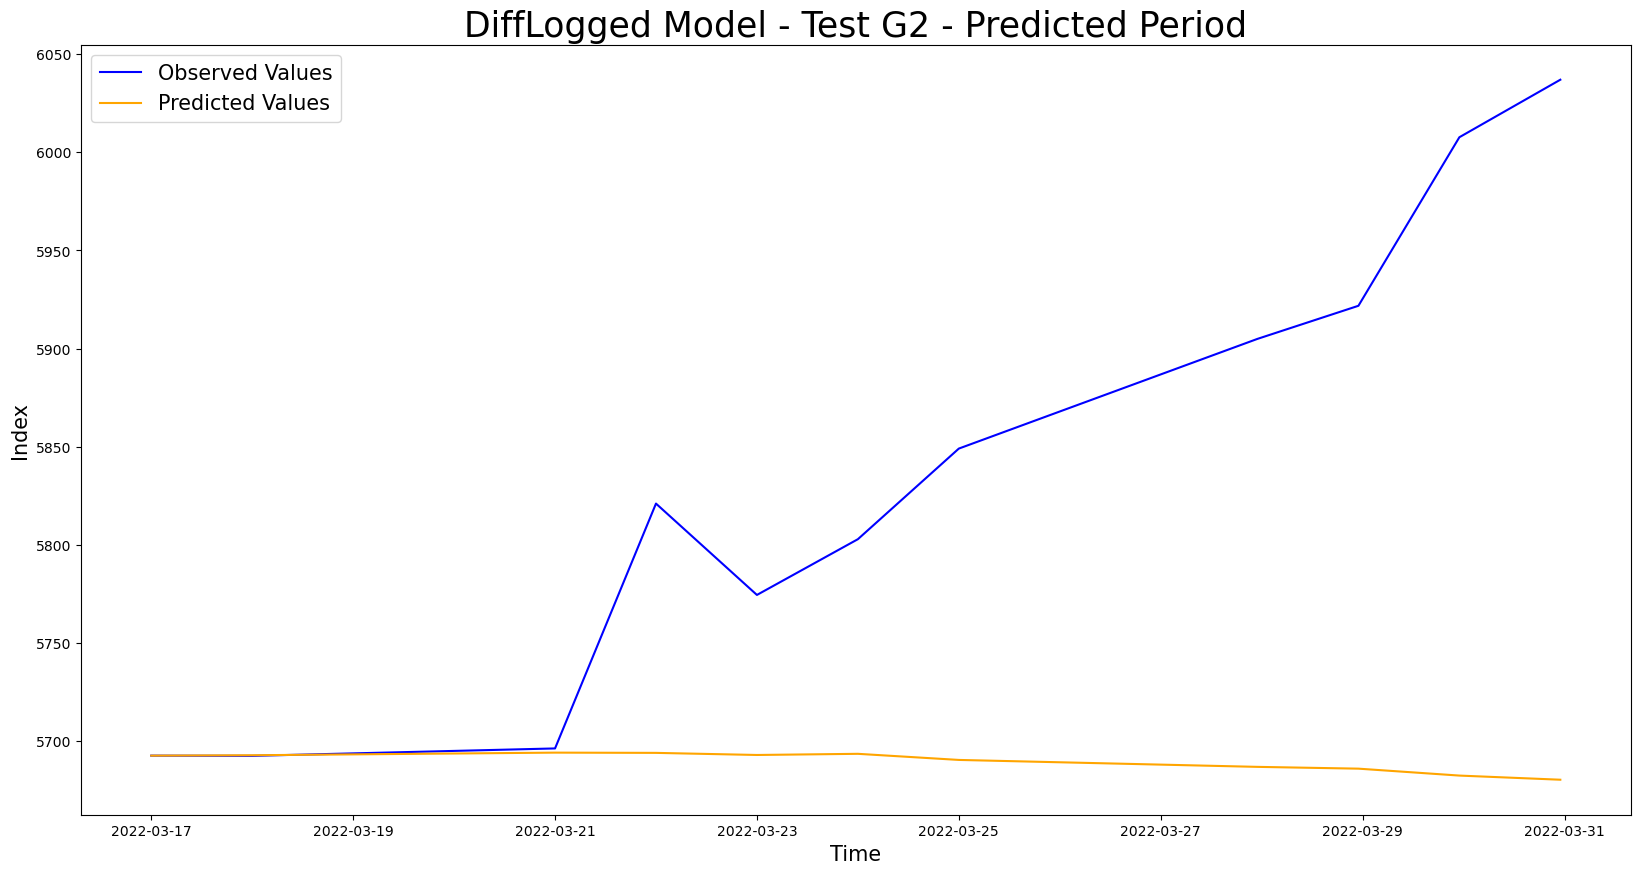

In [ ]:
plotResults(history=global_data[:-1], predicted=predicted_stock_price, title="DiffLogged Model - Test G2")

#### Multi-index Variation

In [ ]:
#Bivariate model
predicted_stock_var=lstm_biv_model.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [ ]:
predicted_stock_var*100

array([[-0.35364866],
       [-0.5132227 ],
       [-0.35104948],
       [-0.14001405],
       [ 0.06421998],
       [ 0.20948145],
       [ 0.4184387 ],
       [ 0.46067443],
       [ 0.05675473],
       [-0.0847625 ],
       [ 0.13007806],
       [-0.13448744],
       [-0.36294818],
       [-0.4683263 ],
       [-0.33579624],
       [-0.28827628],
       [-0.24963564],
       [-0.0302012 ],
       [ 0.17785816],
       [ 0.2644057 ],
       [ 0.25913617],
       [ 0.20703293],
       [-0.03794447],
       [-0.27576593],
       [-0.25611687],
       [-0.19639263],
       [-0.05465432],
       [-0.07199592],
       [-0.2001147 ],
       [-0.41006514],
       [-0.03823212],
       [ 0.24237339],
       [ 0.10836469],
       [-0.35952166],
       [-0.5733569 ],
       [-0.4676688 ],
       [-0.14999665],
       [-0.10111054],
       [ 0.06424516],
       [ 0.01634718],
       [ 0.359231  ],
       [ 0.52817774],
       [ 0.15530366],
       [-0.00916665],
       [-0.24047154],
       [-0

In [ ]:
#This is the correct one
predicted_stock_price = undiffLogData2(np.expand_dims(test_data[LOOK_BACK:,0], axis=1), predicted_stock_var);


In [ ]:
predicted_stock_price

array([[5468.22021484],
       [5487.59273841],
       [5359.28470138],
       [5487.87150508],
       [5604.97213969],
       [5521.20314553],
       [5596.27432123],
       [5542.20064101],
       [5596.45887423],
       [5689.51025149],
       [5697.45714391],
       [5813.5427993 ],
       [5782.3513875 ],
       [5824.07025807],
       [5876.57733029],
       [5941.7585828 ],
       [6025.02387966],
       [6052.05947018],
       [5989.92887421],
       [6089.89921345],
       [6050.79999528],
       [6047.48862257],
       [6093.48128178],
       [6099.8942113 ],
       [6098.5347473 ],
       [6149.24913316],
       [6118.57446122],
       [6126.85744275],
       [6060.19159862],
       [6014.93488963],
       [5885.80643737],
       [5888.59074645],
       [5917.93889886],
       [5923.58720944],
       [5904.61015878],
       [5865.21255559],
       [5816.64890764],
       [5825.0208255 ],
       [5726.80749898],
       [5786.24138634],
       [5654.36563423],
       [5684.662

In [ ]:
testPredictionsScore(test_data, predicted_stock_price)

Test Score: 77.35 RMSE


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_8456\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [ ]:
# For bivariate use data=global_data.drop(['Volume']
day_before_price = generateBenchmark(data=global_data[['Close']])

In [ ]:

testDayBeforeScore(predicted=day_before_price, actual=test_data[-PERIODS_TO_PREDICT:,0])

Test Score Day before: 76.91 RMSE


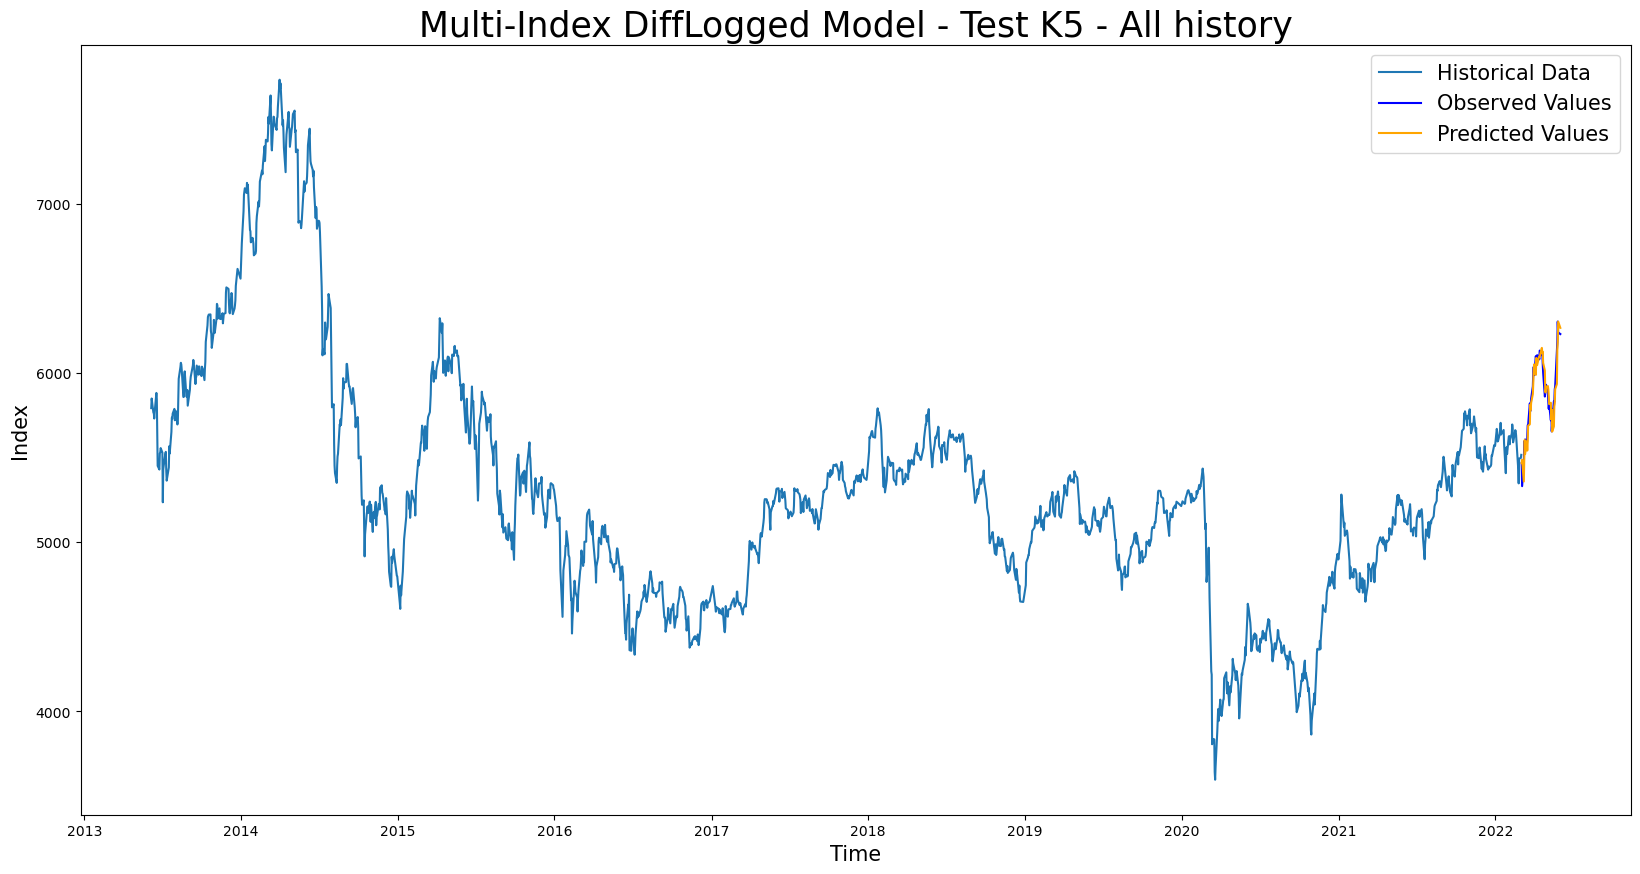

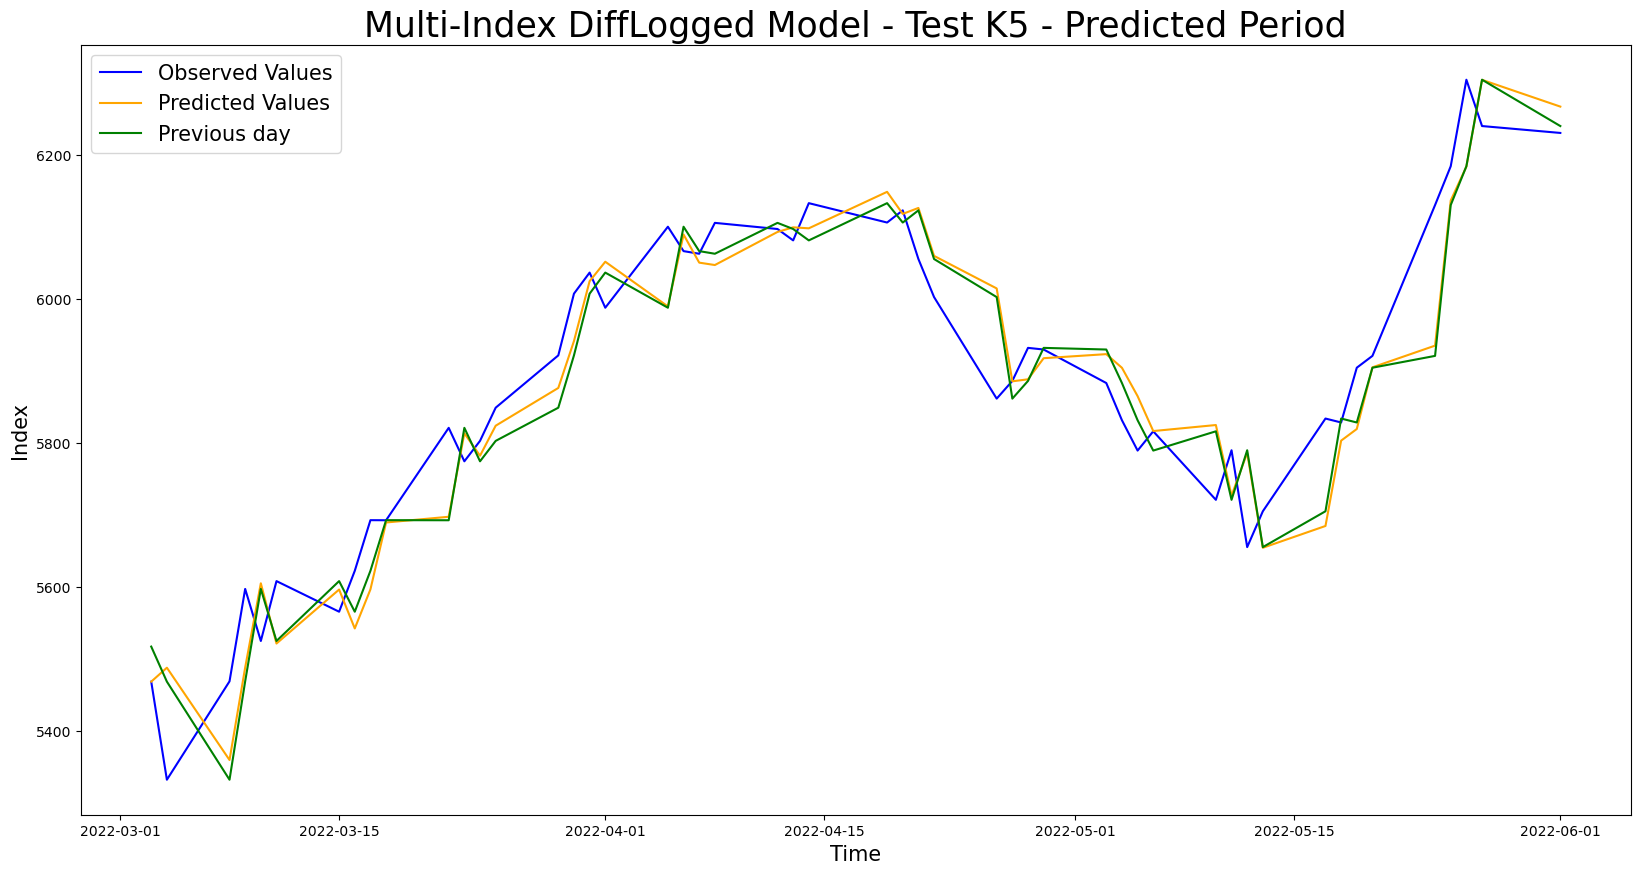

In [ ]:
plotResults(history=global_data, benchmark=day_before_price, predicted=predicted_stock_price, title="Multi-Index DiffLogged Model - Test K5" )


In [ ]:
predicted_stock_evo, actual_stock_evo = generateEvolutionArray(predicted_stock_var, scaled_test_data[-(PERIODS_TO_PREDICT-1):,0])


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:" + str(accuracy_score(predicted_stock_evo, actual_stock_evo)*100) +"%.")

Accuracy:40.816326530612244%.


In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual_stock_evo, predicted_stock_evo)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix


array([[12, 11],
       [18,  8]], dtype=int64)

<AxesSubplot:title={'center':'"K5" Heatmap'}>

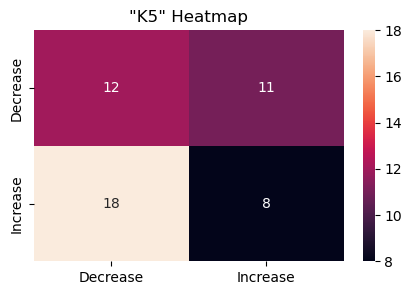

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Increase"],
                  columns = ["Decrease", "Increase"])
plt.figure(figsize = (5,3))
plt.title('"K5" Heatmap')
sn.heatmap(df_cm,annot=True)

#### Foreign VAR

In [ ]:
#gets the values from previous day as a benchmark
day_before_price = generateBenchmark(global_data_p,size_train_data)

# the model makes its predictiona (scaled data)
predicted_stock_var=lstm_model.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [ ]:
#This is the correct one
predicted_stock_price = undiffLogData2(test_data[LOOK_BACK:], predicted_stock_var);

# INTRA DAY

In [ ]:
#For model based in difflog use this:
#predicted_stock_var=lstm_biv_model.predict(X_test)
#predicted_stock_price = undiffLogData2(np.expand_dims(test_data[LOOK_BACK:,0], axis=1), predicted_stock_var);
#actual_stock_var=scaled_test_data[-(PERIODS_TO_PREDICT-1):,0]
#For model based in ABS values use this:
predicted_stock_price=lstm_biv_model.predict(X_test)


ValueError: in user code:

    File "c:\Users\Utilizador\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Utilizador\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Utilizador\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Utilizador\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\Utilizador\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Utilizador\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 40, 2), found shape=(None, 60, 4)


In [ ]:
predicted_stock_price = testscaler[0].inverse_transform(predicted_stock_price)

In [ ]:
#predicted_stock_price=testscaler[0].inverse_transform(predicted_stock_price)
predicted_stock_var = diffLogData_new(predicted_stock_price)
actual_stock_var = diffLogData_new(np.expand_dims(test_data[-(PERIODS_TO_PREDICT):,0], axis=1))


In [ ]:
predicted_stock_price

NameError: name 'predicted_stock_price' is not defined

In [ ]:
np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], predicted_stock_price))

2.3315550842289934

In [ ]:
testPredictionsScore()

Test Score: 2.33 RMSE


In [ ]:

day_before_price = generateBenchmark(data=global_data[['Close']], size=size_train_data)


In [ ]:
np.sqrt(mean_squared_error(day_before_price, global_data.iloc[-PERIODS_TO_PREDICT:,0]))

1.2067191165428095

In [ ]:
testDayBeforeScore(day_before_price, global_data.iloc[-PERIODS_TO_PREDICT:,0])

Test Score Day before: 1.21 RMSE


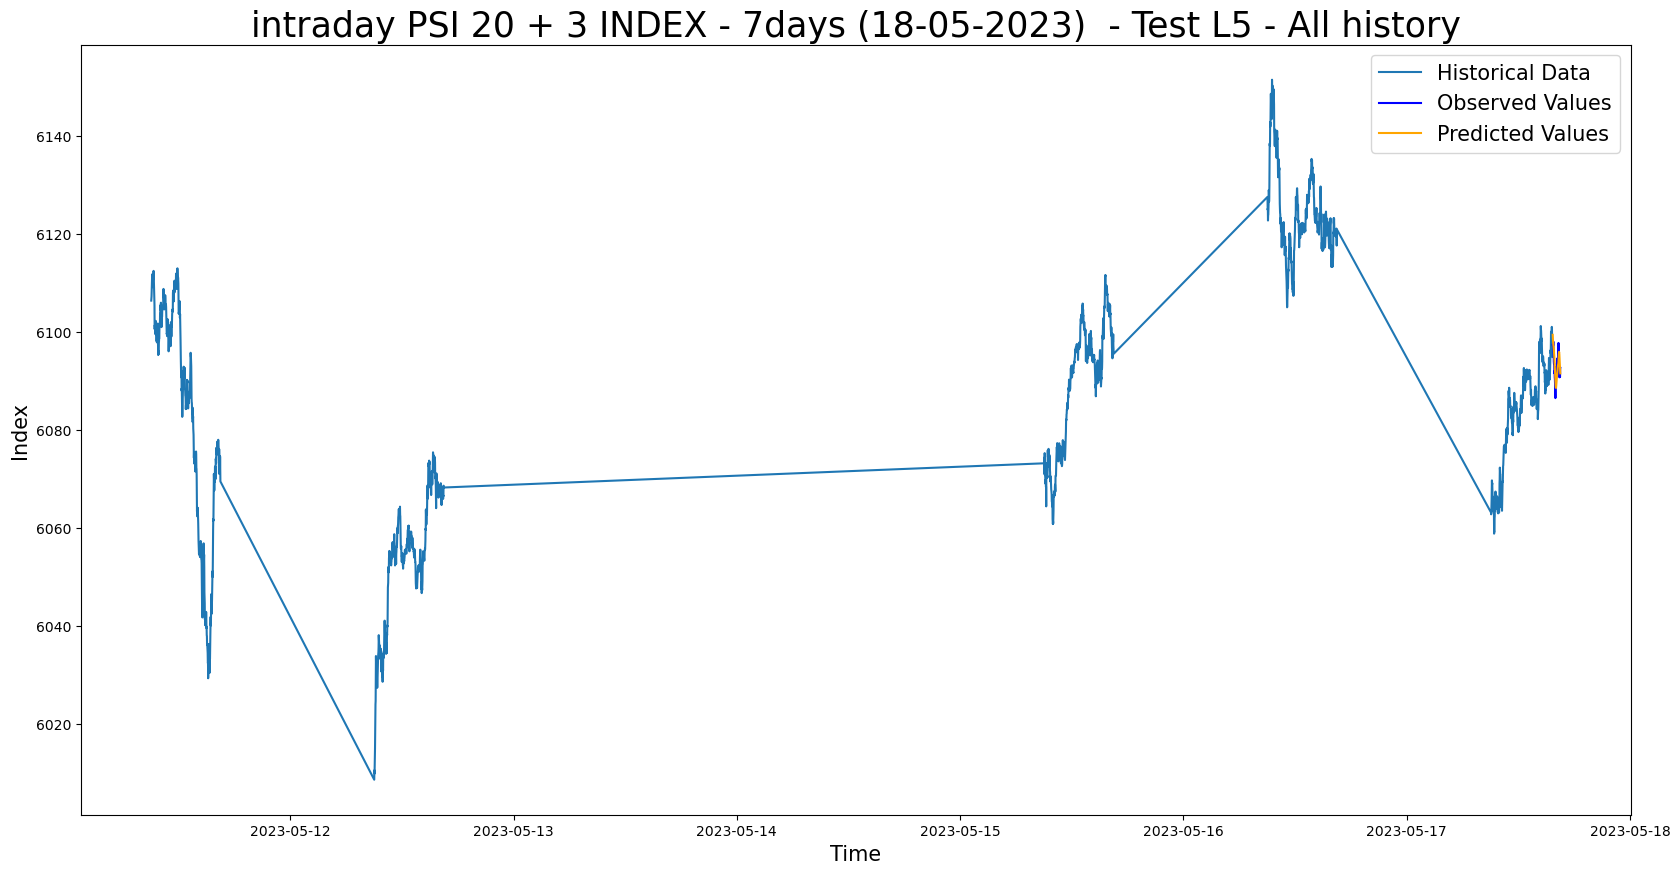

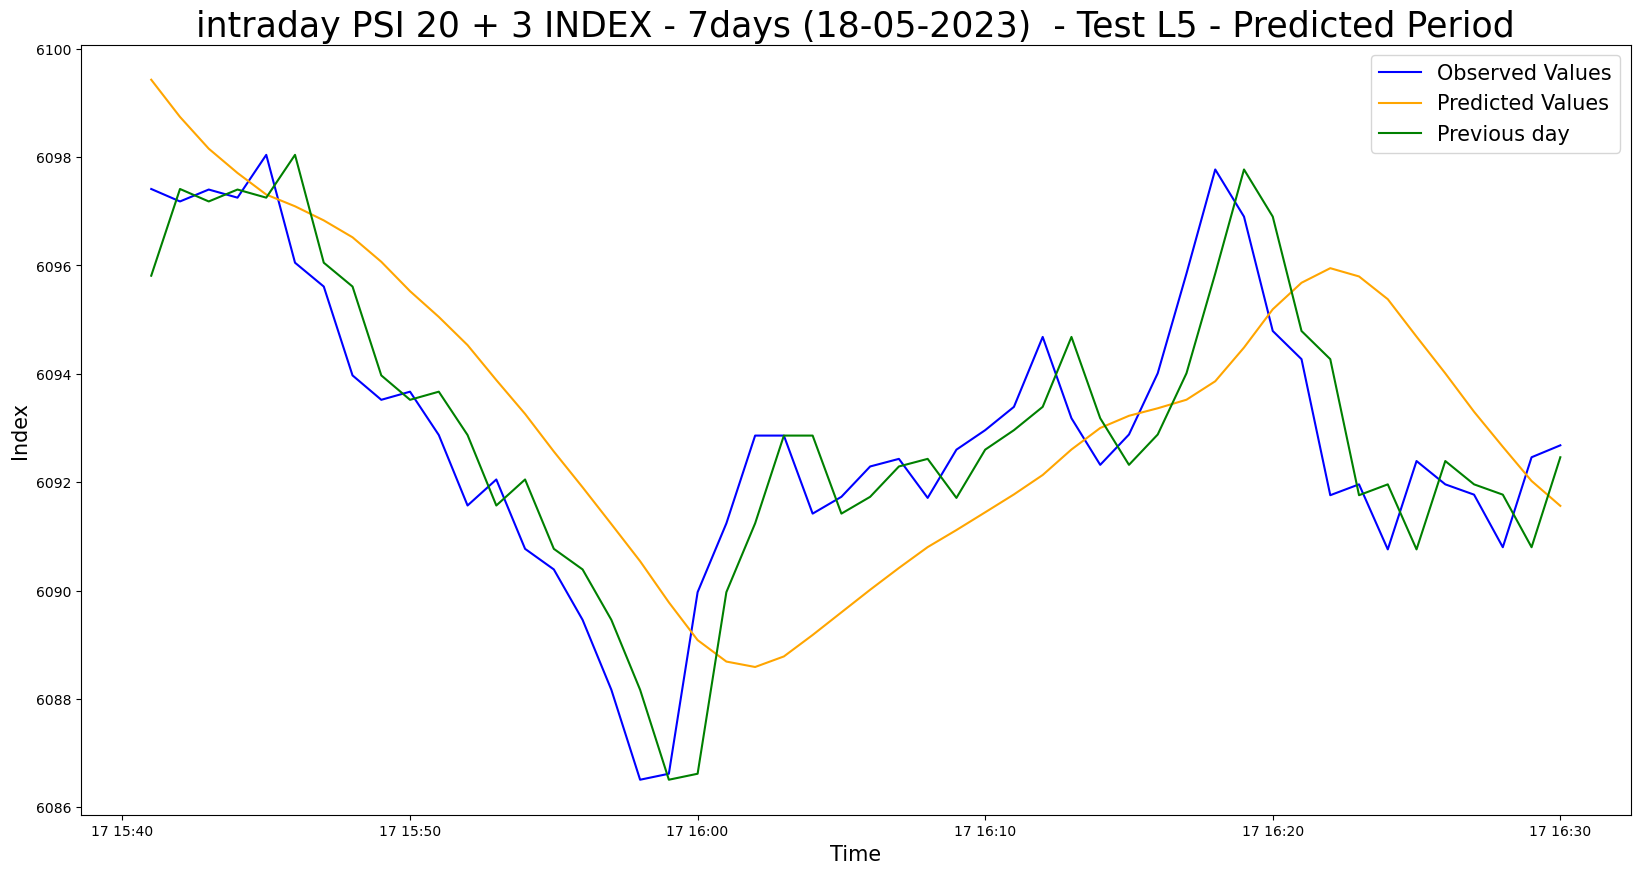

In [ ]:
plotResults(history=global_data[['Close']],predicted=predicted_stock_price,benchmark=day_before_price, 
            title="intraday PSI 20 + 3 INDEX - 7days ("+dates[0] +")  - Test L5")

In [ ]:
predicted_stock_evo, actual_stock_evo = generateEvolutionArray(predicted=predicted_stock_var, actual=actual_stock_var)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:" + str(accuracy_score(predicted_stock_evo, actual_stock_evo)*100) +"%.")

Accuracy:59.183673469387756%.


In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual_stock_evo, predicted_stock_evo)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix


array([[17,  8],
       [12, 12]], dtype=int64)

<AxesSubplot:title={'center':'"L5" Heatmap'}>

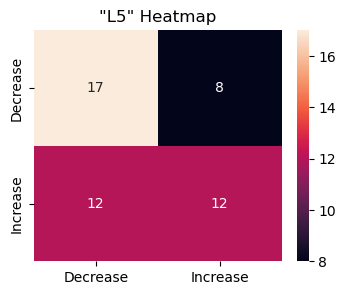

In [ ]:

import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Increase"],
                  columns = ["Decrease", "Increase"])
plt.figure(figsize = (4,3))
plt.title('"L5" Heatmap')
sn.heatmap(df_cm,annot=True)


In [ ]:
predicted_stock_evo, actual_stock_evo = generateEvolutionArray(predicted=predicted_stock_var, actual=actual_stock_var,numCat=3)

In [ ]:
print("Accuracy:" + str(accuracy_score(predicted_stock_evo, actual_stock_evo)*100) +"%.")

Accuracy:38.775510204081634%.


In [ ]:

confusion_matrix = metrics.confusion_matrix(actual_stock_evo, predicted_stock_evo)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix

array([[ 5,  9,  2],
       [ 8, 14,  0],
       [ 3,  8,  0]], dtype=int64)

<AxesSubplot:title={'center':'"L5b" Heatmap'}>

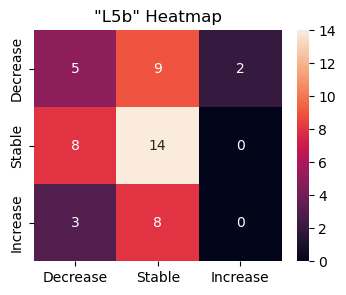

In [ ]:
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Stable", "Increase"],
                  columns = ["Decrease", "Stable", "Increase"])
plt.figure(figsize = (4,3))
plt.title('"L5b" Heatmap')
sn.heatmap(df_cm,annot=True)

In [ ]:
actual_stock_price=np.expand_dims(test_data[-PERIODS_TO_PREDICT:,0], axis=1)

In [ ]:
#actual_stock_price=test_data[-PERIODS_TO_PREDICT:,0]
np.log(predicted_stock_price[1:].squeeze())-np.log(actual_stock_price[-1:].squeeze())


array([ 9.93728638e-04,  8.97407532e-04,  8.23974609e-04,  7.59124756e-04,
        7.22885132e-04,  6.80923462e-04,  6.29425049e-04,  5.55038452e-04,
        4.66346741e-04,  3.88145447e-04,  3.03268433e-04,  1.97410583e-04,
        9.44137573e-05, -1.90734863e-05, -1.27792358e-04, -2.39372253e-04,
       -3.50952148e-04, -4.75883484e-04, -5.90324402e-04, -6.55174255e-04,
       -6.72340393e-04, -6.39915466e-04, -5.75065613e-04, -5.06401062e-04,
       -4.37736511e-04, -3.71932983e-04, -3.08990479e-04, -2.57492065e-04,
       -2.03132629e-04, -1.48773193e-04, -9.05990601e-05, -1.33514404e-05,
        5.24520874e-05,  8.86917114e-05,  1.11579895e-04,  1.37329102e-04,
        1.93595886e-04,  2.95639038e-04,  4.11987305e-04,  4.92095947e-04,
        5.35964966e-04,  5.11169434e-04,  4.42504883e-04,  3.29017639e-04,
        2.17437744e-04,  1.01089478e-04, -4.76837158e-06, -1.08718872e-04,
       -1.84059143e-04], dtype=float32)

In [ ]:
np.log(predicted_stock_price[1:].squeeze())-np.log(global_data.iloc[-PERIODS_TO_PREDICT+1:,0])



Datetime
2023-05-17 15:42:00    0.000256
2023-05-17 15:43:00    0.000123
2023-05-17 15:44:00    0.000075
2023-05-17 15:45:00   -0.000120
2023-05-17 15:46:00    0.000170
2023-05-17 15:47:00    0.000201
2023-05-17 15:48:00    0.000418
2023-05-17 15:49:00    0.000418
2023-05-17 15:50:00    0.000304
2023-05-17 15:51:00    0.000357
2023-05-17 15:52:00    0.000486
2023-05-17 15:53:00    0.000301
2023-05-17 15:54:00    0.000408
2023-05-17 15:55:00    0.000357
2023-05-17 15:56:00    0.000401
2023-05-17 15:57:00    0.000502
2023-05-17 15:58:00    0.000663
2023-05-17 15:59:00    0.000520
2023-05-17 16:00:00   -0.000145
2023-05-17 16:01:00   -0.000418
2023-05-17 16:02:00   -0.000701
2023-05-17 16:03:00   -0.000669
2023-05-17 16:04:00   -0.000368
2023-05-17 16:05:00   -0.000350
2023-05-17 16:06:00   -0.000373
2023-05-17 16:07:00   -0.000331
2023-05-17 16:08:00   -0.000149
2023-05-17 16:09:00   -0.000244
2023-05-17 16:10:00   -0.000249
2023-05-17 16:11:00   -0.000265
2023-05-17 16:12:00   -0.000418

# Clear All

# INTRA DAY - Models go

In [51]:
def generateEvolutionArray(predicted, actual, numCat=2) :  
    predicted_stock_evo = np.where(predicted < 0, 0, 1).squeeze()
    actual_stock_evo = np.where(actual < 0, 0, 1)
    if numCat >2 :
        #threshold_pred = (-np.percentile(predicted, 33)+np.percentile(predicted, 66))/2
        threshold_pred = max(abs(np.percentile(predicted, 33)),np.percentile(predicted, 66))
        threshold_act = max(abs(np.percentile(actual, 33)),np.percentile(actual, 66))
        
        predicted_stock_evo = np.where(predicted < -threshold_pred, 0, np.where(predicted > threshold_pred, 2, 1)).squeeze()
        actual_stock_evo = np.where(actual < -threshold_act, 0, np.where(actual > threshold_act, 2, 1))
    return predicted_stock_evo, actual_stock_evo


In [59]:
def execeutePredictions(date, X_test, numberOfGoes=30) :
    from keras.models import load_model
    predicted_stock_prices_scaled = []
    for testNumber in range(1, numberOfGoes+1) :
        filename = '.\models_go\model' + date +'_'+str(testNumber)+'.h5'
        #For single_stock
        #filename = '.\models_go\ss\model_ss_' + date +'_'+str(testNumber)+'.h5'
        model = load_model(filename)
        predicted_stock_prices_scaled.append(model.predict(X_test))
    return predicted_stock_prices_scaled   

In [ ]:
predictions_scaled = execeutePredictions(dates[1],X_test,numberOfGoes=30)

2/2 [==============================] - 1s 16ms/step


In [52]:
def unscaleResults(predicted_stock_prices_scaled, scaler) :
    predicted_stock_prices, predicted_stock_vars = [],[]
    
    for predicted_stock_price in predicted_stock_prices_scaled :
        p = scaler.inverse_transform(predicted_stock_price)

        predicted_stock_prices.append(p)
        predicted_stock_vars.append(diffLogData_new(p))
    
    
    return predicted_stock_prices,predicted_stock_vars
    
    

In [ ]:
predicted_stock_prices,predicted_stock_vars = unscaleResults(predictions_scaled, testScaler[0])
actual_stock_var = diffLogData_new(np.expand_dims(test_data[-(PERIODS_TO_PREDICT):,0], axis=1))

In [ ]:
predicted_stock_prices[0].squeeze()

array([6095.464 , 6097.235 , 6097.231 , 6097.595 , 6097.37  , 6098.1025,
       6096.067 , 6095.597 , 6093.773 , 6093.3467, 6093.527 , 6092.921 ,
       6091.699 , 6092.042 , 6090.814 , 6090.437 , 6089.536 , 6088.534 ,
       6087.44  , 6087.489 , 6089.3486, 6090.576 , 6092.2573, 6092.626 ,
       6091.2847, 6091.3066, 6091.666 , 6091.8604, 6091.47  , 6092.4316,
       6092.8867, 6093.4375, 6094.641 , 6093.3784, 6092.3267, 6092.56  ,
       6093.515 , 6095.3423, 6097.4146, 6097.0845, 6095.0767, 6094.1074,
       6091.5264, 6091.563 , 6090.709 , 6092.095 , 6092.015 , 6091.9033,
       6091.008 , 6092.22  ], dtype=float32)

In [53]:
def analysePredictions(predicted_stock_prices,predicted_stock_vars,actual_stock_var, numcat=2) : 
    from sklearn.metrics import accuracy_score
    import itertools
    rmses = []
    accuracies = []
    pred_evo = []

    actual_evo = generateEvolutionArray(predicted_stock_vars[0].squeeze(),actual_stock_var, numCat=numcat)[1]
    
    for (pred_price, pred_var) in itertools.zip_longest(predicted_stock_prices, predicted_stock_vars):
        rmses.append(np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], pred_price.squeeze())))
        p = generateEvolutionArray(pred_var.squeeze(),actual_stock_var, numCat=numcat)[0]
        accuracies.append(accuracy_score(p, actual_evo)*100)
        pred_evo.append(p)
    return rmses,accuracies, pred_evo, actual_evo

In [ ]:

rmses, accuracies, pred_evo, actual_evo = analysePredictions(predicted_stock_prices,predicted_stock_vars, actual_stock_var )

In [ ]:
indexBestAcc = accuracies.index(max(accuracies))
print ("Max Accuracy " + str(round(max(accuracies),2)) + "% on index " + str(indexBestAcc))

Max Accuracy 57.14% on index 0


In [ ]:
actual_evo

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1])

In [ ]:
indexBestRmse = rmses.index(min(rmses))
print ("Min RMSE " + str(round(min(rmses),2)) + " on index " + str(indexBestRmse))

Min RMSE 1.2 on index 7


In [ ]:
predicted_stock_prices[indexBestRmse]

array([[6095.5703],
       [6097.4463],
       [6097.415 ],
       [6097.6045],
       [6097.3506],
       [6098.111 ],
       [6096.006 ],
       [6095.552 ],
       [6093.802 ],
       [6093.411 ],
       [6093.587 ],
       [6092.885 ],
       [6091.599 ],
       [6091.9707],
       [6090.866 ],
       [6090.515 ],
       [6089.702 ],
       [6088.5356],
       [6087.414 ],
       [6087.543 ],
       [6089.8667],
       [6091.1763],
       [6092.92  ],
       [6093.084 ],
       [6091.706 ],
       [6091.561 ],
       [6091.739 ],
       [6091.762 ],
       [6091.323 ],
       [6092.345 ],
       [6092.911 ],
       [6093.4604],
       [6094.669 ],
       [6093.504 ],
       [6092.552 ],
       [6092.855 ],
       [6093.812 ],
       [6095.4395],
       [6097.3184],
       [6096.8887],
       [6094.7285],
       [6093.7783],
       [6091.3223],
       [6091.2476],
       [6090.5566],
       [6092.079 ],
       [6092.2017],
       [6092.1465],
       [6091.3936],
       [6092.8486]],

In [ ]:
#predicted_stock_price=testscaler[0].inverse_transform(predicted_stock_price)
#predicted_stock_var = diffLogData_new(predicted_stock_prices[16])
#actual_stock_var = diffLogData_new(np.expand_dims(test_data[-(PERIODS_TO_PREDICT):,0], axis=1))


In [ ]:
np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], predicted_stock_prices[indexBestRmse]))

1.2019816209590781

In [ ]:

day_before_price = generateBenchmark(data=global_data[['Close']], size=size_train_data)


In [ ]:
np.sqrt(mean_squared_error(day_before_price, global_data.iloc[-PERIODS_TO_PREDICT:,0]))

1.2067191165428095

In [ ]:
testDayBeforeScore(day_before_price, global_data.iloc[-PERIODS_TO_PREDICT:,0])

Test Score Day before: 1.21 RMSE


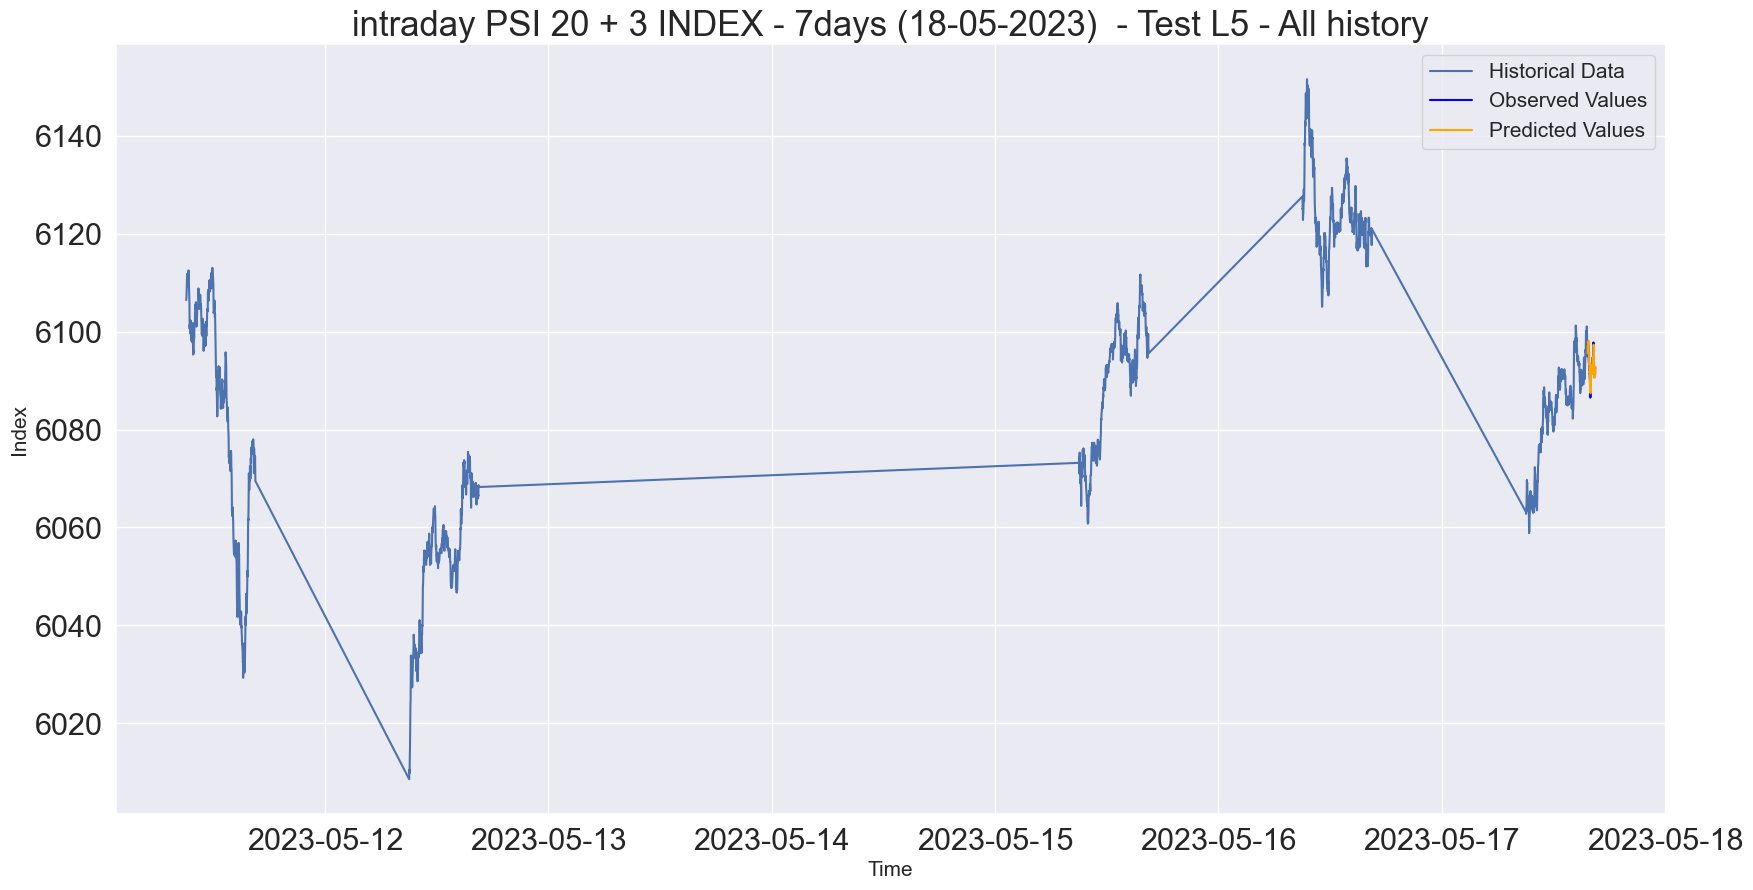

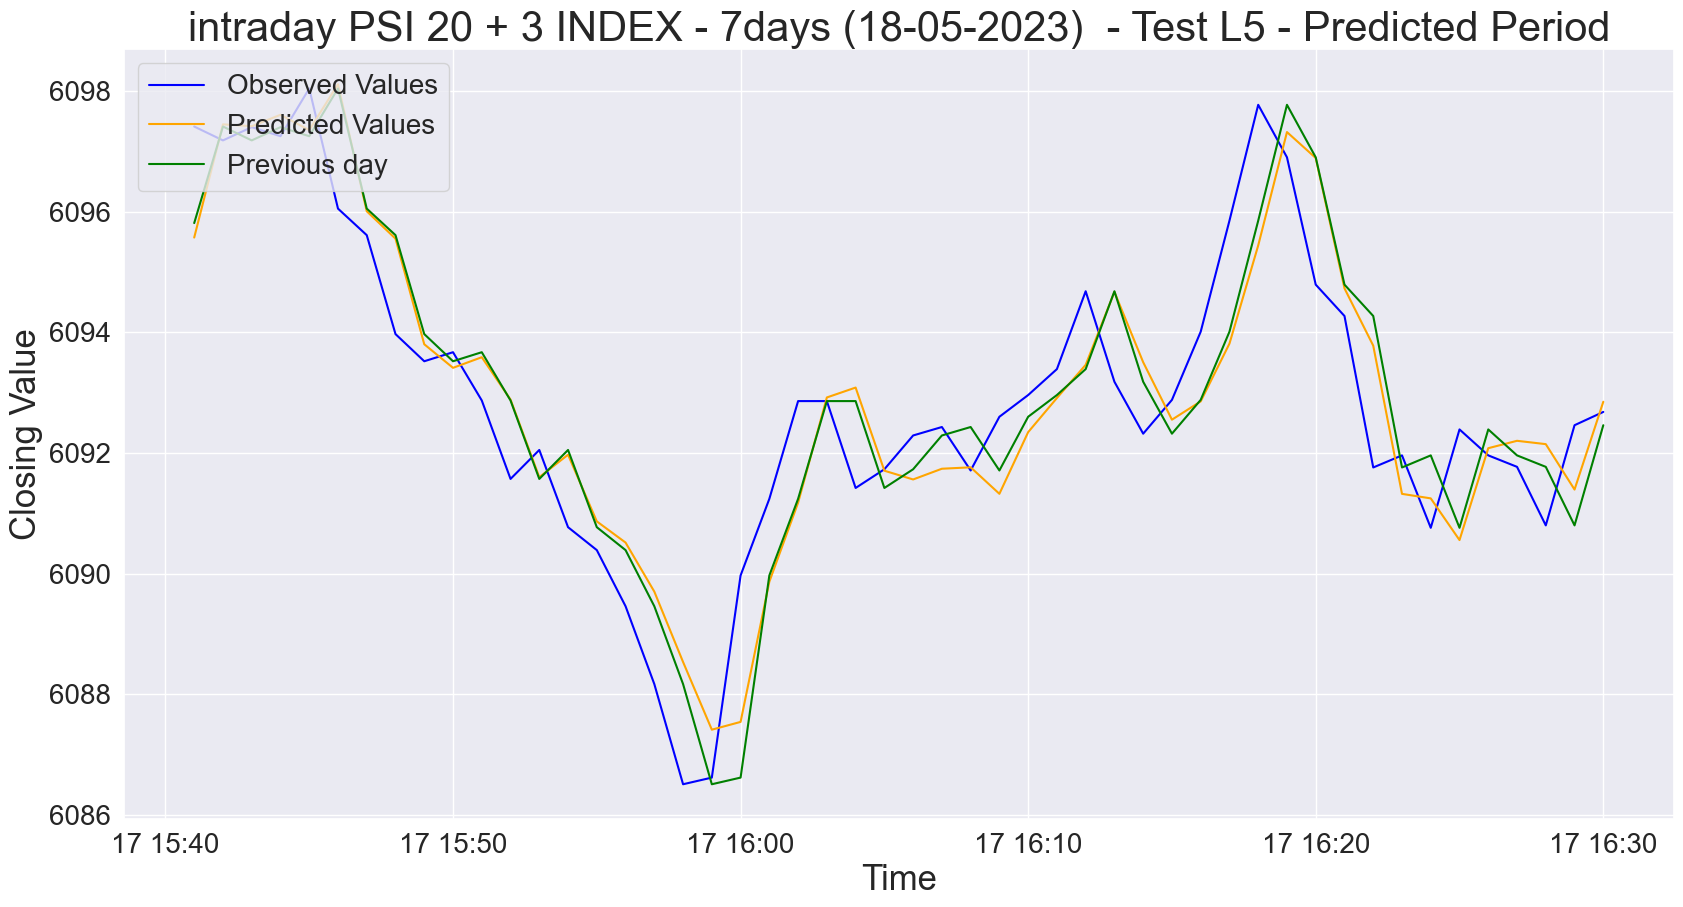

In [ ]:
plotResults(history=global_data[['Close']],predicted=predicted_stock_prices[indexBestRmse],benchmark=day_before_price, 
            title="intraday PSI 20 + 3 INDEX - 7days ("+dates[0] +")  - Test L5")

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual_evo, pred_evo[indexBestAcc])
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix


array([[14, 11],
       [10, 14]], dtype=int64)

<AxesSubplot:title={'center':'"L5" Heatmap'}>

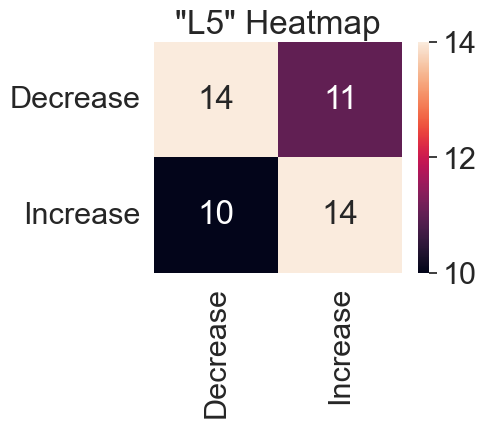

In [ ]:

import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Increase"],
                  columns = ["Decrease", "Increase"])
plt.figure(figsize = (4,3))
plt.title('"L5" Heatmap')
sn.heatmap(df_cm,annot=True)


In [110]:
actual_stock_evo = unscaleResults(predicted=predicted_stock_vars[indexBestAcc], actual=actual_stock_var,numCat=3)[1]

TypeError: unscaleResults() got an unexpected keyword argument 'predicted'

In [ ]:
from sklearn.metrics import accuracy_score
accuracies3 =[]
pred_evo3 =[]
for pred_var in predicted_stock_vars :
    p = generateEvolutionArray(predicted=pred_var, actual=actual_stock_var,numCat=3)[0]
    pred_evo3.append(p)
    accuracies3.append(accuracy_score(p, actual_stock_evo)*100)



In [ ]:
max(accuracies3)
indexBestAcc3 = accuracies3.index(max(accuracies3))

In [ ]:
print ("Best Accuracy 3  " + str(round(max(accuracies3),2)) + "% on index " + str(indexBestAcc3))

Best Accuracy 3  38.78% on index 25


In [ ]:

confusion_matrix = metrics.confusion_matrix(actual_stock_evo, pred_evo3[indexBestAcc3])
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix

array([[6, 7, 3],
       [9, 8, 5],
       [1, 5, 5]], dtype=int64)

<AxesSubplot:title={'center':'"L5b" Heatmap'}>

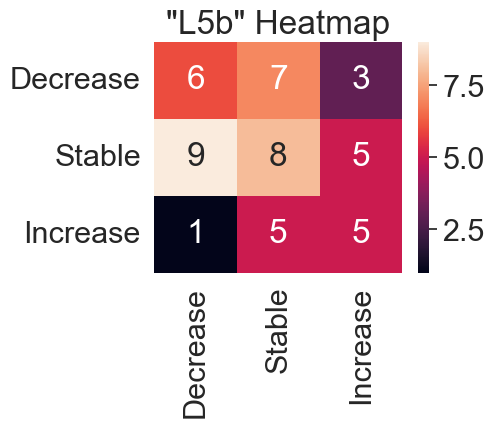

In [ ]:
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Stable", "Increase"],
                  columns = ["Decrease", "Stable", "Increase"])
plt.figure(figsize = (4,3))
plt.title('"L5b" Heatmap')
sn.heatmap(df_cm,annot=True)

In [ ]:
actual_stock_price=np.expand_dims(test_data[-PERIODS_TO_PREDICT:,0], axis=1)

<AxesSubplot:ylabel='Count'>

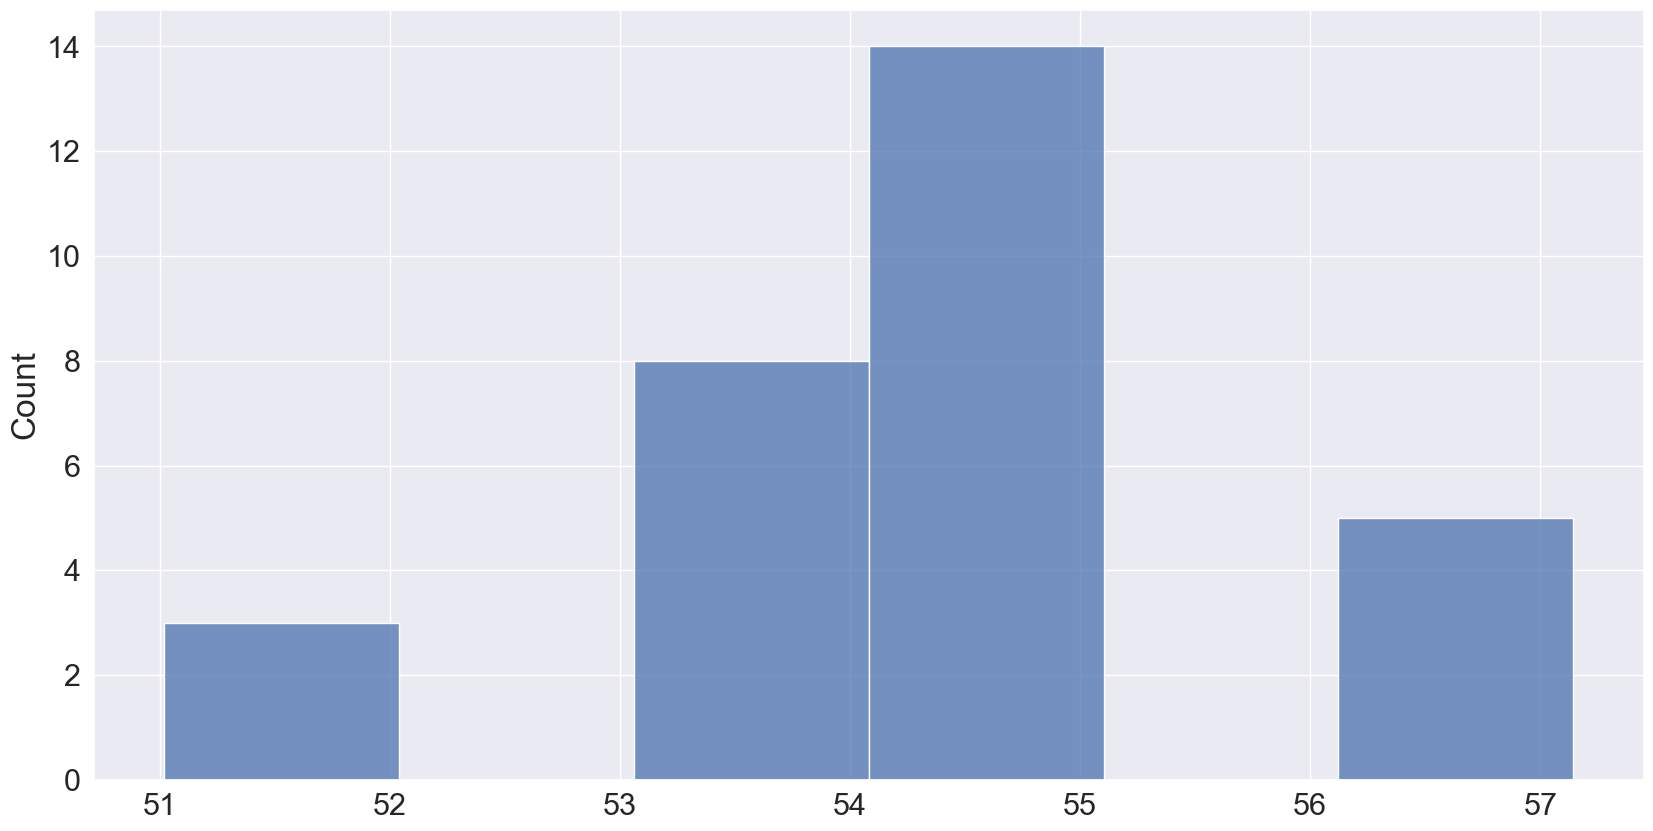

In [ ]:
import seaborn as sns
#plt.hist(accuracies3)
#plt.show()
sns.set(font_scale=2)
sns.histplot(data=accuracies)

<AxesSubplot:ylabel='Count'>

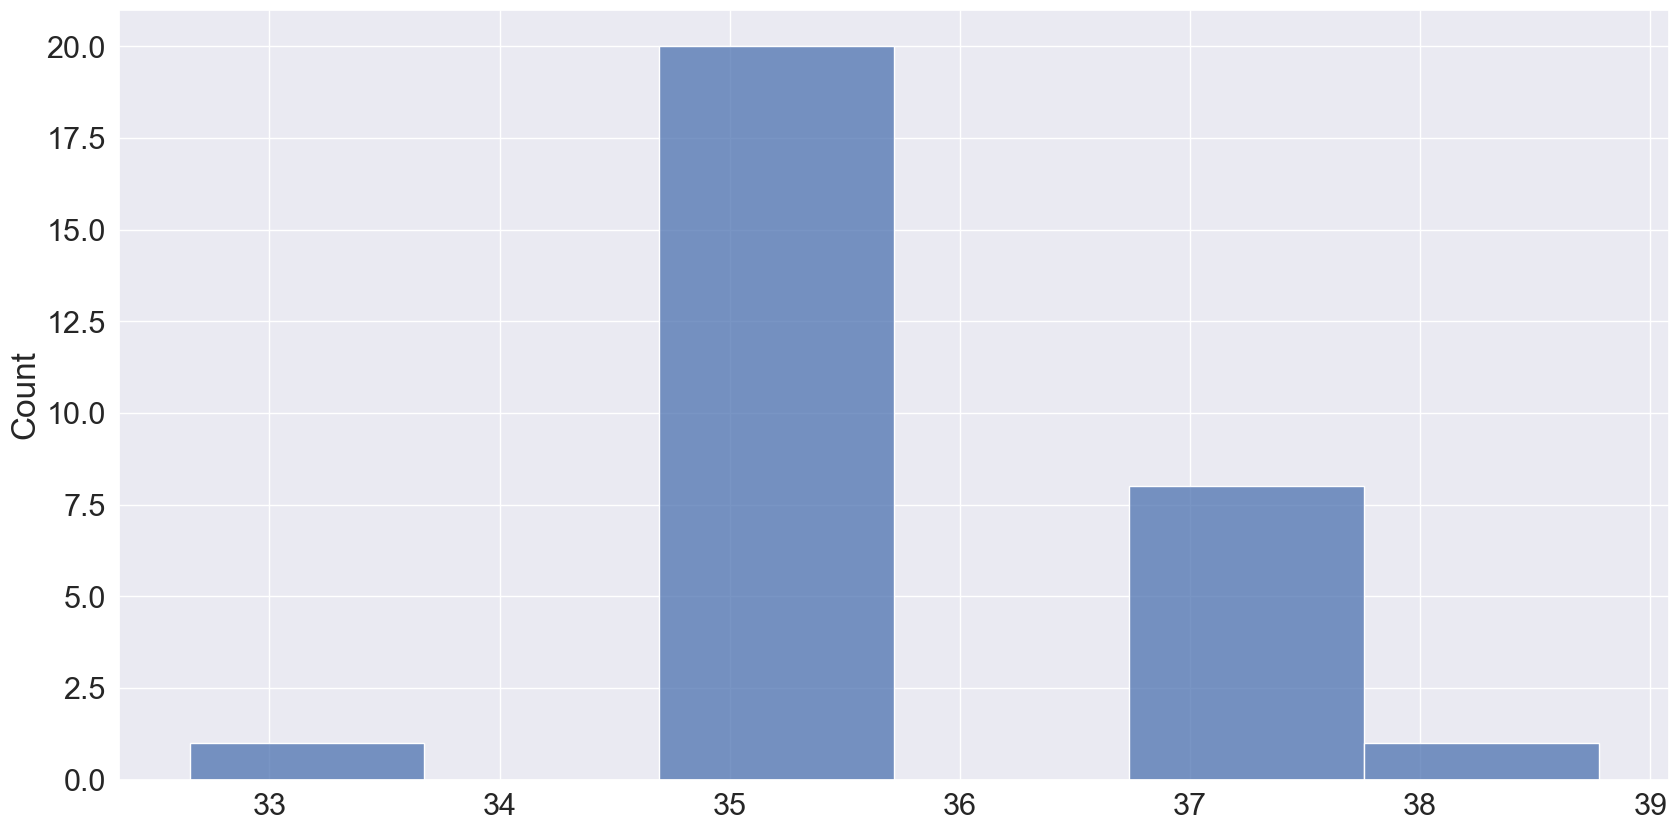

In [ ]:
sns.histplot(data=accuracies3)

In [ ]:
print("******************")
print("The mean of the accuracies is " + str(round(sum(accuracies) / len(accuracies),2)) + "%.")
print("The mean of the accuracies with 3 outcomes is " + str(round(sum(accuracies3) / len(accuracies3),2)) + "%.")

print("******************")
import statistics
print("The median of the accuracies is " + str(round(statistics.median(accuracies),2)) + "%.")
print("The median of the accuracies with 3 outcomes is " + str(round(statistics.median(accuracies3),2)) + "%.")
print("******************")



******************
The mean of the accuracies is 54.49%.
The mean of the accuracies with 3 outcomes is 35.31%.
******************
The median of the accuracies is 55.1%.
The median of the accuracies with 3 outcomes is 34.69%.
******************


# == Algortithmic trading simulation ==

In [57]:
# Loads Data for testing - Drop is the main thing
drp = 500
global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test = prepareIntradayModelGo(dates[2], drop=drp)


In [60]:
# Here we choose the date of the trained model
predictions_scaled = execeutePredictions(dates[0],X_test,numberOfGoes=5)
predicted_stock_prices,predicted_stock_vars = unscaleResults(predictions_scaled, testScaler[0])
actual_stock_var = diffLogData_new(np.expand_dims(test_data[-(PERIODS_TO_PREDICT):,0], axis=1))


2/2 [==============================] - 1s 16ms/step


In [61]:
numCategories=3
rmses, accuracies, pred_evo, actual_evo = analysePredictions(predicted_stock_prices,predicted_stock_vars, actual_stock_var, numcat=numCategories)
indexBestAcc = accuracies.index(max(accuracies))
print ("Max Accuracy " + str(round(max(accuracies),2)) + "% on index " + str(indexBestAcc))

Max Accuracy 38.78% on index 0


In [62]:
pred_evo

[array([1, 2, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 1, 1,
        0, 1, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 2]),
 array([1, 2, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 1,
        0, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 2]),
 array([1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 2]),
 array([0, 2, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 1, 1, 1,
        0, 1, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 2]),
 array([1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 1, 1, 1,
        0, 1, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 2])]

In [63]:
modeldecision = pred_evo[indexBestAcc]
values = test_data[-PERIODS_TO_PREDICT:,0]

In [64]:
modeldecision

array([1, 2, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 1, 1,
       0, 1, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 2])

In [65]:
def calculateProfit(modeldecision,values, verbose=1, possibleOutputs=2):
    import time
    
    balance=0
    for i in range(len(modeldecision)):
               
        #Calculates the variation in respect to the previous moment
        var = values[i+1]-values[i]
        
        #Calculates if it is a profit or a loss based on the model decision
        if possibleOutputs==3 :
            if modeldecision[i]==0:
                profit = -var
            elif modeldecision[i]==1:
                profit = 0
            elif modeldecision[i]==2:
                profit = var


        #Calculates if it is a profit or a loss based on the model decision
        if possibleOutputs==2 :
            profit = var if modeldecision[i]==1 else -var  

        #updates the profit
        balance += profit
               
        # Informs the user IN VERBOSE MODE
        if verbose==1:
            print("value in  moment " + str(i) + "= " + str(round(values[i],2)))
            print("value in  moment " + str(i+1) + "= " + str(round(values[i+1],2)))
            
            if possibleOutputs==2:
                if (modeldecision[i]==1):
                    expected_mov= "[UP]"
                    #Decosion (buy / hold / sell)
                    if i==0 or modeldecision[i-1]==0 :
                        decision = "<<BUY>>"
                    else:
                        decision = "<<HOLD>>"
                else:
                    expected_mov = "[DOWN]"
                    if modeldecision[i-1]==1 :
                        decision = "<<SELL>>"
                    else:
                        decision = "<<HOLD>>"
            
            if possibleOutputs==3:
                if (modeldecision[i]==1):
                    expected_mov= "[STABLE]"
                    #Decosion (buy / hold / sell)
                    decision = "<<SQUARE>>"
                elif (modeldecision[i]==0):
                    expected_mov = "[DOWN]"
                    if modeldecision[i-1]==1:
                        decision = "<<SHORT>>"
                elif (modeldecision[i]==2):
                    expected_mov = "[UP]"
                    if modeldecision[i-1]==1  :
                        decision = "<<LONG>>"
                    


            print("Expected Price Movement:" + expected_mov)
            print("Decision: " + decision)
            print("---------------------")                      
            print("Profit= " + str(round(profit,2)))
            print("Balance= " + str(round(balance,2)))
            print("=================================")
            
    return balance


In [74]:
bal = calculateProfit(modeldecision, values, possibleOutputs=3)

value in  moment 0= 5819.14
value in  moment 1= 5821.78
Expected Price Movement:[STABLE]
Decision: <<SQUARE>>
---------------------
Profit= 0
Balance= 0
value in  moment 1= 5821.78
value in  moment 2= 5822.18
Expected Price Movement:[UP]
Decision: <<LONG>>
---------------------
Profit= 0.4
Balance= 0.4
value in  moment 2= 5822.18
value in  moment 3= 5822.3
Expected Price Movement:[STABLE]
Decision: <<SQUARE>>
---------------------
Profit= 0
Balance= 0.4
value in  moment 3= 5822.3
value in  moment 4= 5826.09
Expected Price Movement:[STABLE]
Decision: <<SQUARE>>
---------------------
Profit= 0
Balance= 0.4
value in  moment 4= 5826.09
value in  moment 5= 5824.0
Expected Price Movement:[UP]
Decision: <<LONG>>
---------------------
Profit= -2.09
Balance= -1.69
value in  moment 5= 5824.0
value in  moment 6= 5822.42
Expected Price Movement:[DOWN]
Decision: <<LONG>>
---------------------
Profit= 1.58
Balance= -0.11
value in  moment 6= 5822.42
value in  moment 7= 5821.36
Expected Price Movement

In [131]:

def runAlgorithm(week=0, drop=0, ncat=2, model=0):
    global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test = prepareIntradayModelGo(dates[week], drop=drop)
    predictions_scaled = execeutePredictions(dates[model],X_test,numberOfGoes=30)
    predicted_stock_prices,predicted_stock_vars = unscaleResults(predictions_scaled, testScaler[0])
    actual_stock_var = diffLogData_new(np.expand_dims(test_data[-(PERIODS_TO_PREDICT):,0], axis=1))
    rmses, accuracies, pred_evo, actual_evo = analysePredictions(predicted_stock_prices,predicted_stock_vars, actual_stock_var, numcat=ncat)
    #indexBestAcc = accuracies.index(max(accuracies))
    
    balances = []
    for i in range(30):
        balances.append(calculateProfit(pred_evo[i], values, verbose=0, possibleOutputs=ncat))

    return balances

In [130]:
def runRunAlg(week=1, numDrops=18, numCats=2, model=0) :
    bal = pd.DataFrame()
    for i in range (0,numDrops):
        start=i*100
        bal['W'+str(week)+'-'+str(start)] = runAlgorithm(week=week, drop=start, ncat=numCats, model=model)
    return bal



In [76]:
balances = pd.DataFrame()

In [132]:
balances['W1-000'] =runAlgorithm(week=2, drop=0, ncat=3, model=1);

2/2 [==============================] - 1s 11ms/step


In [118]:
balances.loc[:,].mean()

W2-0        5.876172
W2-100      1.126986
W2-200      1.543913
W2-300      9.314128
W2-400     -3.625651
W2-500     -4.339714
W2-600     -7.735742
W2-700      4.554329
W2-800     15.943473
W2-900     -0.885693
W2-1000    -2.090853
W2-1100   -10.938786
W2-1200    -5.284603
W2-1300     4.047396
W2-1400    -9.897917
W2-1500     0.890413
W2-1600     7.482568
W2-1700     0.024219
dtype: float64

In [137]:
balances=runRunAlg(week=3, numDrops=18, numCats=3, model=1)


2/2 [==============================] - 1s 12ms/step


In [138]:
balances.iloc[:,]

W3-0    W3-100     W3-200    W3-300     W3-400     W3-500     W3-600  \
0    6.760254  4.099121   6.918945  2.842285  -3.297363  -6.461914   5.350586   
1   11.330078  5.478516   9.688477  3.752441  -3.297363  -6.461914   3.650879   
2    9.960449  3.388672   9.688477  2.732422  -6.597656  -6.461914   7.850586   
3   12.430176  5.478516   6.918945  6.681641   0.982422  -4.881836   3.561035   
4    7.030273  3.388672   9.828613  1.552246  -5.987793  -7.131836  12.930664   
5   12.430176  4.099121  11.329102  3.612305  -5.646973  -6.461914   5.350586   
6    3.590820  5.478516   8.998535  1.492188  -9.057617  -6.461914   3.050781   
7    5.170898  5.478516   9.688477  5.162598  -6.707520  -7.131836   8.840332   
8    8.419922  8.468750  11.448730  3.832031  -6.927246  -6.461914   3.180176   
9   17.729980  2.838867  10.929199  2.232422  -6.067383  -2.602051   5.220215   
10  12.430176  5.478516  10.138672  1.172363   0.182617  -7.131836   5.690430   
11   9.500000  3.388672   9.688477 -0.517578 -11.167480  -4.881836   7.991211   
12  17.729980  5.478516   9.688477  2.412598  -6.917480  -4.881836   5.140625   
13   7.030273  5.478516   9.038574  8.891602 -10.156250  -4.881836   6.051270   
14   7.030273  5.478516   9.688477  2.922363  -1.828125  -7.771973   6.970703   
15  10.120117  5.478516  11.448730 -0.157715  -1.617676  -6.461914   2.460449   
16  12.449707  8.468750   9.398926  2.301758  -4.207031  -7.771973   8.601074   
17   3.190430  5.478516   6.918945  3.752441  -0.167480  -4.881836   3.940918   
18   9.500000  4.099121   6.369141 -0.327637  -5.646973  -4.881836   7.460938   
19   7.030273  5.478516  11.559082  2.812500  -8.676758  -4.881836   8.201172   
20  15.260254  2.838867   6.918945  3.001953  -3.387207  -7.131836   4.190918   
21   8.290527  3.388672  11.448730  3.332031   0.951660  -8.441895   6.320801   
22   8.140137  5.478516   8.998535  1.492188  -5.857422  -4.881836   6.660645   
23   6.760254  6.448730  11.329102  5.672363  -4.567871  -4.881836   6.721191   
24  17.729980  5.478516   6.229004  2.232422  -9.507324  -6.461914   3.730957   
25  17.729980  8.468750  11.849121  5.271973 -10.887207 -11.391602   5.690430   
26   9.500000  2.838867  11.329102  2.232422  -1.717285  -6.461914   5.690430   
27   5.470215  5.478516  11.559082  4.662598  -4.147461  -4.881836   2.460449   
28   9.500000  6.378906   9.688477  3.332031  -2.777344  -5.551758   4.880371   
29   7.030273  5.478516  11.329102  2.322266  -6.606934  -7.131836   4.760254   

      W3-700     W3-800     W3-900    W3-1000    W3-1100   W3-1200    W3-1300  \
0   2.589844  -2.121094 -17.938477  -8.640137 -15.959961 -1.898926  -5.270508   
1   2.589844  -1.270508 -17.968262 -11.080078 -21.950195 -1.019531  -2.170898   
2   1.839355   2.059570 -20.577637  -6.770508 -19.179688 -2.219238  -5.449707   
3   1.140137  -1.531250 -16.278809  -8.140137 -19.179688  1.240723  -8.489746   
4  -0.700195  13.928223 -18.158203  -6.390625 -20.020020 -8.158691 -15.849121   
5   2.769043  -2.049805 -16.098145  -3.470703 -21.589844 -3.540039  -4.230469   
6   2.729492   0.509277 -17.938477  -6.240234 -17.159668 -1.818848  -3.820312   
7   2.149414  13.398926 -17.938477  -9.740723 -19.179688 -5.309082   1.769531   
8   1.508789   0.488770 -18.368652  -8.640137 -17.770020 -3.499023  -2.109863   
9   0.900391   4.838867 -15.638184  -6.390625 -20.490234 -4.928711 -13.449219   
10  1.369141   9.158691 -16.567871  -7.270508 -20.020020 -5.148926  -6.479980   
11 -1.940430   3.578613 -14.368164  -6.390625 -17.609863 -4.539062  -6.089844   
12  1.140137  -1.091309 -16.068359  -6.390625 -18.499512  2.920898  -5.439941   
13  1.330078  -4.011230 -16.278809  -8.640137 -19.430176 -1.818848  -2.870117   
14  3.799805  13.378906 -16.098145  -6.770508 -18.500000 -0.679199  -5.099609   
15  2.889160   2.779297 -17.938477  -6.770508 -19.810059 -3.459961  -2.899902   
16  3.489746   4.888672 -20.538574  -8.830566 -20.270508  1.280762  -2.169434   
17  1.028809   1.339355 -17.968262  -8.

In [139]:
balances.to_excel("W1Model_on_Week3--3Outs.xlsx")

# Clear All

In [ ]:
globals().clear()


<function dict.clear>

## Save / Load function

In [ ]:

from keras.models import load_model

lstm_model.save('.\models\model_A13.h5')  # creates a HDF5 file 'my_model.h5'


In [ ]:
#del model  # deletes the existing model

from keras.models import load_model
# returns a compiled model
# identical to the previous one
lstm_biv_model = load_model('.\models\model_B1.h5')


In [ ]:
lstm_biv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            10600     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
